## 命名规则
rmse:
feature_method+model

pic:
feature_method+model

In [1]:
#Basic Computation
import numpy as np
from numpy import arange
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
# from pylab import *
#Feature Selection Metrics
from statsmodels.tsa import stattools
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from minepy import MINE
from minepy import cstats
import pandas_datareader.data as web

#Preprocessing and performance evaluation
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from math import log,pi,hypot,fabs,sqrt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# grid search hyperparameters for ridge regression
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
# Model
from sklearn.linear_model import Ridge, Lasso,LinearRegression
from sklearn.linear_model import LogisticRegression,SGDRegressor,TheilSenRegressor
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
import xgboost
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
OUTDATED_IGNORE=1
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

import copy

In [2]:
website = pd.read_csv("./dataset/daily_website_visitors.csv",usecols=[3,4,5,6,7],parse_dates = ['Date'],index_col = 'Date')

In [3]:
website=website.replace(',','',regex=True)

In [4]:
for i in range(website.shape[1]):
    website.iloc[:,i] = pd.to_numeric(website.iloc[:,i])

In [5]:
website.sort_index(ascending=True,inplace=True)

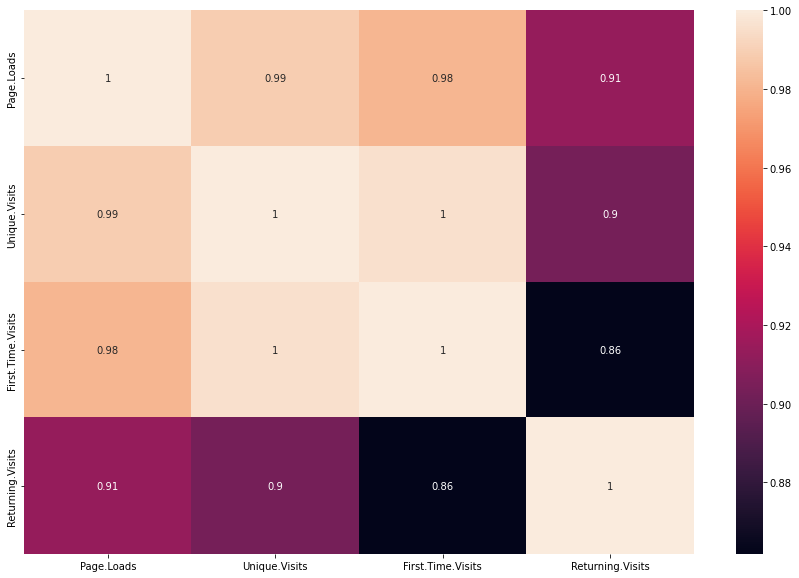

In [36]:
plt.figure(figsize=(15,10))
sns.heatmap(website.corr(), annot=True)
plt.savefig('./pic/Correlation Pic/Website/Corr_Website.png')

In [15]:
website.shape

(2167, 4)

In [6]:
def segment(data,col_name):
    Y = (data[col_name])
    X = data.drop(col_name,axis=1)
    return X,Y

In [7]:
def Train_Valid_Test(data,train_percent,valid_percent,test_percent):
    train_len = int(data.shape[0]*train_percent)
    valid_len = int(data.shape[0]*(train_percent + valid_percent)) 
    train_df = data.iloc[:train_len,:]
    valid_df = data.iloc[train_len:valid_len,:]
    test_df = data.iloc[valid_len:,:]
    return train_df,valid_df,test_df

def Split_Part(data,percent):
    train_len = int(data.shape[0]*percent)
    train_df = data.iloc[:train_len,:]
    test_df = data.iloc[train_len:,:]
    return train_df,test_df

In [8]:
def lag_data(data,max_lag,target):
    X = data.copy()
    X_col = list(X.columns)
    X_col.remove(target)
    for col in X_col:
        for i in range(2,max_lag+1):
            X[col+'_lag_'+str(i)] = X[col].shift(i-1)
    for i in X_col:
        X.rename(columns ={i:i+'_lag_1'},inplace = True)
    X.dropna(inplace = True) 
    return X

### Lag the feature based on the order of feature in data.columns
def lag_feature_df(max_lag,data,target):
    # Store each feature's dataframe:
    X = pd.DataFrame()
    X_col = list(data.columns)
    X_col.remove(target)
    feature_range = range(len(X_col))
    for idx,col in enumerate(X_col):
        for j in range(max_lag):
            X[col+'_lag_'+str(j+1)] = data[col].shift(j)
    X[target] = data[target].copy()
    X.dropna(inplace=True)
    return X

In [9]:
df = website.copy()

df['Unique.Visits_1'] = df['Unique.Visits'].shift(-1)
df.dropna(inplace=True)


df_lag = lag_feature_df(30,df,'Unique.Visits_1')

train_lag,valid_lag,test_lag = Train_Valid_Test(df_lag,0.7,0.1,0.2)
## Lagging
X_train_lag,Y_train_lag = segment(train_lag,'Unique.Visits_1')
X_valid_lag,Y_valid_lag = segment(valid_lag,'Unique.Visits_1')
X_test_lag,Y_test_lag = segment(test_lag,'Unique.Visits_1')

train_no,valid_no,test_no = Train_Valid_Test(df.loc[df_lag.index],0.7,0.1,0.2)

## No lagging
X_train_no,Y_train_no = segment(train_no,'Unique.Visits_1')
X_valid_no,Y_valid_no = segment(test_no,'Unique.Visits_1')
X_test_no,Y_test_no = segment(test_no,'Unique.Visits_1')

In [10]:
X_arr = X_train_lag.values

In [11]:
X_train_lag

Page.Loads_lag_1  Page.Loads_lag_2  Page.Loads_lag_3  \
Date                                                               
2014-10-13              4814            3031.0            2080.0   
2014-10-14              5040            4814.0            3031.0   
2014-10-15              5028            5040.0            4814.0   
2014-10-16              4658            5028.0            5040.0   
2014-10-17              3624            4658.0            5028.0   
...                      ...               ...               ...   
2018-11-11              4778            3506.0            5026.0   
2018-11-12              6684            4778.0            3506.0   
2018-11-13              6766            6684.0            4778.0   
2018-11-14              6916            6766.0            6684.0   
2018-11-15              6440            6916.0            6766.0   

            Page.Loads_lag_4  Page.Loads_lag_5  Page.Loads_lag_6  \
Date                                                               
2014-10-13            3565.0            4343.0            4187.0   
2014-10-14            2080.0            3565.0            4343.0   
2014-10-15            3031.0            2080.0            3565.0   
2014-10-16            4814.0            3031.0            2080.0   
2014-10-17            5040.0            4814.0            3031.0   
...                      ...               ...               ...   
2018-11-11            5692.0            5865.0            6330.0   
2018-11-12            5026.0            5692.0            5865.0   
2018-11-13            3506.0            5026.0            5692.0   
2018-11-14            4778.0            3506.0            5026.0   
2018-11-15            6684.0            4778.0            3506.0   

            Page.Loads_lag_7  Page.Loads_lag_8  Page.Loads_lag_9  \
Date                                                               
2014-10-13            4603.0            4501.0            2847.0   
2014-10-14            4187.0            4603.0            4501.0   
2014-10-15            4343.0            4187.0            4603.0   
2014-10-16            3565.0            4343.0            4187.0   
2014-10-17            2080.0            3565.0            4343.0   
...                      ...               ...               ...   
2018-11-11            6365.0            4638.0            3430.0   
2018-11-12            6330.0            6365.0            4638.0   
2018-11-13            5865.0            6330.0            6365.0   
2018-11-14            5692.0            5865.0            6330.0   
2018-11-15            5026.0            5692.0            5865.0   

            Page.Loads_lag_10  ...  Returning.Visits_lag_21  \
Date                           ...                            
2014-10-13             2054.0  ...                    268.0   
2014-10-14             2847.0  ...                    284.0   
2014-10-15             4501.0  ...                    286.0   
2014-10-16             4603.0  ...                    216.0   
2014-10-17             4187.0  ...                    140.0   
...                       ...  ...                      ...   
2018-11-11             4860.0  ...                    730.0   
2018-11-12             3430.0  ...                    761.0   
2018-11-13             4638.0  ...                    811.0   
2018-11-14             6365.0  ...                    752.0   
2018-11-15             6330.0  ...                    641.0   

            Returning.Visits_lag_22  Returning.Visits_lag_23  \
Date                                                           
2014-10-13                    274.0                    175.0   
2014-10-14                    268.0                    274.0   
2014-10-15                    284.0                    268.0   
2014-10-16                    286.0                    284.0   
2014-10-17                    216.0                    286.0   
...                             ...                      ...   
2018-11-11               

In [22]:
X_train_no

Page.Loads  Unique.Visits  First.Time.Visits  Returning.Visits
Date                                                                      
2014-10-13        4814           3339               2973               366
2014-10-14        5040           3604               3217               387
2014-10-15        5028           3515               3094               421
2014-10-16        4658           3331               2955               376
2014-10-17        3624           2477               2148               329
...                ...            ...                ...               ...
2018-11-11        4778           3265               2709               556
2018-11-12        6684           4592               3795               797
2018-11-13        6766           4720               3918               802
2018-11-14        6916           4674               3872               802
2018-11-15        6440           4379               3634               745

[1495 rows x 4 columns]

## Prediction Models

In [12]:
def LR_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    reg_Linear =  LinearRegression()
    reg_Linear.fit(x_train,y_train.reshape(-1,))
    y_Linear_a = reg_Linear.predict(x_test)
    y_Linear_a_inverse =minmax_y_test.inverse_transform(y_Linear_a.reshape((-1,1)))
    
    print(
        "Linear:rmse: ",sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
         "Linear:mae:",mean_absolute_error(y_Linear_a_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_Linear_a_inverse,y_test_inverse),
        'mape':mean_absolute_percentage_error(y_Linear_a_inverse,y_test_inverse)
    }
    return error_metrics

In [13]:
def ANN_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    ann_model = keras.Sequential([
        keras.layers.Dense(500,activation='relu',input_shape=[x_train.shape[1]]),
        keras.layers.Dense(500,activation='relu'),
        keras.layers.Dense(250,activation='relu'),
        keras.layers.Dense(250,activation='relu'),
        keras.layers.Dense(1)])#最后输出为一个结果，也就是预测的值
        #定义损失函数loss，采用的优化器optimizer为Adam
    ann_model.compile(loss='mean_absolute_error',optimizer='Adam')
    
    ann_model.fit(x_train,y_train.reshape(-1,))
    y_ann_model = ann_model.predict(x_test)
    y_ann_model_inverse =minmax_y_test.inverse_transform(y_ann_model.reshape((-1,1)))
    
    print(
          "ANN_mae:%f"%(mean_absolute_error(y_ann_model_inverse, Y_test  ))+"\n",
          "ANN_rmse:%f"%(sqrt(mean_squared_error(y_ann_model_inverse, Y_test  )))+"\n"
     )
    
#     y_df = {
#         "Original": Y_test.values,
#         'RandomForest_':y_ann_model_inverse
#     }
    
    error_metrics = {
        "mae":(mean_absolute_error(y_ann_model_inverse, Y_test  )),
        "rmse":(sqrt(mean_squared_error(y_ann_model_inverse, Y_test  ))),
        'mape':mean_absolute_percentage_error(y_ann_model_inverse, Y_test)
    }
    return error_metrics

In [14]:
def RF_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    rfr = RandomForestRegressor(max_depth=9)
#     param_grid = {"n_estimators":[10,100,300],"max_depth":range(1,31)}
#     grid_search = GridSearchCV(rfr,param_grid,cv = 3)

    rfr.fit(x_train,y_train.reshape(-1,))
    y_rfr = rfr.predict(x_test)
    y_rfr_inverse =minmax_y_test.inverse_transform(y_rfr.reshape((-1,1)))
    
    print(
          "RandomForest_mae:%f"%(mean_absolute_error(y_rfr_inverse, Y_test  ))+"\n",
          "RandomForest_rmse:%f"%(sqrt(mean_squared_error(y_rfr_inverse, Y_test  )))+"\n"
#           "elastic_mse:%f"%(mean_squared_error( y_elastic_inverse, Y_test  )),     
     )
    
#     y_df = {
#         "Original": Y_test.values,
#         'RandomForest_':y_rfr_inverse
#     }
    
    error_metrics = {
        "mae":(mean_absolute_error(y_rfr_inverse, Y_test  )),
        "rmse":(sqrt(mean_squared_error(y_rfr_inverse, Y_test  ))),
        'mape':mean_absolute_percentage_error(y_rfr_inverse, Y_test)
    }
    return error_metrics

In [15]:
def XGB_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))

    xgb = XGBRegressor(max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    objective='reg:squarederror', # 此默认参数与 XGBClassifier 不同
    booster='gbtree',
    gamma=0,
    min_child_weight=1,
    subsample=1,
    colsample_bytree=1,
    reg_alpha=0,
    reg_lambda=1,
    random_state=0)
    
    
    xgb.fit(x_train,y_train.reshape(-1,),eval_metric='rmse', verbose=50)
    y_xgb = xgb.predict(x_test)
    y_xgb_inverse =minmax_y_test.inverse_transform(y_xgb.reshape((-1,1)))
    
    print(
        "XGB rmse: ",sqrt(mean_squared_error(y_xgb_inverse,Y_test)),
         "XGB mae:",mean_absolute_error(y_xgb_inverse,Y_test)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_xgb_inverse,Y_test)),
        "mae":mean_absolute_error(y_xgb_inverse,Y_test),
        'mape':mean_absolute_percentage_error(y_xgb_inverse,Y_test)
    }
    
    return error_metrics

In [16]:
def LGB_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    
    gbm = lgb.LGBMRegressor(max_depth=12)
    gbm.fit(x_train, y_train)
    y_gbm = gbm.predict(x_test)
    y_gbm_inverse =minmax_y_test.inverse_transform(y_gbm.reshape((-1,1)))
    
    print(
        "LGB rmse: ",sqrt(mean_squared_error(y_gbm_inverse,y_test_inverse)),
         "LGB mae:",mean_absolute_error(y_gbm_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_gbm_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_gbm_inverse,y_test_inverse),
        'mape':mean_absolute_percentage_error(y_gbm_inverse,y_test_inverse)
    }
    
    
    return error_metrics

In [17]:
def SVR_Model(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
#     parameters = {, 'gamma':np.logspace(-5, 0, num=6, base=2.0),'C':np.logspace(-5, 5, num=11, base=2.0)}
#     grid_search = GridSearchCV(, cv=10, n_jobs=4, scoring='neg_mean_squared_error')
    svr = SVR(kernel='rbf', C=1e3, gamma=0.01)
    svr.fit(x_train,y_train.reshape(-1,))
#     print(grid_search.best_params_)
    y_svr = svr.predict(x_test)
    
    y_svr_inverse = minmax_y_test.inverse_transform(y_svr.reshape((-1,1)))
    
    print(
        "SVR rmse: ",sqrt(mean_squared_error(y_svr_inverse,y_test_inverse)),
         "SVR mae:",mean_absolute_error(y_svr_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_svr_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_svr_inverse,y_test_inverse),
        'mape':mean_absolute_percentage_error(y_svr_inverse,y_test_inverse)
    }
    
    return error_metrics

## BenchMark

In [18]:
def stacking_models(X_train,Y_train,X_test,Y_test):
    model_df =pd.DataFrame({
                 LR_Model.__name__:LR_Model(X_train,Y_train,X_test,Y_test),
                 RF_Model.__name__:RF_Model(X_train,Y_train,X_test,Y_test),
                 ANN_Model.__name__:ANN_Model(X_train,Y_train,X_test,Y_test),
                 XGB_Model.__name__:XGB_Model(X_train,Y_train,X_test,Y_test),
                 LGB_Model.__name__:LGB_Model(X_train,Y_train,X_test,Y_test),
                 SVR_Model.__name__:SVR_Model(X_train,Y_train,X_test,Y_test),
                }
                )
    return model_df

In [19]:
mi_xy = mutual_info_regression(X_train_lag,Y_train_lag)
mi_xx = np.zeros([X_train_lag.shape[1],X_train_lag.shape[1]])

for i in range(mi_xx.shape[1]):
    for j in range(mi_xx.shape[1]):
        mi_xx[i][j] = mutual_info_regression(X_arr[:,i].reshape(-1,1),X_arr[:,j])
    print(i+1,'/',mi_xx.shape[1],end='\r',flush=True)

In [20]:
def mRMR(selected,idx,metric_xy,metric_xx):
    
    mrmr = 0.0
    
    if len(selected) == 0:
        mrmr = metric_xy[idx]
        
    else:
        relevance_score = 0
        redundency_score = 0
        relevance_score = metric_xy[idx] 
        X_s = selected+[idx]
        col_len = len(selected)
        
        for i in selected:
            redundency_score+=metric_xx[idx][i]
        redundency_score/=(col_len)
        
#         for i in X_s:
#             relevance_score+=metric_xy[i]
#         relevance_score/=(col_len)
        

#         for i in range(col_len - 1):
#             for j in range(i+1,col_len):
#                 redundency_score+=metric_xx[X_s[i]][X_s[j]]
#         redundency_score/=(col_len)
        
        mrmr = (relevance_score - redundency_score)

    return mrmr

def incremental_selection(x,metric):
    X = np.array(x)
    selected = [] # indices of selected fetures
    rest = list(range(X.shape[1]))
    scores = []
    metric_xy = []
    metric_xx = []
    # stop = False
    if metric == 'MI-MI':
        metric_xy = mi_xy
        metric_xx = mi_xx
    elif metric == 'MI-MI-Norm':
        metric_xy = mi_xy_norm 
        metric_xx = mi_norm
    elif metric == 'MI-MIC':
        metric_xy = mi_xy_norm
        metric_xx = mic_norm
    elif metric == 'MIC-MI':
        metric_xy = mic_xy_norm
        metric_xx = mi_norm
    elif metric =='MI-CCF':
        metric_xy = mi_xy
        metric_xx = ccf_xx
    elif metric=='MI-CCF-Norm':
        metric_xy = mi_xy_norm
        metric_xx = ccf_norm
    elif metric == 'MI-Pearson':
        metric_xy = mi_xy_norm
        metric_xx = pearson_norm   
    print(metric)
    while len(rest)>0 :
        id_max = rest[0]
        max_score = 0   
        for idx in rest:
            temp_score = mRMR(selected,idx,metric_xy,metric_xx)
            if temp_score>max_score:
                id_max = idx
                max_score = temp_score
        if max_score <=0:        
             return selected
             break                
        selected = selected + [id_max]
        rest.remove(id_max)
        print(f"selected:{selected},delta_score:{max_score}",end = "\r",flush=True)
    
    return selected

In [21]:
mi_mi = incremental_selection(X_train_lag,'MI-MI')
len(mi_mi)

MI-MI


21

In [22]:
MI_MI_result = stacking_models(X_train_lag.iloc[:,mi_mi],Y_train_lag,X_test_lag.iloc[:,mi_mi],Y_test_lag)

Linear:rmse:  319.41262428314644 Linear:mae: 237.40891426589678
RandomForest_mae:210.644818
 RandomForest_rmse:294.687208

47/47 [==============================] - 2s 9ms/step - loss: 0.0808
ANN_mae:229.452790
 ANN_rmse:324.101675

XGB rmse:  292.690298912922 XGB mae: 216.8044005777234
LGB rmse:  275.56205001817204 LGB mae: 202.4387080578289
SVR rmse:  284.1263102352743 SVR mae: 219.1967369044114


In [23]:
MI_MI_result

LR_Model    RF_Model   ANN_Model   XGB_Model   LGB_Model   SVR_Model
rmse  319.412624  294.687208  324.101675  292.690299  275.562050  284.126310
mae   237.408914  210.644818  229.452790  216.804401  202.438708  219.196737
mape    0.082782    0.075005    0.079107    0.076356    0.070980    0.078544

### Raw Data

In [30]:
raw_df = stacking_models(X_train_no,Y_train_no,X_test_no,Y_test_no)

Linear:rmse:  61122552627115.23 Linear:mae: 49219742397708.445
RandomForest_mae:439.930142
 RandomForest_rmse:564.747627

47/47 [==============================] - 1s 5ms/step - loss: 0.1430
ANN_mae:455.102262
 ANN_rmse:569.346876

XGB rmse:  540.906195281057 XGB mae: 423.7720217125438
LGB rmse:  579.8868478422967 LGB mae: 447.8423972468545
SVR rmse:  554.9738980653635 SVR mae: 457.8693228859587


In [31]:
raw_df

LR_Model    RF_Model   ANN_Model   XGB_Model   LGB_Model   SVR_Model
rmse  6.112255e+13  564.747627  569.346876  540.906195  579.886848  554.973898
mae   4.921974e+13  439.930142  455.102262  423.772022  447.842397  457.869323
mape  1.000000e+00    0.155373    0.159247    0.149024    0.157753    0.167577

### All Lag

In [32]:
all_df = stacking_models(X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

Linear:rmse:  680408010366.4844 Linear:mae: 533558000812.39124
RandomForest_mae:204.038791
 RandomForest_rmse:282.540000

47/47 [==============================] - 1s 6ms/step - loss: 0.1034
ANN_mae:274.963427
 ANN_rmse:383.867698

XGB rmse:  255.0238059672656 XGB mae: 191.65680815794758
LGB rmse:  255.0832589622255 LGB mae: 190.66641260542036
SVR rmse:  273.0067367228087 SVR mae: 206.4907555693442


In [33]:
all_df

LR_Model    RF_Model   ANN_Model   XGB_Model   LGB_Model   SVR_Model
rmse  6.804080e+11  282.540000  383.867698  255.023806  255.083259  273.006737
mae   5.335580e+11  204.038791  274.963427  191.656808  190.666413  206.490756
mape  1.000000e+00    0.072273    0.090734    0.068920    0.067764    0.073625

## PACF

In [24]:
def lag_based_PACF(data,max_lag,width):
    lags_pacf,interval = stattools.pacf(data,max_lag,"yw",width)
    lags = []
    boundary = (interval[:,1] - lags_pacf)[1]
    lags_pacf = np.abs(lags_pacf)
    for idx,lag in enumerate(lags_pacf):
        if lag > boundary:
            lags.append(idx)
    return lags

In [25]:
lags_pacf = {}
for col in X_train_no.columns:
    lags_pacf[col] = lag_based_PACF(X_train_no[col],29,0.05)
cols = []
for k,v in lags_pacf.items():
    for j in v:
        cols.append(k+'_lag_'+str(j+1))        

In [26]:
len(cols)

76

In [27]:
pacf_df = stacking_models(X_train_lag[cols],Y_train_lag,X_test_lag[cols],Y_test_lag)

Linear:rmse:  6504329700543.863 Linear:mae: 4988773188992.514
RandomForest_mae:200.071455
 RandomForest_rmse:275.594540

47/47 [==============================] - 1s 5ms/step - loss: 0.0870
ANN_mae:260.602914
 ANN_rmse:352.953601

XGB rmse:  252.7874179456392 XGB mae: 190.12988480897707
LGB rmse:  245.6177438041737 LGB mae: 181.58272137142322
SVR rmse:  268.427645956168 SVR mae: 205.6674294383875


In [28]:
pacf_df

LR_Model    RF_Model   ANN_Model   XGB_Model   LGB_Model   SVR_Model
rmse  6.504330e+12  275.594540  352.953601  252.787418  245.617744  268.427646
mae   4.988773e+12  200.071455  260.602914  190.129885  181.582721  205.667429
mape  1.000000e+00    0.070951    0.093327    0.068164    0.064556    0.072307

In [29]:
X_train_no.shape[1]

4

## Feature Selection

### Construct Corr Matrix 

In [30]:
x_mat = np.zeros([X_train_lag.shape[1],X_train_lag.shape[1]])
feature_num = X_train_no.shape[1]
max_lag = 30

for i in range(0,feature_num):
    ## For each feature,we computew its corr with its self and other features
    ## Self Correlation
    row_start = max_lag*i
    col_end = max_lag*(i+1)
    print(row_start,col_end)
    x_mat[row_start,row_start+1:col_end] = [stats.pearsonr(X_arr[:,row_start],X_arr[:,p])[0] for p in range(max_lag*i+1,max_lag*(i+1))]
    ## Diagnal
    for k in range(row_start+1,col_end-1):
        for j in range(row_start,max_lag*(i+1)-(k-max_lag*i)):
            x_mat[j,j+(k-max_lag*i)] = x_mat[row_start,k]
            
    ## Between Features
    for row in range(col_end,X_arr.shape[1]):
        for col in range(row_start,col_end):
            x_mat[col][row] = stats.pearsonr(X_arr[:,row],X_arr[:,col])[0]

0 30
30 60
60 90
90 120


In [31]:
corr_copy = np.abs(copy.deepcopy(x_mat))

In [32]:
pd.DataFrame(corr_copy)

0         1         2         3         4         5         6    \
0    0.0  0.736638  0.322043  0.113778  0.102672  0.290471  0.680312   
1    0.0  0.000000  0.736638  0.322043  0.113778  0.102672  0.290471   
2    0.0  0.000000  0.000000  0.736638  0.322043  0.113778  0.102672   
3    0.0  0.000000  0.000000  0.000000  0.736638  0.322043  0.113778   
4    0.0  0.000000  0.000000  0.000000  0.000000  0.736638  0.322043   
..   ...       ...       ...       ...       ...       ...       ...   
115  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
116  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
117  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
118  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
119  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          7         8         9    ...       110       111       112  \
0    0.911408  0.656227  0.243857  ...  0.443014  0.650872  0.380879   
1    0.680312  0.911408  0.656227  ...  0.063184  0.443029  0.650369   
2    0.290471  0.680312  0.911408  ...  0.125428  0.063544  0.443064   
3    0.102672  0.290471  0.680312  ...  0.127534  0.126161  0.062228   
4    0.113778  0.102672  0.290471  ...  0.050652  0.128773  0.128293   
..        ...       ...       ...  ...       ...       ...       ...   
115  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
116  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
117  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
118  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
119  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

          113       114       115       116       117       118       119  
0    0.004637  0.174933  0.171572  0.018295  0.400329  0.608388  0.343743  
1    0.380060  0.005507  0.175665  0.170653  0.019699  0.401003  0.607912  
2    0.650187  0.379829  0.005699  0.174062  0.168523  0.021128  0.401197  
3    0.441591  0.649400  0.378909  0.005040  0.173062  0.168346  0.019954  
4    0.059726  0.439993  0.648134  0.379320  0.004452  0.173501  0.170333  
..        ...       ...       ...       ...       ...       ...       ...  
115  0.000000  0.000000  0.000000  0.709840  0.295827  0.112847  0.103394  
116  0.000000  0.000000  0.000000  0.000000  0.709840  0.295827  0.112847  
117  0.000000  0.000000  0.000000  0.000000  0.000000  0.709840  0.295827  
118  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.709840  
119  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[120 rows x 120 columns]

In [33]:
def flat(nums):
    res = []
    for i in nums:
        if isinstance(i, list):
            res.extend(flat(i))
        else:
            res.append(i)
    return res

In [34]:
def generate_feature_subsets(corr_matrix,threshold,X_train,Y_train):
    
    correlation_pairs = np.argwhere(corr_matrix>=threshold)
    
    # Check how many features are highly correlated with 1 feature
    correlated_pairs_dict = {}

    for i in set(correlation_pairs[:,0]):
        correlated_pairs_dict[i] = []
        for j in correlation_pairs:
            if j[0]==i:
                correlated_pairs_dict[i].append(j[1])
                
    high_correlated_features = list(set(correlation_pairs.flatten()))
    print("High_correlated_features",len(high_correlated_features))
    corr_cols = X_train.columns[high_correlated_features]
    
    check_corr_pairs = {}
    kk = list(correlated_pairs_dict.keys())
    kk_copy = kk.copy()
    for j in kk_copy:
        check_corr_pairs[j] = correlated_pairs_dict[j].copy()
        for i in correlated_pairs_dict[j]:
            if i in kk:
                check_corr_pairs[j].append(correlated_pairs_dict[i])
                for q in correlated_pairs_dict[i]:
                    if q in kk_copy:
                        kk_copy.remove(q)
            if i in kk_copy:
                    kk_copy.remove(i)
        check_corr_pairs[j] = list(set(flat(check_corr_pairs[j])))
        
    ### Make redundant features into groups    
    redundant_group = []

    for k,v in check_corr_pairs.items():
        redundant_group.append([k]+v)
    
    # Rank features according to MI
    max_feats = len(corr_cols)
    sel_function = mutual_info_regression
    fs = SelectKBest(score_func=sel_function, k=max_feats)
    fs.fit(X_train[corr_cols],Y_train)
    mutual_info = dict(zip(high_correlated_features,fs.scores_))
    sorted_by_mutual_info =[key for (key,val) in sorted(mutual_info.items(), key=lambda kv: kv[1],reverse=True)]
#     print("sorted_by_mutual_info",sorted_by_mutual_info)
    
    ## Highly-Correlated Features
    mrmr_features = []
    for i in redundant_group:
        indexes = [sorted_by_mutual_info.index(j) for j in i]
        mrmr_features.append(sorted_by_mutual_info[min(indexes)])
    print("MRMR Features",len(mrmr_features))

    ## Uncorelated features
    lst = []
    for i in range(X_train.shape[1]):
        if i not in high_correlated_features:
            lst.append(i)
    ## Joint filtered features with uncorrelated pairs
    final_list = list(set(mrmr_features+lst))
    
    print("Final Features:",len(final_list))
    return final_list,len(mrmr_features),len(high_correlated_features)

In [70]:
feature_collections = {}
mrmr_len = {}
correlated_features_len = {}
for i in np.round(arange(0.9,1.00,0.01),3):
    print(i)
    results = generate_feature_subsets(corr_copy,i,X_train_lag,Y_train_lag)
    feature_collections[i] = list(X_train_lag.columns[results[0]])
    mrmr_len[i] = results[1]
    correlated_features_len[i] = results[2]

0.9
High_correlated_features 120
MRMR Features 14
Final Features: 14
0.91
High_correlated_features 120
MRMR Features 21
Final Features: 21
0.92
High_correlated_features 93
MRMR Features 30
Final Features: 57
0.93
High_correlated_features 90
MRMR Features 30
Final Features: 60
0.94
High_correlated_features 90
MRMR Features 30
Final Features: 60
0.95
High_correlated_features 90
MRMR Features 30
Final Features: 60
0.96
High_correlated_features 90
MRMR Features 30
Final Features: 60
0.97
High_correlated_features 90
MRMR Features 30
Final Features: 60
0.98
High_correlated_features 90
MRMR Features 30
Final Features: 60
0.99
High_correlated_features 90
MRMR Features 30
Final Features: 60


In [71]:
for k,v in feature_collections.items():
    print(k,len(v))

0.9 14
0.91 21
0.92 57
0.93 60
0.94 60
0.95 60
0.96 60
0.97 60
0.98 60
0.99 60


In [72]:
feature_nums = {}
for k,v in feature_collections.items():
    feature_nums[k] = len(v)

In [73]:
features_compare = pd.DataFrame({
                "High correlated Features":correlated_features_len,
                "MRMR":mrmr_len,
                'Final Features':feature_nums
})

In [74]:
features_compare

High correlated Features  MRMR  Final Features
0.90                       120    14              14
0.91                       120    21              21
0.92                        93    30              57
0.93                        90    30              60
0.94                        90    30              60
0.95                        90    30              60
0.96                        90    30              60
0.97                        90    30              60
0.98                        90    30              60
0.99                        90    30              60

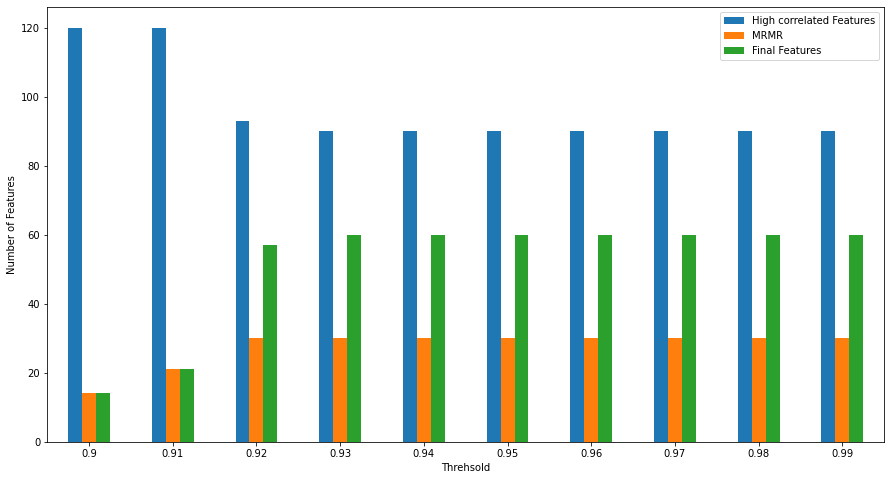

In [75]:
# plt.figure()
ax = features_compare.plot.bar(rot=0,figsize=(15,8))
plt.legend(loc='upper right')
plt.xlabel("Threhsold")
plt.ylabel("Number of Features")
plt.savefig("./pic/Correlation Pic/Website/feature_reduction_Website.png")

## Recursive Feature Elimination

## LightBGM,Random Forest,XGBoost

In [42]:
def lgb_pipeline(X_train,Y_train,X_test,Y_test,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test = minmax_y_test.fit_transform(Y_test.values.reshape(-1,1))
    
    gbm = lgb.LGBMRegressor()
    gbm.fit(x_train, y_train,eval_set = [(x_test,y_test)],early_stopping_rounds = 10)

    features = X_train.columns
    importances = gbm.feature_importances_
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = features
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
    
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
#     plt.title('Top 10 features with LightBGM model')
#     plt.show()
    
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    return top_features

In [43]:
def rfr_pipeline(X_train,Y_train,top_feature_num,i):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))

    rfr = RandomForestRegressor()
    rfr.fit(x_train,y_train.reshape(-1,))
    
    feature_names = X_train.columns
    importances = rfr.feature_importances_
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = feature_names
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
    
#     fig = sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
#     plt.title('Top 10 features with Random Forest model')
#     plt.savefig('./pic/RMSE/Electricity/feature_round_'+str(i)+'.png')
#     plt.show()
    
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    
    return top_features

In [44]:
def xgb_pipeline(X_train,Y_train,X_test,Y_test,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test = minmax_y_test.fit_transform(Y_test.values.reshape(-1,1))
    
    xgb = XGBRegressor()
    xgb.fit(x_train,y_train.reshape(-1,),eval_set=[(x_test, y_test)],early_stopping_rounds=10)

    feature_names = X_train.columns
    importances = xgb.feature_importances_
#     plot_importance(xgb,max_num_features=10,importance_type='gain',show_values=False)
    
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = feature_names
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
# #     plt.barh(importances_df['Feature_Name'][:10], importances_df['Feature_Importance'][:10]) 
#     plt.title('Top 10 features with XGB model')
#     plt.show()
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    return top_features

In [45]:
def rfr_recursive(cols,feature_num_1,feature_num_2,X_train,Y_train,):
    
    max_end = int(0.2*len(cols))
    
    range_end = 0
    
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                rfr_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    rfr_features.append( rfr_pipeline(X_train[now_cols],Y_train,j,i))
                rfr_features = list(set(np.array(rfr_features).flatten()))
                features_dict[j] = rfr_features
                print(j,end='\r',flush=True)
                
            return features_dict
        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
        features_dict = {}
        for j in range(feature_num_1,range_end+1):
            rfr_features = []
            for i in range(5):
                col_len = int(len(cols)*i*0.2)
                now_cols = cols[col_len:]
                rfr_features.append( rfr_pipeline(X_train[now_cols],Y_train,j,i))

            rfr_features = list(set(np.array(rfr_features).flatten()))
            features_dict[j] = rfr_features
        
            print(j,end='\r',flush=True)
        return features_dict

In [46]:
def lgb_recursive(cols,feature_num_1,feature_num_2,X_train,Y_train,X_valid,Y_valid):
    
    max_end = int(0.2*len(cols))
    range_end = 0

    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                lgb_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    lgb_features.append( lgb_pipeline(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))

                lgb_features = list(set(np.array(lgb_features).flatten()))
                features_dict[j] = lgb_features
                print(j,end='\r',flush=True)
            return features_dict
        
    features_dict = {}
    
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
    
    for j in range(feature_num_1,range_end+1):
        lgb_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            lgb_features.append(lgb_pipeline(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))
        lgb_features = list(set(np.array(lgb_features).flatten()))
        features_dict[j] = lgb_features
        print(j,end='\r',flush=True)
    return features_dict

In [47]:
def xgb_recursive(cols,feature_num_1,feature_num_2,X_train,Y_train,X_valid,Y_valid):
    
    max_end = int(0.2*len(cols))
    range_end = 0
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                xgb_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    xgb_features.append( xgb_pipeline(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))
                xgb_features = list(set(np.array(xgb_features).flatten()))
                features_dict[j] = xgb_features
                print(j,end='\r',flush=True)
            return features_dict
        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
    features_dict = {}
    for j in range(feature_num_1,range_end +1):
        xgb_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            xgb_features.append( xgb_pipeline(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))
        xgb_features = list(set(np.array(xgb_features).flatten()))
        features_dict[j] = xgb_features
        print(j,end='\r',flush=True)
    return features_dict

In [76]:
real_lgb = {}
for k,v in feature_collections.items():
    real_lgb[k] = lgb_recursive(v,1,5,X_train_lag,Y_train_lag,X_valid_lag,Y_valid_lag)

[1]	valid_0's l2: 0.0475556
[2]	valid_0's l2: 0.0404061
[3]	valid_0's l2: 0.0347078
[4]	valid_0's l2: 0.029993
[5]	valid_0's l2: 0.0261656
[6]	valid_0's l2: 0.0229611
[7]	valid_0's l2: 0.0204934
[8]	valid_0's l2: 0.0183394
[9]	valid_0's l2: 0.0165981
[10]	valid_0's l2: 0.0150616
[11]	valid_0's l2: 0.0137613
[12]	valid_0's l2: 0.0127075
[13]	valid_0's l2: 0.0118667
[14]	valid_0's l2: 0.0111289
[15]	valid_0's l2: 0.0104773
[16]	valid_0's l2: 0.00981483
[17]	valid_0's l2: 0.00926246
[18]	valid_0's l2: 0.00882513
[19]	valid_0's l2: 0.00840612
[20]	valid_0's l2: 0.00805453
[21]	valid_0's l2: 0.00776176
[22]	valid_0's l2: 0.00748261
[23]	valid_0's l2: 0.00724293
[24]	valid_0's l2: 0.00703963
[25]	valid_0's l2: 0.00686333
[26]	valid_0's l2: 0.00669683
[27]	valid_0's l2: 0.0065194
[28]	valid_0's l2: 0.00630697
[29]	valid_0's l2: 0.00614332
[30]	valid_0's l2: 0.00597349
[31]	valid_0's l2: 0.0057916
[32]	valid_0's l2: 0.00564863
[33]	valid_0's l2: 0.00550449
[34]	valid_0's l2: 0.00539923
[35]	va

[2]	valid_0's l2: 0.0405803
[3]	valid_0's l2: 0.0348515
[4]	valid_0's l2: 0.0302046
[5]	valid_0's l2: 0.0263865
[6]	valid_0's l2: 0.0230476
[7]	valid_0's l2: 0.0204263
[8]	valid_0's l2: 0.01812
[9]	valid_0's l2: 0.0162348
[10]	valid_0's l2: 0.0147087
[11]	valid_0's l2: 0.0133846
[12]	valid_0's l2: 0.0122233
[13]	valid_0's l2: 0.0113977
[14]	valid_0's l2: 0.0105737
[15]	valid_0's l2: 0.00997314
[16]	valid_0's l2: 0.00939838
[17]	valid_0's l2: 0.00892005
[18]	valid_0's l2: 0.00849226
[19]	valid_0's l2: 0.00817605
[20]	valid_0's l2: 0.00788142
[21]	valid_0's l2: 0.00756546
[22]	valid_0's l2: 0.00729539
[23]	valid_0's l2: 0.00709472
[24]	valid_0's l2: 0.00691572
[25]	valid_0's l2: 0.00675495
[26]	valid_0's l2: 0.00665692
[27]	valid_0's l2: 0.00653513
[28]	valid_0's l2: 0.00644154
[29]	valid_0's l2: 0.00637256
[30]	valid_0's l2: 0.00631579
[31]	valid_0's l2: 0.00625428
[32]	valid_0's l2: 0.00620269
[33]	valid_0's l2: 0.0061478
[34]	valid_0's l2: 0.00611956
[35]	valid_0's l2: 0.00605292
[36]

[1]	valid_0's l2: 0.0476677
[2]	valid_0's l2: 0.0404689
[3]	valid_0's l2: 0.0346195
[4]	valid_0's l2: 0.0298944
[5]	valid_0's l2: 0.0260952
[6]	valid_0's l2: 0.0229002
[7]	valid_0's l2: 0.0204583
[8]	valid_0's l2: 0.0182171
[9]	valid_0's l2: 0.0164413
[10]	valid_0's l2: 0.0149702
[11]	valid_0's l2: 0.0136114
[12]	valid_0's l2: 0.0125978
[13]	valid_0's l2: 0.0116262
[14]	valid_0's l2: 0.01078
[15]	valid_0's l2: 0.00999921
[16]	valid_0's l2: 0.00937747
[17]	valid_0's l2: 0.00886365
[18]	valid_0's l2: 0.00838761
[19]	valid_0's l2: 0.00802819
[20]	valid_0's l2: 0.0076788
[21]	valid_0's l2: 0.00740599
[22]	valid_0's l2: 0.00712763
[23]	valid_0's l2: 0.0068712
[24]	valid_0's l2: 0.00669594
[25]	valid_0's l2: 0.00650109
[26]	valid_0's l2: 0.00631872
[27]	valid_0's l2: 0.00617684
[28]	valid_0's l2: 0.00601593
[29]	valid_0's l2: 0.00586426
[30]	valid_0's l2: 0.00569967
[31]	valid_0's l2: 0.00561877
[32]	valid_0's l2: 0.00547365
[33]	valid_0's l2: 0.00534159
[34]	valid_0's l2: 0.00525248
[35]	va

[88]	valid_0's l2: 0.00533172
[89]	valid_0's l2: 0.00533582
[90]	valid_0's l2: 0.00533092
[91]	valid_0's l2: 0.0053322
[92]	valid_0's l2: 0.00530915
[93]	valid_0's l2: 0.00530807
[94]	valid_0's l2: 0.00530667
[95]	valid_0's l2: 0.00530234
[96]	valid_0's l2: 0.00530157
[97]	valid_0's l2: 0.00529869
[98]	valid_0's l2: 0.00529855
[99]	valid_0's l2: 0.00528653
[100]	valid_0's l2: 0.00527653
[1]	valid_0's l2: 0.0478666
[2]	valid_0's l2: 0.0410197
[3]	valid_0's l2: 0.0352396
[4]	valid_0's l2: 0.030477
[5]	valid_0's l2: 0.0267398
[6]	valid_0's l2: 0.0235107
[7]	valid_0's l2: 0.0209018
[8]	valid_0's l2: 0.0186863
[9]	valid_0's l2: 0.0169113
[10]	valid_0's l2: 0.0154277
[11]	valid_0's l2: 0.0141394
[12]	valid_0's l2: 0.0130372
[13]	valid_0's l2: 0.0121893
[14]	valid_0's l2: 0.0114633
[15]	valid_0's l2: 0.0109349
[16]	valid_0's l2: 0.0103899
[17]	valid_0's l2: 0.00993739
[18]	valid_0's l2: 0.00958799
[19]	valid_0's l2: 0.00925385
[20]	valid_0's l2: 0.00896742
[21]	valid_0's l2: 0.00871051
[22]	v

[95]	valid_0's l2: 0.0080032
[96]	valid_0's l2: 0.00798924
[97]	valid_0's l2: 0.0079701
[98]	valid_0's l2: 0.00798435
[99]	valid_0's l2: 0.0079887
[100]	valid_0's l2: 0.00795538
[1]	valid_0's l2: 0.0485922
[2]	valid_0's l2: 0.0420986
[3]	valid_0's l2: 0.0367962
[4]	valid_0's l2: 0.032573
[5]	valid_0's l2: 0.029212
[6]	valid_0's l2: 0.0264314
[7]	valid_0's l2: 0.0242524
[8]	valid_0's l2: 0.0224129
[9]	valid_0's l2: 0.0207407
[10]	valid_0's l2: 0.0194521
[11]	valid_0's l2: 0.0184146
[12]	valid_0's l2: 0.0173101
[13]	valid_0's l2: 0.0165046
[14]	valid_0's l2: 0.0159683
[15]	valid_0's l2: 0.0155465
[16]	valid_0's l2: 0.0151592
[17]	valid_0's l2: 0.0148105
[18]	valid_0's l2: 0.0143497
[19]	valid_0's l2: 0.0139219
[20]	valid_0's l2: 0.0135217
[21]	valid_0's l2: 0.0133105
[22]	valid_0's l2: 0.0130064
[23]	valid_0's l2: 0.0127732
[24]	valid_0's l2: 0.0126282
[25]	valid_0's l2: 0.0125593
[26]	valid_0's l2: 0.0124251
[27]	valid_0's l2: 0.0122888
[28]	valid_0's l2: 0.0120779
[29]	valid_0's l2: 0.

[62]	valid_0's l2: 0.00426203
[63]	valid_0's l2: 0.00427182
[64]	valid_0's l2: 0.00425411
[65]	valid_0's l2: 0.00423814
[66]	valid_0's l2: 0.00423519
[67]	valid_0's l2: 0.00421918
[68]	valid_0's l2: 0.00422923
[69]	valid_0's l2: 0.0042328
[70]	valid_0's l2: 0.00424521
[71]	valid_0's l2: 0.00423563
[72]	valid_0's l2: 0.00422467
[73]	valid_0's l2: 0.00420697
[74]	valid_0's l2: 0.00419402
[75]	valid_0's l2: 0.00419229
[76]	valid_0's l2: 0.00419037
[77]	valid_0's l2: 0.00419526
[78]	valid_0's l2: 0.0041823
[79]	valid_0's l2: 0.00417971
[80]	valid_0's l2: 0.00417513
[81]	valid_0's l2: 0.00416483
[82]	valid_0's l2: 0.00416092
[83]	valid_0's l2: 0.00414983
[84]	valid_0's l2: 0.00414509
[85]	valid_0's l2: 0.00413309
[86]	valid_0's l2: 0.00413122
[87]	valid_0's l2: 0.00412359
[88]	valid_0's l2: 0.00412795
[89]	valid_0's l2: 0.00412204
[90]	valid_0's l2: 0.00411162
[91]	valid_0's l2: 0.00411608
[92]	valid_0's l2: 0.00410877
[93]	valid_0's l2: 0.00410637
[94]	valid_0's l2: 0.00410044
[95]	valid_0

[49]	valid_0's l2: 0.0158848
[50]	valid_0's l2: 0.0158084
[51]	valid_0's l2: 0.0158333
[52]	valid_0's l2: 0.0156695
[53]	valid_0's l2: 0.0156899
[54]	valid_0's l2: 0.0156584
[55]	valid_0's l2: 0.01573
[56]	valid_0's l2: 0.0156522
[57]	valid_0's l2: 0.0156027
[58]	valid_0's l2: 0.0155428
[59]	valid_0's l2: 0.0155396
[60]	valid_0's l2: 0.0154975
[61]	valid_0's l2: 0.0155446
[62]	valid_0's l2: 0.0155643
[63]	valid_0's l2: 0.0154983
[64]	valid_0's l2: 0.0153751
[65]	valid_0's l2: 0.0153634
[66]	valid_0's l2: 0.0153218
[67]	valid_0's l2: 0.0153095
[68]	valid_0's l2: 0.0153341
[69]	valid_0's l2: 0.0153377
[70]	valid_0's l2: 0.0153451
[71]	valid_0's l2: 0.0153227
[72]	valid_0's l2: 0.0152661
[73]	valid_0's l2: 0.0152934
[74]	valid_0's l2: 0.0153179
[75]	valid_0's l2: 0.01534
[76]	valid_0's l2: 0.0152878
[77]	valid_0's l2: 0.0152837
[78]	valid_0's l2: 0.0153298
[79]	valid_0's l2: 0.015348
[80]	valid_0's l2: 0.0153041
[81]	valid_0's l2: 0.0153559
[82]	valid_0's l2: 0.0153339
[1]	valid_0's l2: 0

[83]	valid_0's l2: 0.00822857
[84]	valid_0's l2: 0.00823305
[85]	valid_0's l2: 0.0082146
[86]	valid_0's l2: 0.00818341
[87]	valid_0's l2: 0.00813706
[88]	valid_0's l2: 0.00812814
[89]	valid_0's l2: 0.00811538
[90]	valid_0's l2: 0.00810111
[91]	valid_0's l2: 0.00806874
[92]	valid_0's l2: 0.00805125
[93]	valid_0's l2: 0.00803569
[94]	valid_0's l2: 0.00799581
[95]	valid_0's l2: 0.0080032
[96]	valid_0's l2: 0.00798924
[97]	valid_0's l2: 0.0079701
[98]	valid_0's l2: 0.00798435
[99]	valid_0's l2: 0.0079887
[100]	valid_0's l2: 0.00795538
[1]	valid_0's l2: 0.0485922
[2]	valid_0's l2: 0.0420986
[3]	valid_0's l2: 0.0367962
[4]	valid_0's l2: 0.032573
[5]	valid_0's l2: 0.029212
[6]	valid_0's l2: 0.0264314
[7]	valid_0's l2: 0.0242524
[8]	valid_0's l2: 0.0224129
[9]	valid_0's l2: 0.0207407
[10]	valid_0's l2: 0.0194521
[11]	valid_0's l2: 0.0184146
[12]	valid_0's l2: 0.0173101
[13]	valid_0's l2: 0.0165046
[14]	valid_0's l2: 0.0159683
[15]	valid_0's l2: 0.0155465
[16]	valid_0's l2: 0.0151592
[17]	valid

[10]	valid_0's l2: 0.0147807
[11]	valid_0's l2: 0.0134971
[12]	valid_0's l2: 0.0124349
[13]	valid_0's l2: 0.0115494
[14]	valid_0's l2: 0.0108047
[15]	valid_0's l2: 0.0100449
[16]	valid_0's l2: 0.00939974
[17]	valid_0's l2: 0.00888626
[18]	valid_0's l2: 0.00839176
[19]	valid_0's l2: 0.00800025
[20]	valid_0's l2: 0.00768699
[21]	valid_0's l2: 0.00736834
[22]	valid_0's l2: 0.00705909
[23]	valid_0's l2: 0.00679019
[24]	valid_0's l2: 0.0065885
[25]	valid_0's l2: 0.00636498
[26]	valid_0's l2: 0.00616833
[27]	valid_0's l2: 0.00595422
[28]	valid_0's l2: 0.00579128
[29]	valid_0's l2: 0.00562896
[30]	valid_0's l2: 0.00549222
[31]	valid_0's l2: 0.00536433
[32]	valid_0's l2: 0.00525164
[33]	valid_0's l2: 0.00517183
[34]	valid_0's l2: 0.00508885
[35]	valid_0's l2: 0.0050044
[36]	valid_0's l2: 0.0049319
[37]	valid_0's l2: 0.00488266
[38]	valid_0's l2: 0.00481045
[39]	valid_0's l2: 0.00474975
[40]	valid_0's l2: 0.00468991
[41]	valid_0's l2: 0.00463547
[42]	valid_0's l2: 0.00458566
[43]	valid_0's l2: 

[2]	valid_0's l2: 0.0456108
[3]	valid_0's l2: 0.0414317
[4]	valid_0's l2: 0.0382012
[5]	valid_0's l2: 0.0354838
[6]	valid_0's l2: 0.0330789
[7]	valid_0's l2: 0.0310134
[8]	valid_0's l2: 0.0291691
[9]	valid_0's l2: 0.0273236
[10]	valid_0's l2: 0.0259983
[11]	valid_0's l2: 0.0249091
[12]	valid_0's l2: 0.0240201
[13]	valid_0's l2: 0.0231661
[14]	valid_0's l2: 0.022548
[15]	valid_0's l2: 0.0222729
[16]	valid_0's l2: 0.0215823
[17]	valid_0's l2: 0.0209787
[18]	valid_0's l2: 0.0204979
[19]	valid_0's l2: 0.0200288
[20]	valid_0's l2: 0.0196879
[21]	valid_0's l2: 0.0194296
[22]	valid_0's l2: 0.0190496
[23]	valid_0's l2: 0.018712
[24]	valid_0's l2: 0.0184326
[25]	valid_0's l2: 0.018132
[26]	valid_0's l2: 0.0178614
[27]	valid_0's l2: 0.0176204
[28]	valid_0's l2: 0.017563
[29]	valid_0's l2: 0.0173935
[30]	valid_0's l2: 0.0171426
[31]	valid_0's l2: 0.0169832
[32]	valid_0's l2: 0.0168346
[33]	valid_0's l2: 0.0166267
[34]	valid_0's l2: 0.0165326
[35]	valid_0's l2: 0.01646
[36]	valid_0's l2: 0.0162604

[32]	valid_0's l2: 0.00512837
[33]	valid_0's l2: 0.00501983
[34]	valid_0's l2: 0.00496718
[35]	valid_0's l2: 0.00489202
[36]	valid_0's l2: 0.00479557
[37]	valid_0's l2: 0.00474077
[38]	valid_0's l2: 0.00465085
[39]	valid_0's l2: 0.00464218
[40]	valid_0's l2: 0.00460498
[41]	valid_0's l2: 0.00457562
[42]	valid_0's l2: 0.00452116
[43]	valid_0's l2: 0.00448912
[44]	valid_0's l2: 0.00442414
[45]	valid_0's l2: 0.00441891
[46]	valid_0's l2: 0.00437977
[47]	valid_0's l2: 0.00435739
[48]	valid_0's l2: 0.00433879
[49]	valid_0's l2: 0.00433838
[50]	valid_0's l2: 0.00431739
[51]	valid_0's l2: 0.00429063
[52]	valid_0's l2: 0.00427898
[53]	valid_0's l2: 0.00428251
[54]	valid_0's l2: 0.00427797
[55]	valid_0's l2: 0.00426825
[56]	valid_0's l2: 0.0042641
[57]	valid_0's l2: 0.00426226
[58]	valid_0's l2: 0.00425561
[59]	valid_0's l2: 0.00425828
[60]	valid_0's l2: 0.0042504
[61]	valid_0's l2: 0.00425405
[62]	valid_0's l2: 0.00426013
[63]	valid_0's l2: 0.00424523
[64]	valid_0's l2: 0.00426521
[65]	valid_0

[55]	valid_0's l2: 0.0251297
[56]	valid_0's l2: 0.0250861
[57]	valid_0's l2: 0.0250449
[58]	valid_0's l2: 0.0250887
[59]	valid_0's l2: 0.0250343
[60]	valid_0's l2: 0.0249567
[61]	valid_0's l2: 0.0249709
[62]	valid_0's l2: 0.0249338
[63]	valid_0's l2: 0.0250075
[64]	valid_0's l2: 0.0250171
[65]	valid_0's l2: 0.0249279
[66]	valid_0's l2: 0.0249267
[67]	valid_0's l2: 0.0249008
[68]	valid_0's l2: 0.0248594
[69]	valid_0's l2: 0.0248917
[70]	valid_0's l2: 0.0248096
[71]	valid_0's l2: 0.0247926
[72]	valid_0's l2: 0.0248834
[73]	valid_0's l2: 0.0248807
[74]	valid_0's l2: 0.0249131
[75]	valid_0's l2: 0.0250052
[76]	valid_0's l2: 0.0249589
[77]	valid_0's l2: 0.0249522
[78]	valid_0's l2: 0.0249083
[79]	valid_0's l2: 0.0249043
[80]	valid_0's l2: 0.0249162
[81]	valid_0's l2: 0.024891
[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.0346245
[4]	valid_0's l2: 0.0299218
[5]	valid_0's l2: 0.0260862
[6]	valid_0's l2: 0.022824
[7]	valid_0's l2: 0.0202303
[8]	valid_0's l2: 0.0179

[71]	valid_0's l2: 0.00859454
[72]	valid_0's l2: 0.00858265
[73]	valid_0's l2: 0.00857225
[1]	valid_0's l2: 0.0500039
[2]	valid_0's l2: 0.0445831
[3]	valid_0's l2: 0.0402968
[4]	valid_0's l2: 0.0366731
[5]	valid_0's l2: 0.0338052
[6]	valid_0's l2: 0.0313435
[7]	valid_0's l2: 0.0293221
[8]	valid_0's l2: 0.0275332
[9]	valid_0's l2: 0.0259392
[10]	valid_0's l2: 0.0247261
[11]	valid_0's l2: 0.0236288
[12]	valid_0's l2: 0.0227835
[13]	valid_0's l2: 0.0219662
[14]	valid_0's l2: 0.0211265
[15]	valid_0's l2: 0.0203064
[16]	valid_0's l2: 0.0195644
[17]	valid_0's l2: 0.0189433
[18]	valid_0's l2: 0.018283
[19]	valid_0's l2: 0.0179744
[20]	valid_0's l2: 0.0176807
[21]	valid_0's l2: 0.0173568
[22]	valid_0's l2: 0.0170357
[23]	valid_0's l2: 0.0166471
[24]	valid_0's l2: 0.0163054
[25]	valid_0's l2: 0.0160693
[26]	valid_0's l2: 0.0159387
[27]	valid_0's l2: 0.0157346
[28]	valid_0's l2: 0.0156043
[29]	valid_0's l2: 0.0154378
[30]	valid_0's l2: 0.0153381
[31]	valid_0's l2: 0.0152536
[32]	valid_0's l2: 0.

[1]	valid_0's l2: 0.0475231
[2]	valid_0's l2: 0.0403982
[3]	valid_0's l2: 0.0346585
[4]	valid_0's l2: 0.0300745
[5]	valid_0's l2: 0.0262055
[6]	valid_0's l2: 0.0230676
[7]	valid_0's l2: 0.0205007
[8]	valid_0's l2: 0.0183293
[9]	valid_0's l2: 0.0163936
[10]	valid_0's l2: 0.0148111
[11]	valid_0's l2: 0.0135958
[12]	valid_0's l2: 0.0125379
[13]	valid_0's l2: 0.0116492
[14]	valid_0's l2: 0.0109171
[15]	valid_0's l2: 0.0102161
[16]	valid_0's l2: 0.00965336
[17]	valid_0's l2: 0.00909101
[18]	valid_0's l2: 0.0085802
[19]	valid_0's l2: 0.00813288
[20]	valid_0's l2: 0.00769378
[21]	valid_0's l2: 0.00736444
[22]	valid_0's l2: 0.00707317
[23]	valid_0's l2: 0.00683746
[24]	valid_0's l2: 0.00666782
[25]	valid_0's l2: 0.00639474
[26]	valid_0's l2: 0.00616032
[27]	valid_0's l2: 0.00593944
[28]	valid_0's l2: 0.00571987
[29]	valid_0's l2: 0.00555807
[30]	valid_0's l2: 0.00539305
[31]	valid_0's l2: 0.00525476
[32]	valid_0's l2: 0.00512837
[33]	valid_0's l2: 0.00501983
[34]	valid_0's l2: 0.00496718
[35]	

[76]	valid_0's l2: 0.0249589
[77]	valid_0's l2: 0.0249522
[78]	valid_0's l2: 0.0249083
[79]	valid_0's l2: 0.0249043
[80]	valid_0's l2: 0.0249162
[81]	valid_0's l2: 0.024891
[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.0346245
[4]	valid_0's l2: 0.0299218
[5]	valid_0's l2: 0.0260862
[6]	valid_0's l2: 0.022824
[7]	valid_0's l2: 0.0202303
[8]	valid_0's l2: 0.0179511
[9]	valid_0's l2: 0.0160875
[10]	valid_0's l2: 0.0145739
[11]	valid_0's l2: 0.0133034
[12]	valid_0's l2: 0.0122477
[13]	valid_0's l2: 0.0113186
[14]	valid_0's l2: 0.010499
[15]	valid_0's l2: 0.00981602
[16]	valid_0's l2: 0.00916867
[17]	valid_0's l2: 0.00858109
[18]	valid_0's l2: 0.0081522
[19]	valid_0's l2: 0.00770879
[20]	valid_0's l2: 0.0073009
[21]	valid_0's l2: 0.00696476
[22]	valid_0's l2: 0.00667311
[23]	valid_0's l2: 0.00643323
[24]	valid_0's l2: 0.00625544
[25]	valid_0's l2: 0.00601371
[26]	valid_0's l2: 0.00574003
[27]	valid_0's l2: 0.00553729
[28]	valid_0's l2: 0.00532345
[29]	valid_0's 

[22]	valid_0's l2: 0.0170357
[23]	valid_0's l2: 0.0166471
[24]	valid_0's l2: 0.0163054
[25]	valid_0's l2: 0.0160693
[26]	valid_0's l2: 0.0159387
[27]	valid_0's l2: 0.0157346
[28]	valid_0's l2: 0.0156043
[29]	valid_0's l2: 0.0154378
[30]	valid_0's l2: 0.0153381
[31]	valid_0's l2: 0.0152536
[32]	valid_0's l2: 0.0150881
[33]	valid_0's l2: 0.0150128
[34]	valid_0's l2: 0.0149085
[35]	valid_0's l2: 0.0148026
[36]	valid_0's l2: 0.0146833
[37]	valid_0's l2: 0.0146193
[38]	valid_0's l2: 0.0145647
[39]	valid_0's l2: 0.0144624
[40]	valid_0's l2: 0.0143505
[41]	valid_0's l2: 0.0143495
[42]	valid_0's l2: 0.0142477
[43]	valid_0's l2: 0.0141788
[44]	valid_0's l2: 0.0141625
[45]	valid_0's l2: 0.0140354
[46]	valid_0's l2: 0.013993
[47]	valid_0's l2: 0.0139737
[48]	valid_0's l2: 0.0139764
[49]	valid_0's l2: 0.0139764
[50]	valid_0's l2: 0.0139311
[51]	valid_0's l2: 0.013867
[52]	valid_0's l2: 0.0138036
[53]	valid_0's l2: 0.0138211
[54]	valid_0's l2: 0.0137791
[55]	valid_0's l2: 0.013755
[56]	valid_0's l2

[28]	valid_0's l2: 0.00571987
[29]	valid_0's l2: 0.00555807
[30]	valid_0's l2: 0.00539305
[31]	valid_0's l2: 0.00525476
[32]	valid_0's l2: 0.00512837
[33]	valid_0's l2: 0.00501983
[34]	valid_0's l2: 0.00496718
[35]	valid_0's l2: 0.00489202
[36]	valid_0's l2: 0.00479557
[37]	valid_0's l2: 0.00474077
[38]	valid_0's l2: 0.00465085
[39]	valid_0's l2: 0.00464218
[40]	valid_0's l2: 0.00460498
[41]	valid_0's l2: 0.00457562
[42]	valid_0's l2: 0.00452116
[43]	valid_0's l2: 0.00448912
[44]	valid_0's l2: 0.00442414
[45]	valid_0's l2: 0.00441891
[46]	valid_0's l2: 0.00437977
[47]	valid_0's l2: 0.00435739
[48]	valid_0's l2: 0.00433879
[49]	valid_0's l2: 0.00433838
[50]	valid_0's l2: 0.00431739
[51]	valid_0's l2: 0.00429063
[52]	valid_0's l2: 0.00427898
[53]	valid_0's l2: 0.00428251
[54]	valid_0's l2: 0.00427797
[55]	valid_0's l2: 0.00426825
[56]	valid_0's l2: 0.0042641
[57]	valid_0's l2: 0.00426226
[58]	valid_0's l2: 0.00425561
[59]	valid_0's l2: 0.00425828
[60]	valid_0's l2: 0.0042504
[61]	valid_0

[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.03483
[4]	valid_0's l2: 0.0299939
[5]	valid_0's l2: 0.0260819
[6]	valid_0's l2: 0.022976
[7]	valid_0's l2: 0.0203324
[8]	valid_0's l2: 0.0181588
[9]	valid_0's l2: 0.0162705
[10]	valid_0's l2: 0.014737
[11]	valid_0's l2: 0.0135318
[12]	valid_0's l2: 0.0124372
[13]	valid_0's l2: 0.0115729
[14]	valid_0's l2: 0.0108241
[15]	valid_0's l2: 0.0101797
[16]	valid_0's l2: 0.00957274
[17]	valid_0's l2: 0.00903648
[18]	valid_0's l2: 0.0085149
[19]	valid_0's l2: 0.00804761
[20]	valid_0's l2: 0.00769358
[21]	valid_0's l2: 0.00732371
[22]	valid_0's l2: 0.00703449
[23]	valid_0's l2: 0.0068092
[24]	valid_0's l2: 0.00657547
[25]	valid_0's l2: 0.00640019
[26]	valid_0's l2: 0.00616679
[27]	valid_0's l2: 0.00589514
[28]	valid_0's l2: 0.00571749
[29]	valid_0's l2: 0.00552666
[30]	valid_0's l2: 0.00537539
[31]	valid_0's l2: 0.00523972
[32]	valid_0's l2: 0.00511024
[33]	valid_0's l2: 0.00500238
[34]	valid_0's l2: 0.00488233
[35]	valid_

[24]	valid_0's l2: 0.0134558
[25]	valid_0's l2: 0.0133646
[26]	valid_0's l2: 0.0133016
[27]	valid_0's l2: 0.0132256
[28]	valid_0's l2: 0.0130563
[29]	valid_0's l2: 0.0129033
[30]	valid_0's l2: 0.0128773
[31]	valid_0's l2: 0.0128238
[32]	valid_0's l2: 0.0127107
[33]	valid_0's l2: 0.0125541
[34]	valid_0's l2: 0.0124759
[35]	valid_0's l2: 0.0123686
[36]	valid_0's l2: 0.0121739
[37]	valid_0's l2: 0.0121174
[38]	valid_0's l2: 0.0120096
[39]	valid_0's l2: 0.0119701
[40]	valid_0's l2: 0.0119516
[41]	valid_0's l2: 0.0118626
[42]	valid_0's l2: 0.0118055
[43]	valid_0's l2: 0.0117939
[44]	valid_0's l2: 0.0117677
[45]	valid_0's l2: 0.0117051
[46]	valid_0's l2: 0.0116402
[47]	valid_0's l2: 0.0115679
[48]	valid_0's l2: 0.0115274
[49]	valid_0's l2: 0.0115382
[50]	valid_0's l2: 0.0115114
[51]	valid_0's l2: 0.0115013
[52]	valid_0's l2: 0.0114452
[53]	valid_0's l2: 0.0114554
[54]	valid_0's l2: 0.0113965
[55]	valid_0's l2: 0.0113908
[56]	valid_0's l2: 0.0114131
[57]	valid_0's l2: 0.0113695
[58]	valid_0's

[58]	valid_0's l2: 0.00512669
[59]	valid_0's l2: 0.00511894
[60]	valid_0's l2: 0.00511006
[61]	valid_0's l2: 0.00511148
[62]	valid_0's l2: 0.00510001
[63]	valid_0's l2: 0.00509041
[64]	valid_0's l2: 0.00507537
[65]	valid_0's l2: 0.00508095
[66]	valid_0's l2: 0.0050867
[67]	valid_0's l2: 0.00507338
[68]	valid_0's l2: 0.00506158
[69]	valid_0's l2: 0.00505865
[70]	valid_0's l2: 0.00504564
[71]	valid_0's l2: 0.00505471
[72]	valid_0's l2: 0.00504434
[73]	valid_0's l2: 0.00504975
[74]	valid_0's l2: 0.00504536
[75]	valid_0's l2: 0.00505992
[76]	valid_0's l2: 0.00504649
[77]	valid_0's l2: 0.00504978
[78]	valid_0's l2: 0.00504197
[79]	valid_0's l2: 0.00502189
[80]	valid_0's l2: 0.00502243
[81]	valid_0's l2: 0.00501774
[82]	valid_0's l2: 0.00502202
[83]	valid_0's l2: 0.00501579
[84]	valid_0's l2: 0.00501328
[85]	valid_0's l2: 0.00499656
[86]	valid_0's l2: 0.00498971
[87]	valid_0's l2: 0.00498774
[88]	valid_0's l2: 0.00498177
[89]	valid_0's l2: 0.00497716
[90]	valid_0's l2: 0.00498249
[91]	valid_

[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.03483
[4]	valid_0's l2: 0.0299939
[5]	valid_0's l2: 0.0260819
[6]	valid_0's l2: 0.022976
[7]	valid_0's l2: 0.0203324
[8]	valid_0's l2: 0.0181588
[9]	valid_0's l2: 0.0162705
[10]	valid_0's l2: 0.014737
[11]	valid_0's l2: 0.0135318
[12]	valid_0's l2: 0.0124372
[13]	valid_0's l2: 0.0115729
[14]	valid_0's l2: 0.0108241
[15]	valid_0's l2: 0.0101797
[16]	valid_0's l2: 0.00957274
[17]	valid_0's l2: 0.00903648
[18]	valid_0's l2: 0.0085149
[19]	valid_0's l2: 0.00804761
[20]	valid_0's l2: 0.00769358
[21]	valid_0's l2: 0.00732371
[22]	valid_0's l2: 0.00703449
[23]	valid_0's l2: 0.0068092
[24]	valid_0's l2: 0.00657547
[25]	valid_0's l2: 0.00640019
[26]	valid_0's l2: 0.00616679
[27]	valid_0's l2: 0.00589514
[28]	valid_0's l2: 0.00571749
[29]	valid_0's l2: 0.00552666
[30]	valid_0's l2: 0.00537539
[31]	valid_0's l2: 0.00523972
[32]	valid_0's l2: 0.00511024
[33]	valid_0's l2: 0.00500238
[34]	valid_0's l2: 0.00488233
[35]	valid_

[45]	valid_0's l2: 0.0117051
[46]	valid_0's l2: 0.0116402
[47]	valid_0's l2: 0.0115679
[48]	valid_0's l2: 0.0115274
[49]	valid_0's l2: 0.0115382
[50]	valid_0's l2: 0.0115114
[51]	valid_0's l2: 0.0115013
[52]	valid_0's l2: 0.0114452
[53]	valid_0's l2: 0.0114554
[54]	valid_0's l2: 0.0113965
[55]	valid_0's l2: 0.0113908
[56]	valid_0's l2: 0.0114131
[57]	valid_0's l2: 0.0113695
[58]	valid_0's l2: 0.0113309
[59]	valid_0's l2: 0.0113169
[60]	valid_0's l2: 0.0112801
[61]	valid_0's l2: 0.0112923
[62]	valid_0's l2: 0.0113122
[63]	valid_0's l2: 0.0112893
[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's

[71]	valid_0's l2: 0.00505471
[72]	valid_0's l2: 0.00504434
[73]	valid_0's l2: 0.00504975
[74]	valid_0's l2: 0.00504536
[75]	valid_0's l2: 0.00505992
[76]	valid_0's l2: 0.00504649
[77]	valid_0's l2: 0.00504978
[78]	valid_0's l2: 0.00504197
[79]	valid_0's l2: 0.00502189
[80]	valid_0's l2: 0.00502243
[81]	valid_0's l2: 0.00501774
[82]	valid_0's l2: 0.00502202
[83]	valid_0's l2: 0.00501579
[84]	valid_0's l2: 0.00501328
[85]	valid_0's l2: 0.00499656
[86]	valid_0's l2: 0.00498971
[87]	valid_0's l2: 0.00498774
[88]	valid_0's l2: 0.00498177
[89]	valid_0's l2: 0.00497716
[90]	valid_0's l2: 0.00498249
[91]	valid_0's l2: 0.00497497
[92]	valid_0's l2: 0.00497503
[93]	valid_0's l2: 0.00497677
[94]	valid_0's l2: 0.00497025
[95]	valid_0's l2: 0.00496693
[96]	valid_0's l2: 0.00496114
[97]	valid_0's l2: 0.00497027
[98]	valid_0's l2: 0.00497154
[99]	valid_0's l2: 0.0049563
[100]	valid_0's l2: 0.00495264
[1]	valid_0's l2: 0.0478641
[2]	valid_0's l2: 0.0411729
[3]	valid_0's l2: 0.0354107
[4]	valid_0's l2

[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.03483
[4]	valid_0's l2: 0.0299939
[5]	valid_0's l2: 0.0260819
[6]	valid_0's l2: 0.022976
[7]	valid_0's l2: 0.0203324
[8]	valid_0's l2: 0.0181588
[9]	valid_0's l2: 0.0162705
[10]	valid_0's l2: 0.014737
[11]	valid_0's l2: 0.0135318
[12]	valid_0's l2: 0.0124372
[13]	valid_0's l2: 0.0115729
[14]	valid_0's l2: 0.0108241
[15]	valid_0's l2: 0.0101797
[16]	valid_0's l2: 0.00957274
[17]	valid_0's l2: 0.00903648
[18]	valid_0's l2: 0.0085149
[19]	valid_0's l2: 0.00804761
[20]	valid_0's l2: 0.00769358
[21]	valid_0's l2: 0.00732371
[22]	valid_0's l2: 0.00703449
[23]	valid_0's l2: 0.0068092
[24]	valid_0's l2: 0.00657547
[25]	valid_0's l2: 0.00640019
[26]	valid_0's l2: 0.00616679
[27]	valid_0's l2: 0.00589514
[28]	valid_0's l2: 0.00571749
[29]	valid_0's l2: 0.00552666
[30]	valid_0's l2: 0.00537539
[31]	valid_0's l2: 0.00523972
[32]	valid_0's l2: 0.00511024
[33]	valid_0's l2: 0.00500238
[34]	valid_0's l2: 0.00488233
[35]	valid_

[49]	valid_0's l2: 0.0115382
[50]	valid_0's l2: 0.0115114
[51]	valid_0's l2: 0.0115013
[52]	valid_0's l2: 0.0114452
[53]	valid_0's l2: 0.0114554
[54]	valid_0's l2: 0.0113965
[55]	valid_0's l2: 0.0113908
[56]	valid_0's l2: 0.0114131
[57]	valid_0's l2: 0.0113695
[58]	valid_0's l2: 0.0113309
[59]	valid_0's l2: 0.0113169
[60]	valid_0's l2: 0.0112801
[61]	valid_0's l2: 0.0112923
[62]	valid_0's l2: 0.0113122
[63]	valid_0's l2: 0.0112893
[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's 

[58]	valid_0's l2: 0.00512669
[59]	valid_0's l2: 0.00511894
[60]	valid_0's l2: 0.00511006
[61]	valid_0's l2: 0.00511148
[62]	valid_0's l2: 0.00510001
[63]	valid_0's l2: 0.00509041
[64]	valid_0's l2: 0.00507537
[65]	valid_0's l2: 0.00508095
[66]	valid_0's l2: 0.0050867
[67]	valid_0's l2: 0.00507338
[68]	valid_0's l2: 0.00506158
[69]	valid_0's l2: 0.00505865
[70]	valid_0's l2: 0.00504564
[71]	valid_0's l2: 0.00505471
[72]	valid_0's l2: 0.00504434
[73]	valid_0's l2: 0.00504975
[74]	valid_0's l2: 0.00504536
[75]	valid_0's l2: 0.00505992
[76]	valid_0's l2: 0.00504649
[77]	valid_0's l2: 0.00504978
[78]	valid_0's l2: 0.00504197
[79]	valid_0's l2: 0.00502189
[80]	valid_0's l2: 0.00502243
[81]	valid_0's l2: 0.00501774
[82]	valid_0's l2: 0.00502202
[83]	valid_0's l2: 0.00501579
[84]	valid_0's l2: 0.00501328
[85]	valid_0's l2: 0.00499656
[86]	valid_0's l2: 0.00498971
[87]	valid_0's l2: 0.00498774
[88]	valid_0's l2: 0.00498177
[89]	valid_0's l2: 0.00497716
[90]	valid_0's l2: 0.00498249
[91]	valid_

[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.03483
[4]	valid_0's l2: 0.0299939
[5]	valid_0's l2: 0.0260819
[6]	valid_0's l2: 0.022976
[7]	valid_0's l2: 0.0203324
[8]	valid_0's l2: 0.0181588
[9]	valid_0's l2: 0.0162705
[10]	valid_0's l2: 0.014737
[11]	valid_0's l2: 0.0135318
[12]	valid_0's l2: 0.0124372
[13]	valid_0's l2: 0.0115729
[14]	valid_0's l2: 0.0108241
[15]	valid_0's l2: 0.0101797
[16]	valid_0's l2: 0.00957274
[17]	valid_0's l2: 0.00903648
[18]	valid_0's l2: 0.0085149
[19]	valid_0's l2: 0.00804761
[20]	valid_0's l2: 0.00769358
[21]	valid_0's l2: 0.00732371
[22]	valid_0's l2: 0.00703449
[23]	valid_0's l2: 0.0068092
[24]	valid_0's l2: 0.00657547
[25]	valid_0's l2: 0.00640019
[26]	valid_0's l2: 0.00616679
[27]	valid_0's l2: 0.00589514
[28]	valid_0's l2: 0.00571749
[29]	valid_0's l2: 0.00552666
[30]	valid_0's l2: 0.00537539
[31]	valid_0's l2: 0.00523972
[32]	valid_0's l2: 0.00511024
[33]	valid_0's l2: 0.00500238
[34]	valid_0's l2: 0.00488233
[35]	valid_

[94]	valid_0's l2: 0.0108282
[95]	valid_0's l2: 0.0108164
[96]	valid_0's l2: 0.0108273
[97]	valid_0's l2: 0.0108602
[98]	valid_0's l2: 0.0108557
[99]	valid_0's l2: 0.0108195
[100]	valid_0's l2: 0.0108032
[1]	valid_0's l2: 0.0514723
[2]	valid_0's l2: 0.0473106
[3]	valid_0's l2: 0.0439786
[4]	valid_0's l2: 0.0411918
[5]	valid_0's l2: 0.0391398
[6]	valid_0's l2: 0.0374611
[7]	valid_0's l2: 0.036172
[8]	valid_0's l2: 0.0347435
[9]	valid_0's l2: 0.0337253
[10]	valid_0's l2: 0.0328357
[11]	valid_0's l2: 0.0321128
[12]	valid_0's l2: 0.0315341
[13]	valid_0's l2: 0.0309038
[14]	valid_0's l2: 0.0302347
[15]	valid_0's l2: 0.0298436
[16]	valid_0's l2: 0.0292011
[17]	valid_0's l2: 0.0287411
[18]	valid_0's l2: 0.0282232
[19]	valid_0's l2: 0.0280168
[20]	valid_0's l2: 0.0277224
[21]	valid_0's l2: 0.0275489
[22]	valid_0's l2: 0.0271956
[23]	valid_0's l2: 0.0271405
[24]	valid_0's l2: 0.0269189
[25]	valid_0's l2: 0.0268528
[26]	valid_0's l2: 0.0265921
[27]	valid_0's l2: 0.0265169
[28]	valid_0's l2: 0.02

[12]	valid_0's l2: 0.0133531
[13]	valid_0's l2: 0.0125292
[14]	valid_0's l2: 0.0117512
[15]	valid_0's l2: 0.0109593
[16]	valid_0's l2: 0.0104048
[17]	valid_0's l2: 0.00967951
[18]	valid_0's l2: 0.00912151
[19]	valid_0's l2: 0.00854174
[20]	valid_0's l2: 0.00810964
[21]	valid_0's l2: 0.00774862
[22]	valid_0's l2: 0.00742956
[23]	valid_0's l2: 0.00707874
[24]	valid_0's l2: 0.00677896
[25]	valid_0's l2: 0.00650361
[26]	valid_0's l2: 0.00630944
[27]	valid_0's l2: 0.00611627
[28]	valid_0's l2: 0.00598258
[29]	valid_0's l2: 0.00581203
[30]	valid_0's l2: 0.00567078
[31]	valid_0's l2: 0.00554661
[32]	valid_0's l2: 0.00544646
[33]	valid_0's l2: 0.00537139
[34]	valid_0's l2: 0.00527367
[35]	valid_0's l2: 0.00517415
[36]	valid_0's l2: 0.00506197
[37]	valid_0's l2: 0.00502004
[38]	valid_0's l2: 0.00498605
[39]	valid_0's l2: 0.00489038
[40]	valid_0's l2: 0.00482458
[41]	valid_0's l2: 0.00480564
[42]	valid_0's l2: 0.00475855
[43]	valid_0's l2: 0.0046919
[44]	valid_0's l2: 0.00463431
[45]	valid_0's l

[48]	valid_0's l2: 0.0043532
[49]	valid_0's l2: 0.00435821
[50]	valid_0's l2: 0.00434116
[51]	valid_0's l2: 0.00432948
[52]	valid_0's l2: 0.00430527
[53]	valid_0's l2: 0.00428957
[54]	valid_0's l2: 0.00426297
[55]	valid_0's l2: 0.0042523
[56]	valid_0's l2: 0.00425903
[57]	valid_0's l2: 0.00424296
[58]	valid_0's l2: 0.0042392
[59]	valid_0's l2: 0.00424029
[60]	valid_0's l2: 0.00422731
[61]	valid_0's l2: 0.00422731
[62]	valid_0's l2: 0.0042212
[63]	valid_0's l2: 0.00421374
[64]	valid_0's l2: 0.0042165
[65]	valid_0's l2: 0.00421348
[66]	valid_0's l2: 0.00420485
[67]	valid_0's l2: 0.00420098
[68]	valid_0's l2: 0.00420074
[69]	valid_0's l2: 0.00420042
[70]	valid_0's l2: 0.00420728
[71]	valid_0's l2: 0.0042004
[72]	valid_0's l2: 0.00421137
[73]	valid_0's l2: 0.00421388
[74]	valid_0's l2: 0.00421244
[75]	valid_0's l2: 0.00420785
[76]	valid_0's l2: 0.00420138
[77]	valid_0's l2: 0.00420013
[78]	valid_0's l2: 0.00420348
[79]	valid_0's l2: 0.00420589
[80]	valid_0's l2: 0.00420232
[81]	valid_0's l

[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's l2: 0.0108164
[96]	valid_0's l2: 0.0108273
[97]	valid_0's l2: 0.0108602
[98]	valid_0's l2: 0.0108557
[99]	valid_0's l2: 0.0108195
[100]	valid_0's l2: 0.0108032
[1]	valid_0's l2: 0.0514723
[2]	valid_0's l2: 0.0473106
[3]	valid_0's l2: 0.0439786
[4]	valid_0's l2: 0.0411918
[5]	valid_0's l2: 

[79]	valid_0's l2: 0.00502189
[80]	valid_0's l2: 0.00502243
[81]	valid_0's l2: 0.00501774
[82]	valid_0's l2: 0.00502202
[83]	valid_0's l2: 0.00501579
[84]	valid_0's l2: 0.00501328
[85]	valid_0's l2: 0.00499656
[86]	valid_0's l2: 0.00498971
[87]	valid_0's l2: 0.00498774
[88]	valid_0's l2: 0.00498177
[89]	valid_0's l2: 0.00497716
[90]	valid_0's l2: 0.00498249
[91]	valid_0's l2: 0.00497497
[92]	valid_0's l2: 0.00497503
[93]	valid_0's l2: 0.00497677
[94]	valid_0's l2: 0.00497025
[95]	valid_0's l2: 0.00496693
[96]	valid_0's l2: 0.00496114
[97]	valid_0's l2: 0.00497027
[98]	valid_0's l2: 0.00497154
[99]	valid_0's l2: 0.0049563
[100]	valid_0's l2: 0.00495264
[1]	valid_0's l2: 0.0478641
[2]	valid_0's l2: 0.0411729
[3]	valid_0's l2: 0.0354107
[4]	valid_0's l2: 0.0306582
[5]	valid_0's l2: 0.0267806
[6]	valid_0's l2: 0.0236259
[7]	valid_0's l2: 0.0210898
[8]	valid_0's l2: 0.0190268
[9]	valid_0's l2: 0.0174135
[10]	valid_0's l2: 0.0159273
[11]	valid_0's l2: 0.0144667
[12]	valid_0's l2: 0.0133531
[

[16]	valid_0's l2: 0.00957274
[17]	valid_0's l2: 0.00903648
[18]	valid_0's l2: 0.0085149
[19]	valid_0's l2: 0.00804761
[20]	valid_0's l2: 0.00769358
[21]	valid_0's l2: 0.00732371
[22]	valid_0's l2: 0.00703449
[23]	valid_0's l2: 0.0068092
[24]	valid_0's l2: 0.00657547
[25]	valid_0's l2: 0.00640019
[26]	valid_0's l2: 0.00616679
[27]	valid_0's l2: 0.00589514
[28]	valid_0's l2: 0.00571749
[29]	valid_0's l2: 0.00552666
[30]	valid_0's l2: 0.00537539
[31]	valid_0's l2: 0.00523972
[32]	valid_0's l2: 0.00511024
[33]	valid_0's l2: 0.00500238
[34]	valid_0's l2: 0.00488233
[35]	valid_0's l2: 0.00480494
[36]	valid_0's l2: 0.00474425
[37]	valid_0's l2: 0.00467259
[38]	valid_0's l2: 0.00464626
[39]	valid_0's l2: 0.00458138
[40]	valid_0's l2: 0.00452272
[41]	valid_0's l2: 0.0045025
[42]	valid_0's l2: 0.00447854
[43]	valid_0's l2: 0.00446244
[44]	valid_0's l2: 0.00440784
[45]	valid_0's l2: 0.00441232
[46]	valid_0's l2: 0.00439917
[47]	valid_0's l2: 0.00435557
[48]	valid_0's l2: 0.0043532
[49]	valid_0's

[56]	valid_0's l2: 0.0114131
[57]	valid_0's l2: 0.0113695
[58]	valid_0's l2: 0.0113309
[59]	valid_0's l2: 0.0113169
[60]	valid_0's l2: 0.0112801
[61]	valid_0's l2: 0.0112923
[62]	valid_0's l2: 0.0113122
[63]	valid_0's l2: 0.0112893
[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's 

[69]	valid_0's l2: 0.00505865
[70]	valid_0's l2: 0.00504564
[71]	valid_0's l2: 0.00505471
[72]	valid_0's l2: 0.00504434
[73]	valid_0's l2: 0.00504975
[74]	valid_0's l2: 0.00504536
[75]	valid_0's l2: 0.00505992
[76]	valid_0's l2: 0.00504649
[77]	valid_0's l2: 0.00504978
[78]	valid_0's l2: 0.00504197
[79]	valid_0's l2: 0.00502189
[80]	valid_0's l2: 0.00502243
[81]	valid_0's l2: 0.00501774
[82]	valid_0's l2: 0.00502202
[83]	valid_0's l2: 0.00501579
[84]	valid_0's l2: 0.00501328
[85]	valid_0's l2: 0.00499656
[86]	valid_0's l2: 0.00498971
[87]	valid_0's l2: 0.00498774
[88]	valid_0's l2: 0.00498177
[89]	valid_0's l2: 0.00497716
[90]	valid_0's l2: 0.00498249
[91]	valid_0's l2: 0.00497497
[92]	valid_0's l2: 0.00497503
[93]	valid_0's l2: 0.00497677
[94]	valid_0's l2: 0.00497025
[95]	valid_0's l2: 0.00496693
[96]	valid_0's l2: 0.00496114
[97]	valid_0's l2: 0.00497027
[98]	valid_0's l2: 0.00497154
[99]	valid_0's l2: 0.0049563
[100]	valid_0's l2: 0.00495264
[1]	valid_0's l2: 0.0478641
[2]	valid_0'

[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.03483
[4]	valid_0's l2: 0.0299939
[5]	valid_0's l2: 0.0260819
[6]	valid_0's l2: 0.022976
[7]	valid_0's l2: 0.0203324
[8]	valid_0's l2: 0.0181588
[9]	valid_0's l2: 0.0162705
[10]	valid_0's l2: 0.014737
[11]	valid_0's l2: 0.0135318
[12]	valid_0's l2: 0.0124372
[13]	valid_0's l2: 0.0115729
[14]	valid_0's l2: 0.0108241
[15]	valid_0's l2: 0.0101797
[16]	valid_0's l2: 0.00957274
[17]	valid_0's l2: 0.00903648
[18]	valid_0's l2: 0.0085149
[19]	valid_0's l2: 0.00804761
[20]	valid_0's l2: 0.00769358
[21]	valid_0's l2: 0.00732371
[22]	valid_0's l2: 0.00703449
[23]	valid_0's l2: 0.0068092
[24]	valid_0's l2: 0.00657547
[25]	valid_0's l2: 0.00640019
[26]	valid_0's l2: 0.00616679
[27]	valid_0's l2: 0.00589514
[28]	valid_0's l2: 0.00571749
[29]	valid_0's l2: 0.00552666
[30]	valid_0's l2: 0.00537539
[31]	valid_0's l2: 0.00523972
[32]	valid_0's l2: 0.00511024
[33]	valid_0's l2: 0.00500238
[34]	valid_0's l2: 0.00488233
[35]	valid_

[97]	valid_0's l2: 0.0108602
[98]	valid_0's l2: 0.0108557
[99]	valid_0's l2: 0.0108195
[100]	valid_0's l2: 0.0108032
[1]	valid_0's l2: 0.0514723
[2]	valid_0's l2: 0.0473106
[3]	valid_0's l2: 0.0439786
[4]	valid_0's l2: 0.0411918
[5]	valid_0's l2: 0.0391398
[6]	valid_0's l2: 0.0374611
[7]	valid_0's l2: 0.036172
[8]	valid_0's l2: 0.0347435
[9]	valid_0's l2: 0.0337253
[10]	valid_0's l2: 0.0328357
[11]	valid_0's l2: 0.0321128
[12]	valid_0's l2: 0.0315341
[13]	valid_0's l2: 0.0309038
[14]	valid_0's l2: 0.0302347
[15]	valid_0's l2: 0.0298436
[16]	valid_0's l2: 0.0292011
[17]	valid_0's l2: 0.0287411
[18]	valid_0's l2: 0.0282232
[19]	valid_0's l2: 0.0280168
[20]	valid_0's l2: 0.0277224
[21]	valid_0's l2: 0.0275489
[22]	valid_0's l2: 0.0271956
[23]	valid_0's l2: 0.0271405
[24]	valid_0's l2: 0.0269189
[25]	valid_0's l2: 0.0268528
[26]	valid_0's l2: 0.0265921
[27]	valid_0's l2: 0.0265169
[28]	valid_0's l2: 0.0264372
[29]	valid_0's l2: 0.0264102
[30]	valid_0's l2: 0.026461
[31]	valid_0's l2: 0.026

[33]	valid_0's l2: 0.00537139
[34]	valid_0's l2: 0.00527367
[35]	valid_0's l2: 0.00517415
[36]	valid_0's l2: 0.00506197
[37]	valid_0's l2: 0.00502004
[38]	valid_0's l2: 0.00498605
[39]	valid_0's l2: 0.00489038
[40]	valid_0's l2: 0.00482458
[41]	valid_0's l2: 0.00480564
[42]	valid_0's l2: 0.00475855
[43]	valid_0's l2: 0.0046919
[44]	valid_0's l2: 0.00463431
[45]	valid_0's l2: 0.00460521
[46]	valid_0's l2: 0.00455827
[47]	valid_0's l2: 0.00452691
[48]	valid_0's l2: 0.00449668
[49]	valid_0's l2: 0.00445998
[50]	valid_0's l2: 0.00443654
[51]	valid_0's l2: 0.00441898
[52]	valid_0's l2: 0.0044004
[53]	valid_0's l2: 0.00437256
[54]	valid_0's l2: 0.00436436
[55]	valid_0's l2: 0.0043669
[56]	valid_0's l2: 0.00436855
[57]	valid_0's l2: 0.00434795
[58]	valid_0's l2: 0.00433406
[59]	valid_0's l2: 0.00432374
[60]	valid_0's l2: 0.00429581
[61]	valid_0's l2: 0.00428115
[62]	valid_0's l2: 0.00427354
[63]	valid_0's l2: 0.00426362
[64]	valid_0's l2: 0.00428469
[65]	valid_0's l2: 0.00427865
[66]	valid_0'

[1]	valid_0's l2: 0.0477605
[2]	valid_0's l2: 0.0409273
[3]	valid_0's l2: 0.035277
[4]	valid_0's l2: 0.030924
[5]	valid_0's l2: 0.0270686
[6]	valid_0's l2: 0.0240443
[7]	valid_0's l2: 0.0214713
[8]	valid_0's l2: 0.0193676
[9]	valid_0's l2: 0.0176032
[10]	valid_0's l2: 0.0160246
[11]	valid_0's l2: 0.0148509
[12]	valid_0's l2: 0.0138321
[13]	valid_0's l2: 0.0129961
[14]	valid_0's l2: 0.0123244
[15]	valid_0's l2: 0.0116876
[16]	valid_0's l2: 0.0111141
[17]	valid_0's l2: 0.0107246
[18]	valid_0's l2: 0.0101891
[19]	valid_0's l2: 0.00982015
[20]	valid_0's l2: 0.00946785
[21]	valid_0's l2: 0.00914533
[22]	valid_0's l2: 0.00886748
[23]	valid_0's l2: 0.00848782
[24]	valid_0's l2: 0.00823513
[25]	valid_0's l2: 0.00805342
[26]	valid_0's l2: 0.00790955
[27]	valid_0's l2: 0.00760147
[28]	valid_0's l2: 0.0073285
[29]	valid_0's l2: 0.0070844
[30]	valid_0's l2: 0.00688653
[31]	valid_0's l2: 0.00669277
[32]	valid_0's l2: 0.00653631
[33]	valid_0's l2: 0.00637624
[34]	valid_0's l2: 0.0062416
[35]	valid_0

[35]	valid_0's l2: 0.0258816
[36]	valid_0's l2: 0.0257465
[37]	valid_0's l2: 0.0257195
[38]	valid_0's l2: 0.0256062
[39]	valid_0's l2: 0.0255648
[40]	valid_0's l2: 0.0253816
[41]	valid_0's l2: 0.0253994
[42]	valid_0's l2: 0.0254302
[43]	valid_0's l2: 0.0253513
[44]	valid_0's l2: 0.02532
[45]	valid_0's l2: 0.025315
[46]	valid_0's l2: 0.0252647
[47]	valid_0's l2: 0.0252416
[48]	valid_0's l2: 0.0252676
[49]	valid_0's l2: 0.0251791
[50]	valid_0's l2: 0.0251538
[51]	valid_0's l2: 0.0252558
[52]	valid_0's l2: 0.0252338
[53]	valid_0's l2: 0.025204
[54]	valid_0's l2: 0.025098
[55]	valid_0's l2: 0.0251297
[56]	valid_0's l2: 0.0250861
[57]	valid_0's l2: 0.0250449
[58]	valid_0's l2: 0.0250887
[59]	valid_0's l2: 0.0250343
[60]	valid_0's l2: 0.0249567
[61]	valid_0's l2: 0.0249709
[62]	valid_0's l2: 0.0249338
[63]	valid_0's l2: 0.0250075
[64]	valid_0's l2: 0.0250171
[65]	valid_0's l2: 0.0249279
[66]	valid_0's l2: 0.0249267
[67]	valid_0's l2: 0.0249008
[68]	valid_0's l2: 0.0248594
[69]	valid_0's l2: 

[2]	valid_0's l2: 0.0421268
[3]	valid_0's l2: 0.0369357
[4]	valid_0's l2: 0.0327478
[5]	valid_0's l2: 0.0293076
[6]	valid_0's l2: 0.0265093
[7]	valid_0's l2: 0.0242045
[8]	valid_0's l2: 0.0222996
[9]	valid_0's l2: 0.0208089
[10]	valid_0's l2: 0.0196501
[11]	valid_0's l2: 0.0186598
[12]	valid_0's l2: 0.017828
[13]	valid_0's l2: 0.017153
[14]	valid_0's l2: 0.0165097
[15]	valid_0's l2: 0.0160824
[16]	valid_0's l2: 0.0156052
[17]	valid_0's l2: 0.0152395
[18]	valid_0's l2: 0.0149972
[19]	valid_0's l2: 0.0146349
[20]	valid_0's l2: 0.0144328
[21]	valid_0's l2: 0.014143
[22]	valid_0's l2: 0.0139575
[23]	valid_0's l2: 0.0136676
[24]	valid_0's l2: 0.0134558
[25]	valid_0's l2: 0.0133646
[26]	valid_0's l2: 0.0133016
[27]	valid_0's l2: 0.0132256
[28]	valid_0's l2: 0.0130563
[29]	valid_0's l2: 0.0129033
[30]	valid_0's l2: 0.0128773
[31]	valid_0's l2: 0.0128238
[32]	valid_0's l2: 0.0127107
[33]	valid_0's l2: 0.0125541
[34]	valid_0's l2: 0.0124759
[35]	valid_0's l2: 0.0123686
[36]	valid_0's l2: 0.0121

[24]	valid_0's l2: 0.00832231
[25]	valid_0's l2: 0.00811285
[26]	valid_0's l2: 0.00776397
[27]	valid_0's l2: 0.00744824
[28]	valid_0's l2: 0.00720492
[29]	valid_0's l2: 0.00693863
[30]	valid_0's l2: 0.00672865
[31]	valid_0's l2: 0.006575
[32]	valid_0's l2: 0.00639514
[33]	valid_0's l2: 0.00625038
[34]	valid_0's l2: 0.00611401
[35]	valid_0's l2: 0.0060281
[36]	valid_0's l2: 0.00592673
[37]	valid_0's l2: 0.0058357
[38]	valid_0's l2: 0.00576938
[39]	valid_0's l2: 0.00568592
[40]	valid_0's l2: 0.00563783
[41]	valid_0's l2: 0.00561699
[42]	valid_0's l2: 0.00554233
[43]	valid_0's l2: 0.0054896
[44]	valid_0's l2: 0.00547132
[45]	valid_0's l2: 0.00542581
[46]	valid_0's l2: 0.00538295
[47]	valid_0's l2: 0.00534302
[48]	valid_0's l2: 0.00532785
[49]	valid_0's l2: 0.00529359
[50]	valid_0's l2: 0.00521791
[51]	valid_0's l2: 0.00519307
[52]	valid_0's l2: 0.00519701
[53]	valid_0's l2: 0.00517601
[54]	valid_0's l2: 0.00515675
[55]	valid_0's l2: 0.00513482
[56]	valid_0's l2: 0.00511306
[57]	valid_0's 

[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.0346816
[4]	valid_0's l2: 0.0299297
[5]	valid_0's l2: 0.0259851
[6]	valid_0's l2: 0.0229368
[7]	valid_0's l2: 0.0202284
[8]	valid_0's l2: 0.0180644
[9]	valid_0's l2: 0.0162191
[10]	valid_0's l2: 0.0146254
[11]	valid_0's l2: 0.0133942
[12]	valid_0's l2: 0.0122281
[13]	valid_0's l2: 0.0112928
[14]	valid_0's l2: 0.0105958
[15]	valid_0's l2: 0.00993982
[16]	valid_0's l2: 0.00948827
[17]	valid_0's l2: 0.00882636
[18]	valid_0's l2: 0.00835671
[19]	valid_0's l2: 0.00793511
[20]	valid_0's l2: 0.00757636
[21]	valid_0's l2: 0.0072486
[22]	valid_0's l2: 0.00695713
[23]	valid_0's l2: 0.00671885
[24]	valid_0's l2: 0.0064705
[25]	valid_0's l2: 0.00621305
[26]	valid_0's l2: 0.0059922
[27]	valid_0's l2: 0.00575225
[28]	valid_0's l2: 0.00558368
[29]	valid_0's l2: 0.0054075
[30]	valid_0's l2: 0.00526026
[31]	valid_0's l2: 0.0051248
[32]	valid_0's l2: 0.00498254
[33]	valid_0's l2: 0.00485819
[34]	valid_0's l2: 0.00477003
[35]	vali

[42]	valid_0's l2: 0.0118055
[43]	valid_0's l2: 0.0117939
[44]	valid_0's l2: 0.0117677
[45]	valid_0's l2: 0.0117051
[46]	valid_0's l2: 0.0116402
[47]	valid_0's l2: 0.0115679
[48]	valid_0's l2: 0.0115274
[49]	valid_0's l2: 0.0115382
[50]	valid_0's l2: 0.0115114
[51]	valid_0's l2: 0.0115013
[52]	valid_0's l2: 0.0114452
[53]	valid_0's l2: 0.0114554
[54]	valid_0's l2: 0.0113965
[55]	valid_0's l2: 0.0113908
[56]	valid_0's l2: 0.0114131
[57]	valid_0's l2: 0.0113695
[58]	valid_0's l2: 0.0113309
[59]	valid_0's l2: 0.0113169
[60]	valid_0's l2: 0.0112801
[61]	valid_0's l2: 0.0112923
[62]	valid_0's l2: 0.0113122
[63]	valid_0's l2: 0.0112893
[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's

[57]	valid_0's l2: 0.0051011
[58]	valid_0's l2: 0.00510346
[59]	valid_0's l2: 0.00507756
[60]	valid_0's l2: 0.00508979
[61]	valid_0's l2: 0.00506745
[62]	valid_0's l2: 0.00507221
[63]	valid_0's l2: 0.00507628
[64]	valid_0's l2: 0.00504793
[65]	valid_0's l2: 0.0050417
[66]	valid_0's l2: 0.00504146
[67]	valid_0's l2: 0.00504297
[68]	valid_0's l2: 0.005039
[69]	valid_0's l2: 0.00503377
[70]	valid_0's l2: 0.00504515
[71]	valid_0's l2: 0.00503586
[72]	valid_0's l2: 0.00502159
[73]	valid_0's l2: 0.0050055
[74]	valid_0's l2: 0.00501948
[75]	valid_0's l2: 0.0050082
[76]	valid_0's l2: 0.00499627
[77]	valid_0's l2: 0.00498512
[78]	valid_0's l2: 0.0049851
[79]	valid_0's l2: 0.00497812
[80]	valid_0's l2: 0.00497757
[81]	valid_0's l2: 0.00496325
[82]	valid_0's l2: 0.00493556
[83]	valid_0's l2: 0.0049346
[84]	valid_0's l2: 0.00492851
[85]	valid_0's l2: 0.00492308
[86]	valid_0's l2: 0.0049187
[87]	valid_0's l2: 0.00491229
[88]	valid_0's l2: 0.00489351
[89]	valid_0's l2: 0.00490155
[90]	valid_0's l2: 

[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.0346816
[4]	valid_0's l2: 0.0299297
[5]	valid_0's l2: 0.0259851
[6]	valid_0's l2: 0.0229368
[7]	valid_0's l2: 0.0202284
[8]	valid_0's l2: 0.0180644
[9]	valid_0's l2: 0.0162191
[10]	valid_0's l2: 0.0146254
[11]	valid_0's l2: 0.0133942
[12]	valid_0's l2: 0.0122281
[13]	valid_0's l2: 0.0112928
[14]	valid_0's l2: 0.0105958
[15]	valid_0's l2: 0.00993982
[16]	valid_0's l2: 0.00948827
[17]	valid_0's l2: 0.00882636
[18]	valid_0's l2: 0.00835671
[19]	valid_0's l2: 0.00793511
[20]	valid_0's l2: 0.00757636
[21]	valid_0's l2: 0.0072486
[22]	valid_0's l2: 0.00695713
[23]	valid_0's l2: 0.00671885
[24]	valid_0's l2: 0.0064705
[25]	valid_0's l2: 0.00621305
[26]	valid_0's l2: 0.0059922
[27]	valid_0's l2: 0.00575225
[28]	valid_0's l2: 0.00558368
[29]	valid_0's l2: 0.0054075
[30]	valid_0's l2: 0.00526026
[31]	valid_0's l2: 0.0051248
[32]	valid_0's l2: 0.00498254
[33]	valid_0's l2: 0.00485819
[34]	valid_0's l2: 0.00477003
[35]	vali

[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's l2: 0.0108164
[96]	valid_0's l2: 0.0108273
[97]	valid_0's l2: 0.0108602
[98]	valid_0's l2: 0.0108557
[99]	valid_0's l2: 0.0108195
[100]	valid_0's l2: 0.0108032
[1]	valid_0's l2: 0.0514723
[2]	valid_0's l2: 0.0473106
[3]	valid_0's l2: 0.0439786
[4]	valid_0's l2: 0.0411918
[5]	valid_0's l2: 0.0391398
[6]	valid_0's l2: 0.0374611
[7]	valid_0's l2: 0.036172
[8]	valid_0's l2: 0.0347435
[9]	valid_0's l2: 0.0337253
[10]	valid_0's l2: 0.0328357
[11]	valid_0's l2: 0.0321128
[12]	valid_0's l2: 0.0315341
[13]	valid_0's l2: 0.0309038
[14]	valid_0's l2: 0.0302347
[15]	valid_0's l2: 0.0298436
[16]	valid_0's l2: 0.0292011
[17]	valid_0's l2: 0.0287411
[18]	valid_0's l2: 0.0282232
[19]	valid_0's l2: 0.02

[2]	valid_0's l2: 0.0411729
[3]	valid_0's l2: 0.0354107
[4]	valid_0's l2: 0.0306582
[5]	valid_0's l2: 0.0267806
[6]	valid_0's l2: 0.0236259
[7]	valid_0's l2: 0.0210898
[8]	valid_0's l2: 0.0190268
[9]	valid_0's l2: 0.0174135
[10]	valid_0's l2: 0.0159273
[11]	valid_0's l2: 0.0144667
[12]	valid_0's l2: 0.0133531
[13]	valid_0's l2: 0.0125292
[14]	valid_0's l2: 0.0117512
[15]	valid_0's l2: 0.0109593
[16]	valid_0's l2: 0.0104048
[17]	valid_0's l2: 0.00967951
[18]	valid_0's l2: 0.00912151
[19]	valid_0's l2: 0.00854174
[20]	valid_0's l2: 0.00810964
[21]	valid_0's l2: 0.00774862
[22]	valid_0's l2: 0.00742956
[23]	valid_0's l2: 0.00707874
[24]	valid_0's l2: 0.00677896
[25]	valid_0's l2: 0.00650361
[26]	valid_0's l2: 0.00630944
[27]	valid_0's l2: 0.00611627
[28]	valid_0's l2: 0.00598258
[29]	valid_0's l2: 0.00581203
[30]	valid_0's l2: 0.00567078
[31]	valid_0's l2: 0.00554661
[32]	valid_0's l2: 0.00544646
[33]	valid_0's l2: 0.00537139
[34]	valid_0's l2: 0.00527367
[35]	valid_0's l2: 0.00517415
[36

[45]	valid_0's l2: 0.00441232
[46]	valid_0's l2: 0.00439917
[47]	valid_0's l2: 0.00435557
[48]	valid_0's l2: 0.0043532
[49]	valid_0's l2: 0.00435821
[50]	valid_0's l2: 0.00434116
[51]	valid_0's l2: 0.00432948
[52]	valid_0's l2: 0.00430527
[53]	valid_0's l2: 0.00428957
[54]	valid_0's l2: 0.00426297
[55]	valid_0's l2: 0.0042523
[56]	valid_0's l2: 0.00425903
[57]	valid_0's l2: 0.00424296
[58]	valid_0's l2: 0.0042392
[59]	valid_0's l2: 0.00424029
[60]	valid_0's l2: 0.00422731
[61]	valid_0's l2: 0.00422731
[62]	valid_0's l2: 0.0042212
[63]	valid_0's l2: 0.00421374
[64]	valid_0's l2: 0.0042165
[65]	valid_0's l2: 0.00421348
[66]	valid_0's l2: 0.00420485
[67]	valid_0's l2: 0.00420098
[68]	valid_0's l2: 0.00420074
[69]	valid_0's l2: 0.00420042
[70]	valid_0's l2: 0.00420728
[71]	valid_0's l2: 0.0042004
[72]	valid_0's l2: 0.00421137
[73]	valid_0's l2: 0.00421388
[74]	valid_0's l2: 0.00421244
[75]	valid_0's l2: 0.00420785
[76]	valid_0's l2: 0.00420138
[77]	valid_0's l2: 0.00420013
[78]	valid_0's l

[1]	valid_0's l2: 0.0514723
[2]	valid_0's l2: 0.0473106
[3]	valid_0's l2: 0.0439786
[4]	valid_0's l2: 0.0411918
[5]	valid_0's l2: 0.0391398
[6]	valid_0's l2: 0.0374611
[7]	valid_0's l2: 0.036172
[8]	valid_0's l2: 0.0347435
[9]	valid_0's l2: 0.0337253
[10]	valid_0's l2: 0.0328357
[11]	valid_0's l2: 0.0321128
[12]	valid_0's l2: 0.0315341
[13]	valid_0's l2: 0.0309038
[14]	valid_0's l2: 0.0302347
[15]	valid_0's l2: 0.0298436
[16]	valid_0's l2: 0.0292011
[17]	valid_0's l2: 0.0287411
[18]	valid_0's l2: 0.0282232
[19]	valid_0's l2: 0.0280168
[20]	valid_0's l2: 0.0277224
[21]	valid_0's l2: 0.0275489
[22]	valid_0's l2: 0.0271956
[23]	valid_0's l2: 0.0271405
[24]	valid_0's l2: 0.0269189
[25]	valid_0's l2: 0.0268528
[26]	valid_0's l2: 0.0265921
[27]	valid_0's l2: 0.0265169
[28]	valid_0's l2: 0.0264372
[29]	valid_0's l2: 0.0264102
[30]	valid_0's l2: 0.026461
[31]	valid_0's l2: 0.0263615
[32]	valid_0's l2: 0.0262077
[33]	valid_0's l2: 0.026155
[34]	valid_0's l2: 0.0259919
[35]	valid_0's l2: 0.02588

[2]	valid_0's l2: 0.0411729
[3]	valid_0's l2: 0.0354107
[4]	valid_0's l2: 0.0306582
[5]	valid_0's l2: 0.0267806
[6]	valid_0's l2: 0.0236259
[7]	valid_0's l2: 0.0210898
[8]	valid_0's l2: 0.0190268
[9]	valid_0's l2: 0.0174135
[10]	valid_0's l2: 0.0159273
[11]	valid_0's l2: 0.0144667
[12]	valid_0's l2: 0.0133531
[13]	valid_0's l2: 0.0125292
[14]	valid_0's l2: 0.0117512
[15]	valid_0's l2: 0.0109593
[16]	valid_0's l2: 0.0104048
[17]	valid_0's l2: 0.00967951
[18]	valid_0's l2: 0.00912151
[19]	valid_0's l2: 0.00854174
[20]	valid_0's l2: 0.00810964
[21]	valid_0's l2: 0.00774862
[22]	valid_0's l2: 0.00742956
[23]	valid_0's l2: 0.00707874
[24]	valid_0's l2: 0.00677896
[25]	valid_0's l2: 0.00650361
[26]	valid_0's l2: 0.00630944
[27]	valid_0's l2: 0.00611627
[28]	valid_0's l2: 0.00598258
[29]	valid_0's l2: 0.00581203
[30]	valid_0's l2: 0.00567078
[31]	valid_0's l2: 0.00554661
[32]	valid_0's l2: 0.00544646
[33]	valid_0's l2: 0.00537139
[34]	valid_0's l2: 0.00527367
[35]	valid_0's l2: 0.00517415
[36

[56]	valid_0's l2: 0.00425903
[57]	valid_0's l2: 0.00424296
[58]	valid_0's l2: 0.0042392
[59]	valid_0's l2: 0.00424029
[60]	valid_0's l2: 0.00422731
[61]	valid_0's l2: 0.00422731
[62]	valid_0's l2: 0.0042212
[63]	valid_0's l2: 0.00421374
[64]	valid_0's l2: 0.0042165
[65]	valid_0's l2: 0.00421348
[66]	valid_0's l2: 0.00420485
[67]	valid_0's l2: 0.00420098
[68]	valid_0's l2: 0.00420074
[69]	valid_0's l2: 0.00420042
[70]	valid_0's l2: 0.00420728
[71]	valid_0's l2: 0.0042004
[72]	valid_0's l2: 0.00421137
[73]	valid_0's l2: 0.00421388
[74]	valid_0's l2: 0.00421244
[75]	valid_0's l2: 0.00420785
[76]	valid_0's l2: 0.00420138
[77]	valid_0's l2: 0.00420013
[78]	valid_0's l2: 0.00420348
[79]	valid_0's l2: 0.00420589
[80]	valid_0's l2: 0.00420232
[81]	valid_0's l2: 0.00420117
[82]	valid_0's l2: 0.0042037
[83]	valid_0's l2: 0.00420411
[84]	valid_0's l2: 0.00419787
[85]	valid_0's l2: 0.00419525
[86]	valid_0's l2: 0.00419122
[87]	valid_0's l2: 0.00420031
[88]	valid_0's l2: 0.00418585
[89]	valid_0's 

[61]	valid_0's l2: 0.0112923
[62]	valid_0's l2: 0.0113122
[63]	valid_0's l2: 0.0112893
[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's 

[67]	valid_0's l2: 0.00507338
[68]	valid_0's l2: 0.00506158
[69]	valid_0's l2: 0.00505865
[70]	valid_0's l2: 0.00504564
[71]	valid_0's l2: 0.00505471
[72]	valid_0's l2: 0.00504434
[73]	valid_0's l2: 0.00504975
[74]	valid_0's l2: 0.00504536
[75]	valid_0's l2: 0.00505992
[76]	valid_0's l2: 0.00504649
[77]	valid_0's l2: 0.00504978
[78]	valid_0's l2: 0.00504197
[79]	valid_0's l2: 0.00502189
[80]	valid_0's l2: 0.00502243
[81]	valid_0's l2: 0.00501774
[82]	valid_0's l2: 0.00502202
[83]	valid_0's l2: 0.00501579
[84]	valid_0's l2: 0.00501328
[85]	valid_0's l2: 0.00499656
[86]	valid_0's l2: 0.00498971
[87]	valid_0's l2: 0.00498774
[88]	valid_0's l2: 0.00498177
[89]	valid_0's l2: 0.00497716
[90]	valid_0's l2: 0.00498249
[91]	valid_0's l2: 0.00497497
[92]	valid_0's l2: 0.00497503
[93]	valid_0's l2: 0.00497677
[94]	valid_0's l2: 0.00497025
[95]	valid_0's l2: 0.00496693
[96]	valid_0's l2: 0.00496114
[97]	valid_0's l2: 0.00497027
[98]	valid_0's l2: 0.00497154
[99]	valid_0's l2: 0.0049563
[100]	valid

[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.03483
[4]	valid_0's l2: 0.0299939
[5]	valid_0's l2: 0.0260819
[6]	valid_0's l2: 0.022976
[7]	valid_0's l2: 0.0203324
[8]	valid_0's l2: 0.0181588
[9]	valid_0's l2: 0.0162705
[10]	valid_0's l2: 0.014737
[11]	valid_0's l2: 0.0135318
[12]	valid_0's l2: 0.0124372
[13]	valid_0's l2: 0.0115729
[14]	valid_0's l2: 0.0108241
[15]	valid_0's l2: 0.0101797
[16]	valid_0's l2: 0.00957274
[17]	valid_0's l2: 0.00903648
[18]	valid_0's l2: 0.0085149
[19]	valid_0's l2: 0.00804761
[20]	valid_0's l2: 0.00769358
[21]	valid_0's l2: 0.00732371
[22]	valid_0's l2: 0.00703449
[23]	valid_0's l2: 0.0068092
[24]	valid_0's l2: 0.00657547
[25]	valid_0's l2: 0.00640019
[26]	valid_0's l2: 0.00616679
[27]	valid_0's l2: 0.00589514
[28]	valid_0's l2: 0.00571749
[29]	valid_0's l2: 0.00552666
[30]	valid_0's l2: 0.00537539
[31]	valid_0's l2: 0.00523972
[32]	valid_0's l2: 0.00511024
[33]	valid_0's l2: 0.00500238
[34]	valid_0's l2: 0.00488233
[35]	valid_

[25]	valid_0's l2: 0.0133646
[26]	valid_0's l2: 0.0133016
[27]	valid_0's l2: 0.0132256
[28]	valid_0's l2: 0.0130563
[29]	valid_0's l2: 0.0129033
[30]	valid_0's l2: 0.0128773
[31]	valid_0's l2: 0.0128238
[32]	valid_0's l2: 0.0127107
[33]	valid_0's l2: 0.0125541
[34]	valid_0's l2: 0.0124759
[35]	valid_0's l2: 0.0123686
[36]	valid_0's l2: 0.0121739
[37]	valid_0's l2: 0.0121174
[38]	valid_0's l2: 0.0120096
[39]	valid_0's l2: 0.0119701
[40]	valid_0's l2: 0.0119516
[41]	valid_0's l2: 0.0118626
[42]	valid_0's l2: 0.0118055
[43]	valid_0's l2: 0.0117939
[44]	valid_0's l2: 0.0117677
[45]	valid_0's l2: 0.0117051
[46]	valid_0's l2: 0.0116402
[47]	valid_0's l2: 0.0115679
[48]	valid_0's l2: 0.0115274
[49]	valid_0's l2: 0.0115382
[50]	valid_0's l2: 0.0115114
[51]	valid_0's l2: 0.0115013
[52]	valid_0's l2: 0.0114452
[53]	valid_0's l2: 0.0114554
[54]	valid_0's l2: 0.0113965
[55]	valid_0's l2: 0.0113908
[56]	valid_0's l2: 0.0114131
[57]	valid_0's l2: 0.0113695
[58]	valid_0's l2: 0.0113309
[59]	valid_0's

[41]	valid_0's l2: 0.00560365
[42]	valid_0's l2: 0.0055367
[43]	valid_0's l2: 0.00545275
[44]	valid_0's l2: 0.00543962
[45]	valid_0's l2: 0.0053744
[46]	valid_0's l2: 0.00533244
[47]	valid_0's l2: 0.00531346
[48]	valid_0's l2: 0.00527646
[49]	valid_0's l2: 0.00525944
[50]	valid_0's l2: 0.00523046
[51]	valid_0's l2: 0.00522197
[52]	valid_0's l2: 0.00522702
[53]	valid_0's l2: 0.00523342
[54]	valid_0's l2: 0.00521714
[55]	valid_0's l2: 0.00515111
[56]	valid_0's l2: 0.00512881
[57]	valid_0's l2: 0.00512488
[58]	valid_0's l2: 0.00512669
[59]	valid_0's l2: 0.00511894
[60]	valid_0's l2: 0.00511006
[61]	valid_0's l2: 0.00511148
[62]	valid_0's l2: 0.00510001
[63]	valid_0's l2: 0.00509041
[64]	valid_0's l2: 0.00507537
[65]	valid_0's l2: 0.00508095
[66]	valid_0's l2: 0.0050867
[67]	valid_0's l2: 0.00507338
[68]	valid_0's l2: 0.00506158
[69]	valid_0's l2: 0.00505865
[70]	valid_0's l2: 0.00504564
[71]	valid_0's l2: 0.00505471
[72]	valid_0's l2: 0.00504434
[73]	valid_0's l2: 0.00504975
[74]	valid_0'

[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.03483
[4]	valid_0's l2: 0.0299939
[5]	valid_0's l2: 0.0260819
[6]	valid_0's l2: 0.022976
[7]	valid_0's l2: 0.0203324
[8]	valid_0's l2: 0.0181588
[9]	valid_0's l2: 0.0162705
[10]	valid_0's l2: 0.014737
[11]	valid_0's l2: 0.0135318
[12]	valid_0's l2: 0.0124372
[13]	valid_0's l2: 0.0115729
[14]	valid_0's l2: 0.0108241
[15]	valid_0's l2: 0.0101797
[16]	valid_0's l2: 0.00957274
[17]	valid_0's l2: 0.00903648
[18]	valid_0's l2: 0.0085149
[19]	valid_0's l2: 0.00804761
[20]	valid_0's l2: 0.00769358
[21]	valid_0's l2: 0.00732371
[22]	valid_0's l2: 0.00703449
[23]	valid_0's l2: 0.0068092
[24]	valid_0's l2: 0.00657547
[25]	valid_0's l2: 0.00640019
[26]	valid_0's l2: 0.00616679
[27]	valid_0's l2: 0.00589514
[28]	valid_0's l2: 0.00571749
[29]	valid_0's l2: 0.00552666
[30]	valid_0's l2: 0.00537539
[31]	valid_0's l2: 0.00523972
[32]	valid_0's l2: 0.00511024
[33]	valid_0's l2: 0.00500238
[34]	valid_0's l2: 0.00488233
[35]	valid_

[61]	valid_0's l2: 0.0112923
[62]	valid_0's l2: 0.0113122
[63]	valid_0's l2: 0.0112893
[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's 

[79]	valid_0's l2: 0.00502189
[80]	valid_0's l2: 0.00502243
[81]	valid_0's l2: 0.00501774
[82]	valid_0's l2: 0.00502202
[83]	valid_0's l2: 0.00501579
[84]	valid_0's l2: 0.00501328
[85]	valid_0's l2: 0.00499656
[86]	valid_0's l2: 0.00498971
[87]	valid_0's l2: 0.00498774
[88]	valid_0's l2: 0.00498177
[89]	valid_0's l2: 0.00497716
[90]	valid_0's l2: 0.00498249
[91]	valid_0's l2: 0.00497497
[92]	valid_0's l2: 0.00497503
[93]	valid_0's l2: 0.00497677
[94]	valid_0's l2: 0.00497025
[95]	valid_0's l2: 0.00496693
[96]	valid_0's l2: 0.00496114
[97]	valid_0's l2: 0.00497027
[98]	valid_0's l2: 0.00497154
[99]	valid_0's l2: 0.0049563
[100]	valid_0's l2: 0.00495264
[1]	valid_0's l2: 0.0478641
[2]	valid_0's l2: 0.0411729
[3]	valid_0's l2: 0.0354107
[4]	valid_0's l2: 0.0306582
[5]	valid_0's l2: 0.0267806
[6]	valid_0's l2: 0.0236259
[7]	valid_0's l2: 0.0210898
[8]	valid_0's l2: 0.0190268
[9]	valid_0's l2: 0.0174135
[10]	valid_0's l2: 0.0159273
[11]	valid_0's l2: 0.0144667
[12]	valid_0's l2: 0.0133531
[

[28]	valid_0's l2: 0.00571749
[29]	valid_0's l2: 0.00552666
[30]	valid_0's l2: 0.00537539
[31]	valid_0's l2: 0.00523972
[32]	valid_0's l2: 0.00511024
[33]	valid_0's l2: 0.00500238
[34]	valid_0's l2: 0.00488233
[35]	valid_0's l2: 0.00480494
[36]	valid_0's l2: 0.00474425
[37]	valid_0's l2: 0.00467259
[38]	valid_0's l2: 0.00464626
[39]	valid_0's l2: 0.00458138
[40]	valid_0's l2: 0.00452272
[41]	valid_0's l2: 0.0045025
[42]	valid_0's l2: 0.00447854
[43]	valid_0's l2: 0.00446244
[44]	valid_0's l2: 0.00440784
[45]	valid_0's l2: 0.00441232
[46]	valid_0's l2: 0.00439917
[47]	valid_0's l2: 0.00435557
[48]	valid_0's l2: 0.0043532
[49]	valid_0's l2: 0.00435821
[50]	valid_0's l2: 0.00434116
[51]	valid_0's l2: 0.00432948
[52]	valid_0's l2: 0.00430527
[53]	valid_0's l2: 0.00428957
[54]	valid_0's l2: 0.00426297
[55]	valid_0's l2: 0.0042523
[56]	valid_0's l2: 0.00425903
[57]	valid_0's l2: 0.00424296
[58]	valid_0's l2: 0.0042392
[59]	valid_0's l2: 0.00424029
[60]	valid_0's l2: 0.00422731
[61]	valid_0's

[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's l2: 0.0108164
[96]	valid_0's l2: 0.0108273
[97]	valid_0's l2: 0.0108602
[98]	valid_0's 

[65]	valid_0's l2: 0.00508095
[66]	valid_0's l2: 0.0050867
[67]	valid_0's l2: 0.00507338
[68]	valid_0's l2: 0.00506158
[69]	valid_0's l2: 0.00505865
[70]	valid_0's l2: 0.00504564
[71]	valid_0's l2: 0.00505471
[72]	valid_0's l2: 0.00504434
[73]	valid_0's l2: 0.00504975
[74]	valid_0's l2: 0.00504536
[75]	valid_0's l2: 0.00505992
[76]	valid_0's l2: 0.00504649
[77]	valid_0's l2: 0.00504978
[78]	valid_0's l2: 0.00504197
[79]	valid_0's l2: 0.00502189
[80]	valid_0's l2: 0.00502243
[81]	valid_0's l2: 0.00501774
[82]	valid_0's l2: 0.00502202
[83]	valid_0's l2: 0.00501579
[84]	valid_0's l2: 0.00501328
[85]	valid_0's l2: 0.00499656
[86]	valid_0's l2: 0.00498971
[87]	valid_0's l2: 0.00498774
[88]	valid_0's l2: 0.00498177
[89]	valid_0's l2: 0.00497716
[90]	valid_0's l2: 0.00498249
[91]	valid_0's l2: 0.00497497
[92]	valid_0's l2: 0.00497503
[93]	valid_0's l2: 0.00497677
[94]	valid_0's l2: 0.00497025
[95]	valid_0's l2: 0.00496693
[96]	valid_0's l2: 0.00496114
[97]	valid_0's l2: 0.00497027
[98]	valid_

[74]	valid_0's l2: 0.0249131
[75]	valid_0's l2: 0.0250052
[76]	valid_0's l2: 0.0249589
[77]	valid_0's l2: 0.0249522
[78]	valid_0's l2: 0.0249083
[79]	valid_0's l2: 0.0249043
[80]	valid_0's l2: 0.0249162
[81]	valid_0's l2: 0.024891
[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.03483
[4]	valid_0's l2: 0.0299939
[5]	valid_0's l2: 0.0260819
[6]	valid_0's l2: 0.022976
[7]	valid_0's l2: 0.0203324
[8]	valid_0's l2: 0.0181588
[9]	valid_0's l2: 0.0162705
[10]	valid_0's l2: 0.014737
[11]	valid_0's l2: 0.0135318
[12]	valid_0's l2: 0.0124372
[13]	valid_0's l2: 0.0115729
[14]	valid_0's l2: 0.0108241
[15]	valid_0's l2: 0.0101797
[16]	valid_0's l2: 0.00957274
[17]	valid_0's l2: 0.00903648
[18]	valid_0's l2: 0.0085149
[19]	valid_0's l2: 0.00804761
[20]	valid_0's l2: 0.00769358
[21]	valid_0's l2: 0.00732371
[22]	valid_0's l2: 0.00703449
[23]	valid_0's l2: 0.0068092
[24]	valid_0's l2: 0.00657547
[25]	valid_0's l2: 0.00640019
[26]	valid_0's l2: 0.00616679
[27]	valid_0's l2: 0

[10]	valid_0's l2: 0.0196501
[11]	valid_0's l2: 0.0186598
[12]	valid_0's l2: 0.017828
[13]	valid_0's l2: 0.017153
[14]	valid_0's l2: 0.0165097
[15]	valid_0's l2: 0.0160824
[16]	valid_0's l2: 0.0156052
[17]	valid_0's l2: 0.0152395
[18]	valid_0's l2: 0.0149972
[19]	valid_0's l2: 0.0146349
[20]	valid_0's l2: 0.0144328
[21]	valid_0's l2: 0.014143
[22]	valid_0's l2: 0.0139575
[23]	valid_0's l2: 0.0136676
[24]	valid_0's l2: 0.0134558
[25]	valid_0's l2: 0.0133646
[26]	valid_0's l2: 0.0133016
[27]	valid_0's l2: 0.0132256
[28]	valid_0's l2: 0.0130563
[29]	valid_0's l2: 0.0129033
[30]	valid_0's l2: 0.0128773
[31]	valid_0's l2: 0.0128238
[32]	valid_0's l2: 0.0127107
[33]	valid_0's l2: 0.0125541
[34]	valid_0's l2: 0.0124759
[35]	valid_0's l2: 0.0123686
[36]	valid_0's l2: 0.0121739
[37]	valid_0's l2: 0.0121174
[38]	valid_0's l2: 0.0120096
[39]	valid_0's l2: 0.0119701
[40]	valid_0's l2: 0.0119516
[41]	valid_0's l2: 0.0118626
[42]	valid_0's l2: 0.0118055
[43]	valid_0's l2: 0.0117939
[44]	valid_0's l2

[16]	valid_0's l2: 0.0111141
[17]	valid_0's l2: 0.0107246
[18]	valid_0's l2: 0.0101891
[19]	valid_0's l2: 0.00982015
[20]	valid_0's l2: 0.00946785
[21]	valid_0's l2: 0.00914533
[22]	valid_0's l2: 0.00886748
[23]	valid_0's l2: 0.00848782
[24]	valid_0's l2: 0.00823513
[25]	valid_0's l2: 0.00805342
[26]	valid_0's l2: 0.00790955
[27]	valid_0's l2: 0.00760147
[28]	valid_0's l2: 0.0073285
[29]	valid_0's l2: 0.0070844
[30]	valid_0's l2: 0.00688653
[31]	valid_0's l2: 0.00669277
[32]	valid_0's l2: 0.00653631
[33]	valid_0's l2: 0.00637624
[34]	valid_0's l2: 0.0062416
[35]	valid_0's l2: 0.00613139
[36]	valid_0's l2: 0.00602571
[37]	valid_0's l2: 0.00593006
[38]	valid_0's l2: 0.00578785
[39]	valid_0's l2: 0.00576845
[40]	valid_0's l2: 0.00568262
[41]	valid_0's l2: 0.00560365
[42]	valid_0's l2: 0.0055367
[43]	valid_0's l2: 0.00545275
[44]	valid_0's l2: 0.00543962
[45]	valid_0's l2: 0.0053744
[46]	valid_0's l2: 0.00533244
[47]	valid_0's l2: 0.00531346
[48]	valid_0's l2: 0.00527646
[49]	valid_0's l2:

[1]	valid_0's l2: 0.047496
[2]	valid_0's l2: 0.0403674
[3]	valid_0's l2: 0.03483
[4]	valid_0's l2: 0.0299939
[5]	valid_0's l2: 0.0260819
[6]	valid_0's l2: 0.022976
[7]	valid_0's l2: 0.0203324
[8]	valid_0's l2: 0.0181588
[9]	valid_0's l2: 0.0162705
[10]	valid_0's l2: 0.014737
[11]	valid_0's l2: 0.0135318
[12]	valid_0's l2: 0.0124372
[13]	valid_0's l2: 0.0115729
[14]	valid_0's l2: 0.0108241
[15]	valid_0's l2: 0.0101797
[16]	valid_0's l2: 0.00957274
[17]	valid_0's l2: 0.00903648
[18]	valid_0's l2: 0.0085149
[19]	valid_0's l2: 0.00804761
[20]	valid_0's l2: 0.00769358
[21]	valid_0's l2: 0.00732371
[22]	valid_0's l2: 0.00703449
[23]	valid_0's l2: 0.0068092
[24]	valid_0's l2: 0.00657547
[25]	valid_0's l2: 0.00640019
[26]	valid_0's l2: 0.00616679
[27]	valid_0's l2: 0.00589514
[28]	valid_0's l2: 0.00571749
[29]	valid_0's l2: 0.00552666
[30]	valid_0's l2: 0.00537539
[31]	valid_0's l2: 0.00523972
[32]	valid_0's l2: 0.00511024
[33]	valid_0's l2: 0.00500238
[34]	valid_0's l2: 0.00488233
[35]	valid_

[58]	valid_0's l2: 0.0113309
[59]	valid_0's l2: 0.0113169
[60]	valid_0's l2: 0.0112801
[61]	valid_0's l2: 0.0112923
[62]	valid_0's l2: 0.0113122
[63]	valid_0's l2: 0.0112893
[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's 

[78]	valid_0's l2: 0.00504197
[79]	valid_0's l2: 0.00502189
[80]	valid_0's l2: 0.00502243
[81]	valid_0's l2: 0.00501774
[82]	valid_0's l2: 0.00502202
[83]	valid_0's l2: 0.00501579
[84]	valid_0's l2: 0.00501328
[85]	valid_0's l2: 0.00499656
[86]	valid_0's l2: 0.00498971
[87]	valid_0's l2: 0.00498774
[88]	valid_0's l2: 0.00498177
[89]	valid_0's l2: 0.00497716
[90]	valid_0's l2: 0.00498249
[91]	valid_0's l2: 0.00497497
[92]	valid_0's l2: 0.00497503
[93]	valid_0's l2: 0.00497677
[94]	valid_0's l2: 0.00497025
[95]	valid_0's l2: 0.00496693
[96]	valid_0's l2: 0.00496114
[97]	valid_0's l2: 0.00497027
[98]	valid_0's l2: 0.00497154
[99]	valid_0's l2: 0.0049563
[100]	valid_0's l2: 0.00495264
[1]	valid_0's l2: 0.0478641
[2]	valid_0's l2: 0.0411729
[3]	valid_0's l2: 0.0354107
[4]	valid_0's l2: 0.0306582
[5]	valid_0's l2: 0.0267806
[6]	valid_0's l2: 0.0236259
[7]	valid_0's l2: 0.0210898
[8]	valid_0's l2: 0.0190268
[9]	valid_0's l2: 0.0174135
[10]	valid_0's l2: 0.0159273
[11]	valid_0's l2: 0.0144667


In [77]:
real_xgb = {}   
for k,v in feature_collections.items():
    print(k)
    real_xgb[k] = xgb_recursive(v,1,5,X_train_lag,Y_train_lag,X_valid_lag,Y_valid_lag)

0.9
[0]	validation_0-rmse:0.18011
[1]	validation_0-rmse:0.14363
[2]	validation_0-rmse:0.11681
[3]	validation_0-rmse:0.10200
[4]	validation_0-rmse:0.09124
[5]	validation_0-rmse:0.08419
[6]	validation_0-rmse:0.07917
[7]	validation_0-rmse:0.07635
[8]	validation_0-rmse:0.07422
[9]	validation_0-rmse:0.07240
[10]	validation_0-rmse:0.07144
[11]	validation_0-rmse:0.07074
[12]	validation_0-rmse:0.06981
[13]	validation_0-rmse:0.06968
[14]	validation_0-rmse:0.06962
[15]	validation_0-rmse:0.06958
[16]	validation_0-rmse:0.06942
[17]	validation_0-rmse:0.06917
[18]	validation_0-rmse:0.06901
[19]	validation_0-rmse:0.06879
[20]	validation_0-rmse:0.06869
[21]	validation_0-rmse:0.06860
[22]	validation_0-rmse:0.06866
[23]	validation_0-rmse:0.06875
[24]	validation_0-rmse:0.06877
[25]	validation_0-rmse:0.06888
[26]	validation_0-rmse:0.06900
[27]	validation_0-rmse:0.06913
[28]	validation_0-rmse:0.06916
[29]	validation_0-rmse:0.06899
[30]	validation_0-rmse:0.06910
[0]	validation_0-rmse:0.17958
[1]	validation_

[7]	validation_0-rmse:0.07635
[8]	validation_0-rmse:0.07422
[9]	validation_0-rmse:0.07240
[10]	validation_0-rmse:0.07144
[11]	validation_0-rmse:0.07074
[12]	validation_0-rmse:0.06981
[13]	validation_0-rmse:0.06968
[14]	validation_0-rmse:0.06962
[15]	validation_0-rmse:0.06958
[16]	validation_0-rmse:0.06942
[17]	validation_0-rmse:0.06917
[18]	validation_0-rmse:0.06901
[19]	validation_0-rmse:0.06879
[20]	validation_0-rmse:0.06869
[21]	validation_0-rmse:0.06860
[22]	validation_0-rmse:0.06866
[23]	validation_0-rmse:0.06875
[24]	validation_0-rmse:0.06877
[25]	validation_0-rmse:0.06888
[26]	validation_0-rmse:0.06900
[27]	validation_0-rmse:0.06913
[28]	validation_0-rmse:0.06916
[29]	validation_0-rmse:0.06899
[30]	validation_0-rmse:0.06910
[31]	validation_0-rmse:0.06911
[0]	validation_0-rmse:0.17958
[1]	validation_0-rmse:0.14295
[2]	validation_0-rmse:0.11506
[3]	validation_0-rmse:0.09889
[4]	validation_0-rmse:0.08816
[5]	validation_0-rmse:0.08005
[6]	validation_0-rmse:0.07566
[7]	validation_0-r

[15]	validation_0-rmse:0.06298
[16]	validation_0-rmse:0.06307
[17]	validation_0-rmse:0.06338
[18]	validation_0-rmse:0.06296
[19]	validation_0-rmse:0.06273
[20]	validation_0-rmse:0.06292
[21]	validation_0-rmse:0.06277
[22]	validation_0-rmse:0.06264
[23]	validation_0-rmse:0.06277
[24]	validation_0-rmse:0.06294
[25]	validation_0-rmse:0.06295
[26]	validation_0-rmse:0.06289
[27]	validation_0-rmse:0.06287
[28]	validation_0-rmse:0.06273
[29]	validation_0-rmse:0.06252
[30]	validation_0-rmse:0.06251
[31]	validation_0-rmse:0.06258
[32]	validation_0-rmse:0.06249
[33]	validation_0-rmse:0.06248
[34]	validation_0-rmse:0.06246
[35]	validation_0-rmse:0.06242
[36]	validation_0-rmse:0.06245
[37]	validation_0-rmse:0.06240
[38]	validation_0-rmse:0.06244
[39]	validation_0-rmse:0.06243
[40]	validation_0-rmse:0.06242
[41]	validation_0-rmse:0.06234
[42]	validation_0-rmse:0.06236
[43]	validation_0-rmse:0.06240
[44]	validation_0-rmse:0.06234
[45]	validation_0-rmse:0.06223
[46]	validation_0-rmse:0.06226
[47]	val

[17]	validation_0-rmse:0.09658
[18]	validation_0-rmse:0.09629
[19]	validation_0-rmse:0.09613
[20]	validation_0-rmse:0.09594
[21]	validation_0-rmse:0.09591
[22]	validation_0-rmse:0.09592
[23]	validation_0-rmse:0.09597
[24]	validation_0-rmse:0.09584
[25]	validation_0-rmse:0.09560
[26]	validation_0-rmse:0.09569
[27]	validation_0-rmse:0.09563
[28]	validation_0-rmse:0.09560
[29]	validation_0-rmse:0.09533
[30]	validation_0-rmse:0.09532
[31]	validation_0-rmse:0.09529
[32]	validation_0-rmse:0.09541
[33]	validation_0-rmse:0.09525
[34]	validation_0-rmse:0.09503
[35]	validation_0-rmse:0.09504
[36]	validation_0-rmse:0.09509
[37]	validation_0-rmse:0.09514
[38]	validation_0-rmse:0.09526
[39]	validation_0-rmse:0.09519
[40]	validation_0-rmse:0.09513
[41]	validation_0-rmse:0.09534
[42]	validation_0-rmse:0.09554
[43]	validation_0-rmse:0.09568
[0]	validation_0-rmse:0.19324
[1]	validation_0-rmse:0.17148
[2]	validation_0-rmse:0.15432
[3]	validation_0-rmse:0.14529
[4]	validation_0-rmse:0.13928
[5]	validatio

[17]	validation_0-rmse:0.06338
[18]	validation_0-rmse:0.06296
[19]	validation_0-rmse:0.06273
[20]	validation_0-rmse:0.06292
[21]	validation_0-rmse:0.06277
[22]	validation_0-rmse:0.06264
[23]	validation_0-rmse:0.06277
[24]	validation_0-rmse:0.06294
[25]	validation_0-rmse:0.06295
[26]	validation_0-rmse:0.06289
[27]	validation_0-rmse:0.06287
[28]	validation_0-rmse:0.06273
[29]	validation_0-rmse:0.06252
[30]	validation_0-rmse:0.06251
[31]	validation_0-rmse:0.06258
[32]	validation_0-rmse:0.06249
[33]	validation_0-rmse:0.06248
[34]	validation_0-rmse:0.06246
[35]	validation_0-rmse:0.06242
[36]	validation_0-rmse:0.06245
[37]	validation_0-rmse:0.06240
[38]	validation_0-rmse:0.06244
[39]	validation_0-rmse:0.06243
[40]	validation_0-rmse:0.06242
[41]	validation_0-rmse:0.06234
[42]	validation_0-rmse:0.06236
[43]	validation_0-rmse:0.06240
[44]	validation_0-rmse:0.06234
[45]	validation_0-rmse:0.06223
[46]	validation_0-rmse:0.06226
[47]	validation_0-rmse:0.06235
[48]	validation_0-rmse:0.06234
[49]	val

[17]	validation_0-rmse:0.09616
[18]	validation_0-rmse:0.09649
[19]	validation_0-rmse:0.09607
[20]	validation_0-rmse:0.09583
[21]	validation_0-rmse:0.09579
[22]	validation_0-rmse:0.09591
[23]	validation_0-rmse:0.09591
[24]	validation_0-rmse:0.09587
[25]	validation_0-rmse:0.09586
[26]	validation_0-rmse:0.09579
[27]	validation_0-rmse:0.09590
[28]	validation_0-rmse:0.09626
[29]	validation_0-rmse:0.09596
[30]	validation_0-rmse:0.09586
[31]	validation_0-rmse:0.09579
[32]	validation_0-rmse:0.09555
[33]	validation_0-rmse:0.09557
[34]	validation_0-rmse:0.09543
[35]	validation_0-rmse:0.09540
[36]	validation_0-rmse:0.09536
[37]	validation_0-rmse:0.09543
[38]	validation_0-rmse:0.09536
[39]	validation_0-rmse:0.09554
[40]	validation_0-rmse:0.09567
[41]	validation_0-rmse:0.09549
[42]	validation_0-rmse:0.09544
[43]	validation_0-rmse:0.09543
[44]	validation_0-rmse:0.09547
[45]	validation_0-rmse:0.09533
[46]	validation_0-rmse:0.09544
[47]	validation_0-rmse:0.09548
[48]	validation_0-rmse:0.09548
[49]	val

[11]	validation_0-rmse:0.12912
[12]	validation_0-rmse:0.12887
[13]	validation_0-rmse:0.12857
[14]	validation_0-rmse:0.12834
[15]	validation_0-rmse:0.12844
[16]	validation_0-rmse:0.12804
[17]	validation_0-rmse:0.12732
[18]	validation_0-rmse:0.12749
[19]	validation_0-rmse:0.12739
[20]	validation_0-rmse:0.12716
[21]	validation_0-rmse:0.12721
[22]	validation_0-rmse:0.12719
[23]	validation_0-rmse:0.12718
[24]	validation_0-rmse:0.12724
[25]	validation_0-rmse:0.12715
[26]	validation_0-rmse:0.12719
[27]	validation_0-rmse:0.12689
[28]	validation_0-rmse:0.12690
[29]	validation_0-rmse:0.12674
[30]	validation_0-rmse:0.12684
[31]	validation_0-rmse:0.12687
[32]	validation_0-rmse:0.12675
[33]	validation_0-rmse:0.12663
[34]	validation_0-rmse:0.12682
[35]	validation_0-rmse:0.12703
[36]	validation_0-rmse:0.12646
[37]	validation_0-rmse:0.12642
[38]	validation_0-rmse:0.12637
[39]	validation_0-rmse:0.12611
[40]	validation_0-rmse:0.12653
[41]	validation_0-rmse:0.12726
[42]	validation_0-rmse:0.12706
[43]	val

[12]	validation_0-rmse:0.15986
[13]	validation_0-rmse:0.15996
[14]	validation_0-rmse:0.16082
[15]	validation_0-rmse:0.16046
[16]	validation_0-rmse:0.16096
[17]	validation_0-rmse:0.16254
[18]	validation_0-rmse:0.16287
[19]	validation_0-rmse:0.16395
[0]	validation_0-rmse:0.18044
[1]	validation_0-rmse:0.14533
[2]	validation_0-rmse:0.11987
[3]	validation_0-rmse:0.10507
[4]	validation_0-rmse:0.09465
[5]	validation_0-rmse:0.08665
[6]	validation_0-rmse:0.08163
[7]	validation_0-rmse:0.07759
[8]	validation_0-rmse:0.07490
[9]	validation_0-rmse:0.07325
[10]	validation_0-rmse:0.07173
[11]	validation_0-rmse:0.07114
[12]	validation_0-rmse:0.07032
[13]	validation_0-rmse:0.06994
[14]	validation_0-rmse:0.06932
[15]	validation_0-rmse:0.06893
[16]	validation_0-rmse:0.06868
[17]	validation_0-rmse:0.06820
[18]	validation_0-rmse:0.06795
[19]	validation_0-rmse:0.06785
[20]	validation_0-rmse:0.06745
[21]	validation_0-rmse:0.06727
[22]	validation_0-rmse:0.06734
[23]	validation_0-rmse:0.06707
[24]	validation_0-

[41]	validation_0-rmse:0.06631
[42]	validation_0-rmse:0.06627
[43]	validation_0-rmse:0.06629
[44]	validation_0-rmse:0.06626
[45]	validation_0-rmse:0.06621
[46]	validation_0-rmse:0.06622
[47]	validation_0-rmse:0.06624
[0]	validation_0-rmse:0.17997
[1]	validation_0-rmse:0.14276
[2]	validation_0-rmse:0.11672
[3]	validation_0-rmse:0.10003
[4]	validation_0-rmse:0.08963
[5]	validation_0-rmse:0.08262
[6]	validation_0-rmse:0.07737
[7]	validation_0-rmse:0.07414
[8]	validation_0-rmse:0.07208
[9]	validation_0-rmse:0.07015
[10]	validation_0-rmse:0.06893
[11]	validation_0-rmse:0.06801
[12]	validation_0-rmse:0.06725
[13]	validation_0-rmse:0.06632
[14]	validation_0-rmse:0.06586
[15]	validation_0-rmse:0.06551
[16]	validation_0-rmse:0.06540
[17]	validation_0-rmse:0.06492
[18]	validation_0-rmse:0.06492
[19]	validation_0-rmse:0.06488
[20]	validation_0-rmse:0.06488
[21]	validation_0-rmse:0.06474
[22]	validation_0-rmse:0.06470
[23]	validation_0-rmse:0.06464
[24]	validation_0-rmse:0.06466
[25]	validation_0-

[30]	validation_0-rmse:0.06987
[31]	validation_0-rmse:0.06991
[32]	validation_0-rmse:0.06981
[33]	validation_0-rmse:0.06986
[34]	validation_0-rmse:0.06983
[35]	validation_0-rmse:0.06978
[36]	validation_0-rmse:0.06968
[37]	validation_0-rmse:0.06971
[38]	validation_0-rmse:0.06967
[39]	validation_0-rmse:0.06974
[40]	validation_0-rmse:0.06972
[41]	validation_0-rmse:0.06971
[42]	validation_0-rmse:0.06966
[43]	validation_0-rmse:0.06960
[44]	validation_0-rmse:0.06961
[45]	validation_0-rmse:0.06954
[46]	validation_0-rmse:0.06941
[47]	validation_0-rmse:0.06940
[48]	validation_0-rmse:0.06943
[49]	validation_0-rmse:0.06948
[50]	validation_0-rmse:0.06947
[51]	validation_0-rmse:0.06934
[52]	validation_0-rmse:0.06933
[53]	validation_0-rmse:0.06935
[54]	validation_0-rmse:0.06939
[55]	validation_0-rmse:0.06940
[56]	validation_0-rmse:0.06940
[57]	validation_0-rmse:0.06942
[58]	validation_0-rmse:0.06950
[59]	validation_0-rmse:0.06951
[60]	validation_0-rmse:0.06943
[61]	validation_0-rmse:0.06943
[0]	vali

[20]	validation_0-rmse:0.06985
[21]	validation_0-rmse:0.06963
[22]	validation_0-rmse:0.06975
[23]	validation_0-rmse:0.06965
[24]	validation_0-rmse:0.06946
[25]	validation_0-rmse:0.06955
[26]	validation_0-rmse:0.06939
[27]	validation_0-rmse:0.06928
[28]	validation_0-rmse:0.06937
[29]	validation_0-rmse:0.06936
[30]	validation_0-rmse:0.06970
[31]	validation_0-rmse:0.06970
[32]	validation_0-rmse:0.06988
[33]	validation_0-rmse:0.06977
[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[37]	validation_0-rmse:0.06991
[0]	validation_0-rmse:0.18241
[1]	validation_0-rmse:0.15396
[2]	validation_0-rmse:0.13774
[3]	validation_0-rmse:0.12802
[4]	validation_0-rmse:0.12079
[5]	validation_0-rmse:0.11755
[6]	validation_0-rmse:0.11471
[7]	validation_0-rmse:0.11464
[8]	validation_0-rmse:0.11238
[9]	validation_0-rmse:0.11199
[10]	validation_0-rmse:0.11178
[11]	validation_0-rmse:0.11079
[12]	validation_0-rmse:0.11104
[13]	validation_0-rmse:0.11032
[14]	validation_0-

[3]	validation_0-rmse:0.17082
[4]	validation_0-rmse:0.16776
[5]	validation_0-rmse:0.16330
[6]	validation_0-rmse:0.16212
[7]	validation_0-rmse:0.16304
[8]	validation_0-rmse:0.16195
[9]	validation_0-rmse:0.16041
[10]	validation_0-rmse:0.15952
[11]	validation_0-rmse:0.16118
[12]	validation_0-rmse:0.15986
[13]	validation_0-rmse:0.15996
[14]	validation_0-rmse:0.16082
[15]	validation_0-rmse:0.16046
[16]	validation_0-rmse:0.16096
[17]	validation_0-rmse:0.16254
[18]	validation_0-rmse:0.16287
[19]	validation_0-rmse:0.16395
[0]	validation_0-rmse:0.18058
[1]	validation_0-rmse:0.14543
[2]	validation_0-rmse:0.11937
[3]	validation_0-rmse:0.10468
[4]	validation_0-rmse:0.09419
[5]	validation_0-rmse:0.08604
[6]	validation_0-rmse:0.07973
[7]	validation_0-rmse:0.07584
[8]	validation_0-rmse:0.07281
[9]	validation_0-rmse:0.07115
[10]	validation_0-rmse:0.06974
[11]	validation_0-rmse:0.06871
[12]	validation_0-rmse:0.06845
[13]	validation_0-rmse:0.06777
[14]	validation_0-rmse:0.06767
[15]	validation_0-rmse:0.

[34]	validation_0-rmse:0.06664
[35]	validation_0-rmse:0.06660
[36]	validation_0-rmse:0.06656
[37]	validation_0-rmse:0.06650
[38]	validation_0-rmse:0.06649
[39]	validation_0-rmse:0.06657
[40]	validation_0-rmse:0.06653
[41]	validation_0-rmse:0.06644
[42]	validation_0-rmse:0.06647
[43]	validation_0-rmse:0.06645
[44]	validation_0-rmse:0.06641
[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06637
[47]	validation_0-rmse:0.06635
[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	validation_0-rmse:0.06634
[61]	validation_0-rmse:0.06634
[62]	validation_0-rmse:0.06634
[0]	validation_0-rmse:0.18248
[1]	validation_0-rmse:0.14803
[2]	validation_0-rmse:0.12325
[3]	validat

[23]	validation_0-rmse:0.07052
[24]	validation_0-rmse:0.07032
[25]	validation_0-rmse:0.07020
[26]	validation_0-rmse:0.07021
[27]	validation_0-rmse:0.07005
[28]	validation_0-rmse:0.07002
[29]	validation_0-rmse:0.06997
[30]	validation_0-rmse:0.06987
[31]	validation_0-rmse:0.06991
[32]	validation_0-rmse:0.06981
[33]	validation_0-rmse:0.06986
[34]	validation_0-rmse:0.06983
[35]	validation_0-rmse:0.06978
[36]	validation_0-rmse:0.06968
[37]	validation_0-rmse:0.06971
[38]	validation_0-rmse:0.06967
[39]	validation_0-rmse:0.06974
[40]	validation_0-rmse:0.06972
[41]	validation_0-rmse:0.06971
[42]	validation_0-rmse:0.06966
[43]	validation_0-rmse:0.06960
[44]	validation_0-rmse:0.06961
[45]	validation_0-rmse:0.06954
[46]	validation_0-rmse:0.06941
[47]	validation_0-rmse:0.06940
[48]	validation_0-rmse:0.06943
[49]	validation_0-rmse:0.06948
[50]	validation_0-rmse:0.06947
[51]	validation_0-rmse:0.06934
[52]	validation_0-rmse:0.06933
[53]	validation_0-rmse:0.06935
[54]	validation_0-rmse:0.06939
[55]	val

[12]	validation_0-rmse:0.07198
[13]	validation_0-rmse:0.07145
[14]	validation_0-rmse:0.07102
[15]	validation_0-rmse:0.07063
[16]	validation_0-rmse:0.07050
[17]	validation_0-rmse:0.07023
[18]	validation_0-rmse:0.07019
[19]	validation_0-rmse:0.06989
[20]	validation_0-rmse:0.06985
[21]	validation_0-rmse:0.06963
[22]	validation_0-rmse:0.06975
[23]	validation_0-rmse:0.06965
[24]	validation_0-rmse:0.06946
[25]	validation_0-rmse:0.06955
[26]	validation_0-rmse:0.06939
[27]	validation_0-rmse:0.06928
[28]	validation_0-rmse:0.06937
[29]	validation_0-rmse:0.06936
[30]	validation_0-rmse:0.06970
[31]	validation_0-rmse:0.06970
[32]	validation_0-rmse:0.06988
[33]	validation_0-rmse:0.06977
[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[0]	validation_0-rmse:0.18241
[1]	validation_0-rmse:0.15396
[2]	validation_0-rmse:0.13774
[3]	validation_0-rmse:0.12802
[4]	validation_0-rmse:0.12079
[5]	validation_0-rmse:0.11755
[6]	validation_0-rmse:0.11471
[7]	validation_

[27]	validation_0-rmse:0.10981
[28]	validation_0-rmse:0.10985
[29]	validation_0-rmse:0.10973
[30]	validation_0-rmse:0.11001
[31]	validation_0-rmse:0.10993
[0]	validation_0-rmse:0.20128
[1]	validation_0-rmse:0.18513
[2]	validation_0-rmse:0.17624
[3]	validation_0-rmse:0.17082
[4]	validation_0-rmse:0.16776
[5]	validation_0-rmse:0.16330
[6]	validation_0-rmse:0.16212
[7]	validation_0-rmse:0.16304
[8]	validation_0-rmse:0.16195
[9]	validation_0-rmse:0.16041
[10]	validation_0-rmse:0.15952
[11]	validation_0-rmse:0.16118
[12]	validation_0-rmse:0.15986
[13]	validation_0-rmse:0.15996
[14]	validation_0-rmse:0.16082
[15]	validation_0-rmse:0.16046
[16]	validation_0-rmse:0.16096
[17]	validation_0-rmse:0.16254
[18]	validation_0-rmse:0.16287
[19]	validation_0-rmse:0.16395
[0]	validation_0-rmse:0.18058
[1]	validation_0-rmse:0.14543
[2]	validation_0-rmse:0.11937
[3]	validation_0-rmse:0.10468
[4]	validation_0-rmse:0.09419
[5]	validation_0-rmse:0.08604
[6]	validation_0-rmse:0.07973
[7]	validation_0-rmse:0.0

[29]	validation_0-rmse:0.06678
[30]	validation_0-rmse:0.06683
[31]	validation_0-rmse:0.06679
[32]	validation_0-rmse:0.06672
[33]	validation_0-rmse:0.06673
[34]	validation_0-rmse:0.06664
[35]	validation_0-rmse:0.06660
[36]	validation_0-rmse:0.06656
[37]	validation_0-rmse:0.06650
[38]	validation_0-rmse:0.06649
[39]	validation_0-rmse:0.06657
[40]	validation_0-rmse:0.06653
[41]	validation_0-rmse:0.06644
[42]	validation_0-rmse:0.06647
[43]	validation_0-rmse:0.06645
[44]	validation_0-rmse:0.06641
[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06637
[47]	validation_0-rmse:0.06635
[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	validation_0-rmse:0.06634
[61]	val

[20]	validation_0-rmse:0.07065
[21]	validation_0-rmse:0.07062
[22]	validation_0-rmse:0.07062
[23]	validation_0-rmse:0.07052
[24]	validation_0-rmse:0.07032
[25]	validation_0-rmse:0.07020
[26]	validation_0-rmse:0.07021
[27]	validation_0-rmse:0.07005
[28]	validation_0-rmse:0.07002
[29]	validation_0-rmse:0.06997
[30]	validation_0-rmse:0.06987
[31]	validation_0-rmse:0.06991
[32]	validation_0-rmse:0.06981
[33]	validation_0-rmse:0.06986
[34]	validation_0-rmse:0.06983
[35]	validation_0-rmse:0.06978
[36]	validation_0-rmse:0.06968
[37]	validation_0-rmse:0.06971
[38]	validation_0-rmse:0.06967
[39]	validation_0-rmse:0.06974
[40]	validation_0-rmse:0.06972
[41]	validation_0-rmse:0.06971
[42]	validation_0-rmse:0.06966
[43]	validation_0-rmse:0.06960
[44]	validation_0-rmse:0.06961
[45]	validation_0-rmse:0.06954
[46]	validation_0-rmse:0.06941
[47]	validation_0-rmse:0.06940
[48]	validation_0-rmse:0.06943
[49]	validation_0-rmse:0.06948
[50]	validation_0-rmse:0.06947
[51]	validation_0-rmse:0.06934
[52]	val

[10]	validation_0-rmse:0.07398
[11]	validation_0-rmse:0.07309
[12]	validation_0-rmse:0.07198
[13]	validation_0-rmse:0.07145
[14]	validation_0-rmse:0.07102
[15]	validation_0-rmse:0.07063
[16]	validation_0-rmse:0.07050
[17]	validation_0-rmse:0.07023
[18]	validation_0-rmse:0.07019
[19]	validation_0-rmse:0.06989
[20]	validation_0-rmse:0.06985
[21]	validation_0-rmse:0.06963
[22]	validation_0-rmse:0.06975
[23]	validation_0-rmse:0.06965
[24]	validation_0-rmse:0.06946
[25]	validation_0-rmse:0.06955
[26]	validation_0-rmse:0.06939
[27]	validation_0-rmse:0.06928
[28]	validation_0-rmse:0.06937
[29]	validation_0-rmse:0.06936
[30]	validation_0-rmse:0.06970
[31]	validation_0-rmse:0.06970
[32]	validation_0-rmse:0.06988
[33]	validation_0-rmse:0.06977
[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[0]	validation_0-rmse:0.18241
[1]	validation_0-rmse:0.15396
[2]	validation_0-rmse:0.13774
[3]	validation_0-rmse:0.12802
[4]	validation_0-rmse:0.12079
[5]	validatio

[26]	validation_0-rmse:0.10981
[27]	validation_0-rmse:0.10981
[28]	validation_0-rmse:0.10985
[29]	validation_0-rmse:0.10973
[30]	validation_0-rmse:0.11001
[31]	validation_0-rmse:0.10993
[0]	validation_0-rmse:0.20128
[1]	validation_0-rmse:0.18513
[2]	validation_0-rmse:0.17624
[3]	validation_0-rmse:0.17082
[4]	validation_0-rmse:0.16776
[5]	validation_0-rmse:0.16330
[6]	validation_0-rmse:0.16212
[7]	validation_0-rmse:0.16304
[8]	validation_0-rmse:0.16195
[9]	validation_0-rmse:0.16041
[10]	validation_0-rmse:0.15952
[11]	validation_0-rmse:0.16118
[12]	validation_0-rmse:0.15986
[13]	validation_0-rmse:0.15996
[14]	validation_0-rmse:0.16082
[15]	validation_0-rmse:0.16046
[16]	validation_0-rmse:0.16096
[17]	validation_0-rmse:0.16254
[18]	validation_0-rmse:0.16287
[19]	validation_0-rmse:0.16395
[20]	validation_0-rmse:0.16356
[0]	validation_0-rmse:0.18058
[1]	validation_0-rmse:0.14543
[2]	validation_0-rmse:0.11937
[3]	validation_0-rmse:0.10468
[4]	validation_0-rmse:0.09419
[5]	validation_0-rmse:0

[28]	validation_0-rmse:0.06683
[29]	validation_0-rmse:0.06678
[30]	validation_0-rmse:0.06683
[31]	validation_0-rmse:0.06679
[32]	validation_0-rmse:0.06672
[33]	validation_0-rmse:0.06673
[34]	validation_0-rmse:0.06664
[35]	validation_0-rmse:0.06660
[36]	validation_0-rmse:0.06656
[37]	validation_0-rmse:0.06650
[38]	validation_0-rmse:0.06649
[39]	validation_0-rmse:0.06657
[40]	validation_0-rmse:0.06653
[41]	validation_0-rmse:0.06644
[42]	validation_0-rmse:0.06647
[43]	validation_0-rmse:0.06645
[44]	validation_0-rmse:0.06641
[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06637
[47]	validation_0-rmse:0.06635
[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	val

[44]	validation_0-rmse:0.07080
[45]	validation_0-rmse:0.07076
[46]	validation_0-rmse:0.07073
[47]	validation_0-rmse:0.07075
[48]	validation_0-rmse:0.07068
[49]	validation_0-rmse:0.07065
[50]	validation_0-rmse:0.07063
[51]	validation_0-rmse:0.07063
[52]	validation_0-rmse:0.07065
[53]	validation_0-rmse:0.07069
[54]	validation_0-rmse:0.07060
[55]	validation_0-rmse:0.07060
[56]	validation_0-rmse:0.07061
[57]	validation_0-rmse:0.07061
[58]	validation_0-rmse:0.07067
[59]	validation_0-rmse:0.07068
[60]	validation_0-rmse:0.07067
[61]	validation_0-rmse:0.07067
[62]	validation_0-rmse:0.07076
[63]	validation_0-rmse:0.07076
[64]	validation_0-rmse:0.07075
[65]	validation_0-rmse:0.07073
[0]	validation_0-rmse:0.17765
[1]	validation_0-rmse:0.14225
[2]	validation_0-rmse:0.11908
[3]	validation_0-rmse:0.10390
[4]	validation_0-rmse:0.09436
[5]	validation_0-rmse:0.08679
[6]	validation_0-rmse:0.08282
[7]	validation_0-rmse:0.07962
[8]	validation_0-rmse:0.07691
[9]	validation_0-rmse:0.07503
[10]	validation_0-

[18]	validation_0-rmse:0.11084
[19]	validation_0-rmse:0.11038
[20]	validation_0-rmse:0.10979
[21]	validation_0-rmse:0.10913
[22]	validation_0-rmse:0.10967
[23]	validation_0-rmse:0.10939
[24]	validation_0-rmse:0.10965
[25]	validation_0-rmse:0.10986
[26]	validation_0-rmse:0.10981
[27]	validation_0-rmse:0.10981
[28]	validation_0-rmse:0.10985
[29]	validation_0-rmse:0.10973
[30]	validation_0-rmse:0.11001
[0]	validation_0-rmse:0.20128
[1]	validation_0-rmse:0.18513
[2]	validation_0-rmse:0.17624
[3]	validation_0-rmse:0.17082
[4]	validation_0-rmse:0.16776
[5]	validation_0-rmse:0.16330
[6]	validation_0-rmse:0.16212
[7]	validation_0-rmse:0.16304
[8]	validation_0-rmse:0.16195
[9]	validation_0-rmse:0.16041
[10]	validation_0-rmse:0.15952
[11]	validation_0-rmse:0.16118
[12]	validation_0-rmse:0.15986
[13]	validation_0-rmse:0.15996
[14]	validation_0-rmse:0.16082
[15]	validation_0-rmse:0.16046
[16]	validation_0-rmse:0.16096
[17]	validation_0-rmse:0.16254
[18]	validation_0-rmse:0.16287
[19]	validation_0-

[7]	validation_0-rmse:0.08183
[8]	validation_0-rmse:0.07922
[9]	validation_0-rmse:0.07694
[10]	validation_0-rmse:0.07604
[11]	validation_0-rmse:0.07454
[12]	validation_0-rmse:0.07391
[13]	validation_0-rmse:0.07338
[14]	validation_0-rmse:0.07271
[15]	validation_0-rmse:0.07194
[16]	validation_0-rmse:0.07199
[17]	validation_0-rmse:0.07173
[18]	validation_0-rmse:0.07172
[19]	validation_0-rmse:0.07177
[20]	validation_0-rmse:0.07158
[21]	validation_0-rmse:0.07132
[22]	validation_0-rmse:0.07106
[23]	validation_0-rmse:0.07104
[24]	validation_0-rmse:0.07109
[25]	validation_0-rmse:0.07130
[26]	validation_0-rmse:0.07137
[27]	validation_0-rmse:0.07125
[28]	validation_0-rmse:0.07127
[29]	validation_0-rmse:0.07119
[30]	validation_0-rmse:0.07113
[31]	validation_0-rmse:0.07104
[32]	validation_0-rmse:0.07106
[33]	validation_0-rmse:0.07100
[34]	validation_0-rmse:0.07104
[35]	validation_0-rmse:0.07094
[36]	validation_0-rmse:0.07098
[37]	validation_0-rmse:0.07099
[38]	validation_0-rmse:0.07102
[39]	valida

[18]	validation_0-rmse:0.07019
[19]	validation_0-rmse:0.06989
[20]	validation_0-rmse:0.06985
[21]	validation_0-rmse:0.06963
[22]	validation_0-rmse:0.06975
[23]	validation_0-rmse:0.06965
[24]	validation_0-rmse:0.06946
[25]	validation_0-rmse:0.06955
[26]	validation_0-rmse:0.06939
[27]	validation_0-rmse:0.06928
[28]	validation_0-rmse:0.06937
[29]	validation_0-rmse:0.06936
[30]	validation_0-rmse:0.06970
[31]	validation_0-rmse:0.06970
[32]	validation_0-rmse:0.06988
[33]	validation_0-rmse:0.06977
[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[37]	validation_0-rmse:0.06991
[0]	validation_0-rmse:0.18241
[1]	validation_0-rmse:0.15396
[2]	validation_0-rmse:0.13774
[3]	validation_0-rmse:0.12802
[4]	validation_0-rmse:0.12079
[5]	validation_0-rmse:0.11755
[6]	validation_0-rmse:0.11471
[7]	validation_0-rmse:0.11464
[8]	validation_0-rmse:0.11238
[9]	validation_0-rmse:0.11199
[10]	validation_0-rmse:0.11178
[11]	validation_0-rmse:0.11079
[12]	validation_0-

[1]	validation_0-rmse:0.18513
[2]	validation_0-rmse:0.17624
[3]	validation_0-rmse:0.17082
[4]	validation_0-rmse:0.16776
[5]	validation_0-rmse:0.16330
[6]	validation_0-rmse:0.16212
[7]	validation_0-rmse:0.16304
[8]	validation_0-rmse:0.16195
[9]	validation_0-rmse:0.16041
[10]	validation_0-rmse:0.15952
[11]	validation_0-rmse:0.16118
[12]	validation_0-rmse:0.15986
[13]	validation_0-rmse:0.15996
[14]	validation_0-rmse:0.16082
[15]	validation_0-rmse:0.16046
[16]	validation_0-rmse:0.16096
[17]	validation_0-rmse:0.16254
[18]	validation_0-rmse:0.16287
[19]	validation_0-rmse:0.16395
[20]	validation_0-rmse:0.16356
[0]	validation_0-rmse:0.18058
[1]	validation_0-rmse:0.14543
[2]	validation_0-rmse:0.11937
[3]	validation_0-rmse:0.10468
[4]	validation_0-rmse:0.09419
[5]	validation_0-rmse:0.08604
[6]	validation_0-rmse:0.07973
[7]	validation_0-rmse:0.07584
[8]	validation_0-rmse:0.07281
[9]	validation_0-rmse:0.07115
[10]	validation_0-rmse:0.06974
[11]	validation_0-rmse:0.06871
[12]	validation_0-rmse:0.06

[33]	validation_0-rmse:0.06673
[34]	validation_0-rmse:0.06664
[35]	validation_0-rmse:0.06660
[36]	validation_0-rmse:0.06656
[37]	validation_0-rmse:0.06650
[38]	validation_0-rmse:0.06649
[39]	validation_0-rmse:0.06657
[40]	validation_0-rmse:0.06653
[41]	validation_0-rmse:0.06644
[42]	validation_0-rmse:0.06647
[43]	validation_0-rmse:0.06645
[44]	validation_0-rmse:0.06641
[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06637
[47]	validation_0-rmse:0.06635
[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	validation_0-rmse:0.06634
[61]	validation_0-rmse:0.06634
[62]	validation_0-rmse:0.06634
[0]	validation_0-rmse:0.18248
[1]	validation_0-rmse:0.14803
[2]	valida

[25]	validation_0-rmse:0.07020
[26]	validation_0-rmse:0.07021
[27]	validation_0-rmse:0.07005
[28]	validation_0-rmse:0.07002
[29]	validation_0-rmse:0.06997
[30]	validation_0-rmse:0.06987
[31]	validation_0-rmse:0.06991
[32]	validation_0-rmse:0.06981
[33]	validation_0-rmse:0.06986
[34]	validation_0-rmse:0.06983
[35]	validation_0-rmse:0.06978
[36]	validation_0-rmse:0.06968
[37]	validation_0-rmse:0.06971
[38]	validation_0-rmse:0.06967
[39]	validation_0-rmse:0.06974
[40]	validation_0-rmse:0.06972
[41]	validation_0-rmse:0.06971
[42]	validation_0-rmse:0.06966
[43]	validation_0-rmse:0.06960
[44]	validation_0-rmse:0.06961
[45]	validation_0-rmse:0.06954
[46]	validation_0-rmse:0.06941
[47]	validation_0-rmse:0.06940
[48]	validation_0-rmse:0.06943
[49]	validation_0-rmse:0.06948
[50]	validation_0-rmse:0.06947
[51]	validation_0-rmse:0.06934
[52]	validation_0-rmse:0.06933
[53]	validation_0-rmse:0.06935
[54]	validation_0-rmse:0.06939
[55]	validation_0-rmse:0.06940
[56]	validation_0-rmse:0.06940
[57]	val

[15]	validation_0-rmse:0.07063
[16]	validation_0-rmse:0.07050
[17]	validation_0-rmse:0.07023
[18]	validation_0-rmse:0.07019
[19]	validation_0-rmse:0.06989
[20]	validation_0-rmse:0.06985
[21]	validation_0-rmse:0.06963
[22]	validation_0-rmse:0.06975
[23]	validation_0-rmse:0.06965
[24]	validation_0-rmse:0.06946
[25]	validation_0-rmse:0.06955
[26]	validation_0-rmse:0.06939
[27]	validation_0-rmse:0.06928
[28]	validation_0-rmse:0.06937
[29]	validation_0-rmse:0.06936
[30]	validation_0-rmse:0.06970
[31]	validation_0-rmse:0.06970
[32]	validation_0-rmse:0.06988
[33]	validation_0-rmse:0.06977
[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[0]	validation_0-rmse:0.18241
[1]	validation_0-rmse:0.15396
[2]	validation_0-rmse:0.13774
[3]	validation_0-rmse:0.12802
[4]	validation_0-rmse:0.12079
[5]	validation_0-rmse:0.11755
[6]	validation_0-rmse:0.11471
[7]	validation_0-rmse:0.11464
[8]	validation_0-rmse:0.11238
[9]	validation_0-rmse:0.11199
[10]	validation_0-

[0]	validation_0-rmse:0.20128
[1]	validation_0-rmse:0.18513
[2]	validation_0-rmse:0.17624
[3]	validation_0-rmse:0.17082
[4]	validation_0-rmse:0.16776
[5]	validation_0-rmse:0.16330
[6]	validation_0-rmse:0.16212
[7]	validation_0-rmse:0.16304
[8]	validation_0-rmse:0.16195
[9]	validation_0-rmse:0.16041
[10]	validation_0-rmse:0.15952
[11]	validation_0-rmse:0.16118
[12]	validation_0-rmse:0.15986
[13]	validation_0-rmse:0.15996
[14]	validation_0-rmse:0.16082
[15]	validation_0-rmse:0.16046
[16]	validation_0-rmse:0.16096
[17]	validation_0-rmse:0.16254
[18]	validation_0-rmse:0.16287
[19]	validation_0-rmse:0.16395
[20]	validation_0-rmse:0.16356
[0]	validation_0-rmse:0.18058
[1]	validation_0-rmse:0.14543
[2]	validation_0-rmse:0.11937
[3]	validation_0-rmse:0.10468
[4]	validation_0-rmse:0.09419
[5]	validation_0-rmse:0.08604
[6]	validation_0-rmse:0.07973
[7]	validation_0-rmse:0.07584
[8]	validation_0-rmse:0.07281
[9]	validation_0-rmse:0.07115
[10]	validation_0-rmse:0.06974
[11]	validation_0-rmse:0.068

[33]	validation_0-rmse:0.06673
[34]	validation_0-rmse:0.06664
[35]	validation_0-rmse:0.06660
[36]	validation_0-rmse:0.06656
[37]	validation_0-rmse:0.06650
[38]	validation_0-rmse:0.06649
[39]	validation_0-rmse:0.06657
[40]	validation_0-rmse:0.06653
[41]	validation_0-rmse:0.06644
[42]	validation_0-rmse:0.06647
[43]	validation_0-rmse:0.06645
[44]	validation_0-rmse:0.06641
[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06637
[47]	validation_0-rmse:0.06635
[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	validation_0-rmse:0.06634
[61]	validation_0-rmse:0.06634
[62]	validation_0-rmse:0.06634
[0]	validation_0-rmse:0.18248
[1]	validation_0-rmse:0.14803
[2]	valida

[22]	validation_0-rmse:0.07062
[23]	validation_0-rmse:0.07052
[24]	validation_0-rmse:0.07032
[25]	validation_0-rmse:0.07020
[26]	validation_0-rmse:0.07021
[27]	validation_0-rmse:0.07005
[28]	validation_0-rmse:0.07002
[29]	validation_0-rmse:0.06997
[30]	validation_0-rmse:0.06987
[31]	validation_0-rmse:0.06991
[32]	validation_0-rmse:0.06981
[33]	validation_0-rmse:0.06986
[34]	validation_0-rmse:0.06983
[35]	validation_0-rmse:0.06978
[36]	validation_0-rmse:0.06968
[37]	validation_0-rmse:0.06971
[38]	validation_0-rmse:0.06967
[39]	validation_0-rmse:0.06974
[40]	validation_0-rmse:0.06972
[41]	validation_0-rmse:0.06971
[42]	validation_0-rmse:0.06966
[43]	validation_0-rmse:0.06960
[44]	validation_0-rmse:0.06961
[45]	validation_0-rmse:0.06954
[46]	validation_0-rmse:0.06941
[47]	validation_0-rmse:0.06940
[48]	validation_0-rmse:0.06943
[49]	validation_0-rmse:0.06948
[50]	validation_0-rmse:0.06947
[51]	validation_0-rmse:0.06934
[52]	validation_0-rmse:0.06933
[53]	validation_0-rmse:0.06935
[54]	val

[13]	validation_0-rmse:0.07145
[14]	validation_0-rmse:0.07102
[15]	validation_0-rmse:0.07063
[16]	validation_0-rmse:0.07050
[17]	validation_0-rmse:0.07023
[18]	validation_0-rmse:0.07019
[19]	validation_0-rmse:0.06989
[20]	validation_0-rmse:0.06985
[21]	validation_0-rmse:0.06963
[22]	validation_0-rmse:0.06975
[23]	validation_0-rmse:0.06965
[24]	validation_0-rmse:0.06946
[25]	validation_0-rmse:0.06955
[26]	validation_0-rmse:0.06939
[27]	validation_0-rmse:0.06928
[28]	validation_0-rmse:0.06937
[29]	validation_0-rmse:0.06936
[30]	validation_0-rmse:0.06970
[31]	validation_0-rmse:0.06970
[32]	validation_0-rmse:0.06988
[33]	validation_0-rmse:0.06977
[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[37]	validation_0-rmse:0.06991
[0]	validation_0-rmse:0.18241
[1]	validation_0-rmse:0.15396
[2]	validation_0-rmse:0.13774
[3]	validation_0-rmse:0.12802
[4]	validation_0-rmse:0.12079
[5]	validation_0-rmse:0.11755
[6]	validation_0-rmse:0.11471
[7]	validation_

[28]	validation_0-rmse:0.10985
[29]	validation_0-rmse:0.10973
[30]	validation_0-rmse:0.11001
[0]	validation_0-rmse:0.20128
[1]	validation_0-rmse:0.18513
[2]	validation_0-rmse:0.17624
[3]	validation_0-rmse:0.17082
[4]	validation_0-rmse:0.16776
[5]	validation_0-rmse:0.16330
[6]	validation_0-rmse:0.16212
[7]	validation_0-rmse:0.16304
[8]	validation_0-rmse:0.16195
[9]	validation_0-rmse:0.16041
[10]	validation_0-rmse:0.15952
[11]	validation_0-rmse:0.16118
[12]	validation_0-rmse:0.15986
[13]	validation_0-rmse:0.15996
[14]	validation_0-rmse:0.16082
[15]	validation_0-rmse:0.16046
[16]	validation_0-rmse:0.16096
[17]	validation_0-rmse:0.16254
[18]	validation_0-rmse:0.16287
[19]	validation_0-rmse:0.16395
[20]	validation_0-rmse:0.16356
[0]	validation_0-rmse:0.18058
[1]	validation_0-rmse:0.14543
[2]	validation_0-rmse:0.11937
[3]	validation_0-rmse:0.10468
[4]	validation_0-rmse:0.09419
[5]	validation_0-rmse:0.08604
[6]	validation_0-rmse:0.07973
[7]	validation_0-rmse:0.07584
[8]	validation_0-rmse:0.07

[28]	validation_0-rmse:0.06683
[29]	validation_0-rmse:0.06678
[30]	validation_0-rmse:0.06683
[31]	validation_0-rmse:0.06679
[32]	validation_0-rmse:0.06672
[33]	validation_0-rmse:0.06673
[34]	validation_0-rmse:0.06664
[35]	validation_0-rmse:0.06660
[36]	validation_0-rmse:0.06656
[37]	validation_0-rmse:0.06650
[38]	validation_0-rmse:0.06649
[39]	validation_0-rmse:0.06657
[40]	validation_0-rmse:0.06653
[41]	validation_0-rmse:0.06644
[42]	validation_0-rmse:0.06647
[43]	validation_0-rmse:0.06645
[44]	validation_0-rmse:0.06641
[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06637
[47]	validation_0-rmse:0.06635
[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	val

[17]	validation_0-rmse:0.07087
[18]	validation_0-rmse:0.07062
[19]	validation_0-rmse:0.07063
[20]	validation_0-rmse:0.07065
[21]	validation_0-rmse:0.07062
[22]	validation_0-rmse:0.07062
[23]	validation_0-rmse:0.07052
[24]	validation_0-rmse:0.07032
[25]	validation_0-rmse:0.07020
[26]	validation_0-rmse:0.07021
[27]	validation_0-rmse:0.07005
[28]	validation_0-rmse:0.07002
[29]	validation_0-rmse:0.06997
[30]	validation_0-rmse:0.06987
[31]	validation_0-rmse:0.06991
[32]	validation_0-rmse:0.06981
[33]	validation_0-rmse:0.06986
[34]	validation_0-rmse:0.06983
[35]	validation_0-rmse:0.06978
[36]	validation_0-rmse:0.06968
[37]	validation_0-rmse:0.06971
[38]	validation_0-rmse:0.06967
[39]	validation_0-rmse:0.06974
[40]	validation_0-rmse:0.06972
[41]	validation_0-rmse:0.06971
[42]	validation_0-rmse:0.06966
[43]	validation_0-rmse:0.06960
[44]	validation_0-rmse:0.06961
[45]	validation_0-rmse:0.06954
[46]	validation_0-rmse:0.06941
[47]	validation_0-rmse:0.06940
[48]	validation_0-rmse:0.06943
[49]	val

[6]	validation_0-rmse:0.08282
[7]	validation_0-rmse:0.07962
[8]	validation_0-rmse:0.07691
[9]	validation_0-rmse:0.07503
[10]	validation_0-rmse:0.07398
[11]	validation_0-rmse:0.07309
[12]	validation_0-rmse:0.07198
[13]	validation_0-rmse:0.07145
[14]	validation_0-rmse:0.07102
[15]	validation_0-rmse:0.07063
[16]	validation_0-rmse:0.07050
[17]	validation_0-rmse:0.07023
[18]	validation_0-rmse:0.07019
[19]	validation_0-rmse:0.06989
[20]	validation_0-rmse:0.06985
[21]	validation_0-rmse:0.06963
[22]	validation_0-rmse:0.06975
[23]	validation_0-rmse:0.06965
[24]	validation_0-rmse:0.06946
[25]	validation_0-rmse:0.06955
[26]	validation_0-rmse:0.06939
[27]	validation_0-rmse:0.06928
[28]	validation_0-rmse:0.06937
[29]	validation_0-rmse:0.06936
[30]	validation_0-rmse:0.06970
[31]	validation_0-rmse:0.06970
[32]	validation_0-rmse:0.06988
[33]	validation_0-rmse:0.06977
[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[0]	validation_0-rmse:0.18241
[1]	validatio

In [78]:
real_rfr = {}
for k,v in feature_collections.items():
    %time real_rfr[k] = rfr_recursive(v,1,5,X_train_lag,Y_train_lag)

Wall time: 8.55 s
Wall time: 37 s
Wall time: 1min 49s
Wall time: 1min 58s
Wall time: 1min 55s
Wall time: 1min 53s
Wall time: 2min 3s
Wall time: 2min 7s
Wall time: 1min 55s
Wall time: 1min 56s


## Delete null features under some threshold

In [79]:
for k in list(real_lgb.keys()):
    if len(real_lgb[k])==0:
        del real_lgb[k]
for k in list(real_xgb.keys()):
    if len(real_xgb[k])==0:
        del real_xgb[k]
for k in list(real_rfr.keys()):
    if real_rfr[k]==None or len(real_rfr)==0:
        del real_rfr[k]

In [60]:
np.save('real_lgb.npy', real_lgb)

In [61]:
np.save('real_xgb.npy', real_xgb)

In [62]:
np.save('real_rfr.npy', real_rfr)

### Mix Models

In [53]:
import random

In [54]:
def mix_recursive(cols,feature_num_1,feature_num_2,X_train,Y_train,X_valid,Y_valid):
    
    max_end = int(0.2*len(cols))
    range_end = 0
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                mix_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    if i<3:
                        model = xgb_pipeline
                    else:
                        model = lgb_pipeline
                    mix_features.append( model(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))
                mix_features = list(set(np.array(mix_features).flatten()))
                features_dict[j] = mix_features
                print(j,end='\r',flush=True)
            return features_dict
        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
    features_dict = {}
    for j in range(feature_num_1,range_end +1):
        mix_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            if i<3:
                model = xgb_pipeline
            else:
                model = lgb_pipeline
            mix_features.append( model(X_train[now_cols],Y_train,X_valid[now_cols],Y_valid,j))
        mix_features = list(set(np.array(mix_features).flatten()))
        features_dict[j] = mix_features
        print(j,end='\r',flush=True)
    return features_dict

In [80]:
real_mix = {}
for k,v in feature_collections.items():
    %time real_mix[k] = mix_recursive(v,1,5,X_train_lag,Y_train_lag,X_valid_lag,Y_valid_lag)

[0]	validation_0-rmse:0.18011
[1]	validation_0-rmse:0.14363
[2]	validation_0-rmse:0.11681
[3]	validation_0-rmse:0.10200
[4]	validation_0-rmse:0.09124
[5]	validation_0-rmse:0.08419
[6]	validation_0-rmse:0.07917
[7]	validation_0-rmse:0.07635
[8]	validation_0-rmse:0.07422
[9]	validation_0-rmse:0.07240
[10]	validation_0-rmse:0.07144
[11]	validation_0-rmse:0.07074
[12]	validation_0-rmse:0.06981
[13]	validation_0-rmse:0.06968
[14]	validation_0-rmse:0.06962
[15]	validation_0-rmse:0.06958
[16]	validation_0-rmse:0.06942
[17]	validation_0-rmse:0.06917
[18]	validation_0-rmse:0.06901
[19]	validation_0-rmse:0.06879
[20]	validation_0-rmse:0.06869
[21]	validation_0-rmse:0.06860
[22]	validation_0-rmse:0.06866
[23]	validation_0-rmse:0.06875
[24]	validation_0-rmse:0.06877
[25]	validation_0-rmse:0.06888
[26]	validation_0-rmse:0.06900
[27]	validation_0-rmse:0.06913
[28]	validation_0-rmse:0.06916
[29]	validation_0-rmse:0.06899
[30]	validation_0-rmse:0.06910
[31]	validation_0-rmse:0.06911
[0]	validation_0-r

[69]	valid_0's l2: 0.00646097
[70]	valid_0's l2: 0.00645339
[71]	valid_0's l2: 0.00644178
[72]	valid_0's l2: 0.00644513
[73]	valid_0's l2: 0.00644272
[74]	valid_0's l2: 0.00643139
[75]	valid_0's l2: 0.00640463
[76]	valid_0's l2: 0.00640892
[77]	valid_0's l2: 0.00639927
[78]	valid_0's l2: 0.00639859
[79]	valid_0's l2: 0.00639283
[80]	valid_0's l2: 0.00639402
[81]	valid_0's l2: 0.00639577
[82]	valid_0's l2: 0.00639909
[83]	valid_0's l2: 0.00639748
[84]	valid_0's l2: 0.00640342
[85]	valid_0's l2: 0.00642258
[86]	valid_0's l2: 0.00641421
[87]	valid_0's l2: 0.0064099
[88]	valid_0's l2: 0.00640875
[89]	valid_0's l2: 0.00640418
[0]	validation_0-rmse:0.18011
[1]	validation_0-rmse:0.14363
[2]	validation_0-rmse:0.11681
[3]	validation_0-rmse:0.10200
[4]	validation_0-rmse:0.09124
[5]	validation_0-rmse:0.08419
[6]	validation_0-rmse:0.07917
[7]	validation_0-rmse:0.07635
[8]	validation_0-rmse:0.07422
[9]	validation_0-rmse:0.07240
[10]	validation_0-rmse:0.07144
[11]	validation_0-rmse:0.07074
[12]	vali

[69]	valid_0's l2: 0.00646097
[70]	valid_0's l2: 0.00645339
[71]	valid_0's l2: 0.00644178
[72]	valid_0's l2: 0.00644513
[73]	valid_0's l2: 0.00644272
[74]	valid_0's l2: 0.00643139
[75]	valid_0's l2: 0.00640463
[76]	valid_0's l2: 0.00640892
[77]	valid_0's l2: 0.00639927
[78]	valid_0's l2: 0.00639859
[79]	valid_0's l2: 0.00639283
[80]	valid_0's l2: 0.00639402
[81]	valid_0's l2: 0.00639577
[82]	valid_0's l2: 0.00639909
[83]	valid_0's l2: 0.00639748
[84]	valid_0's l2: 0.00640342
[85]	valid_0's l2: 0.00642258
[86]	valid_0's l2: 0.00641421
[87]	valid_0's l2: 0.0064099
[88]	valid_0's l2: 0.00640875
[89]	valid_0's l2: 0.00640418
Wall time: 4.12 s
[0]	validation_0-rmse:0.17901
[1]	validation_0-rmse:0.14313
[2]	validation_0-rmse:0.11810
[3]	validation_0-rmse:0.10182
[4]	validation_0-rmse:0.09139
[5]	validation_0-rmse:0.08295
[6]	validation_0-rmse:0.07720
[7]	validation_0-rmse:0.07316
[8]	validation_0-rmse:0.07070
[9]	validation_0-rmse:0.06872
[10]	validation_0-rmse:0.06688
[11]	validation_0-rmse

[77]	valid_0's l2: 0.0224906
[78]	valid_0's l2: 0.022446
[0]	validation_0-rmse:0.17901
[1]	validation_0-rmse:0.14313
[2]	validation_0-rmse:0.11810
[3]	validation_0-rmse:0.10182
[4]	validation_0-rmse:0.09139
[5]	validation_0-rmse:0.08295
[6]	validation_0-rmse:0.07720
[7]	validation_0-rmse:0.07316
[8]	validation_0-rmse:0.07070
[9]	validation_0-rmse:0.06872
[10]	validation_0-rmse:0.06688
[11]	validation_0-rmse:0.06571
[12]	validation_0-rmse:0.06473
[13]	validation_0-rmse:0.06425
[14]	validation_0-rmse:0.06348
[15]	validation_0-rmse:0.06298
[16]	validation_0-rmse:0.06307
[17]	validation_0-rmse:0.06338
[18]	validation_0-rmse:0.06296
[19]	validation_0-rmse:0.06273
[20]	validation_0-rmse:0.06292
[21]	validation_0-rmse:0.06277
[22]	validation_0-rmse:0.06264
[23]	validation_0-rmse:0.06277
[24]	validation_0-rmse:0.06294
[25]	validation_0-rmse:0.06295
[26]	validation_0-rmse:0.06289
[27]	validation_0-rmse:0.06287
[28]	validation_0-rmse:0.06273
[29]	validation_0-rmse:0.06252
[30]	validation_0-rmse:

[0]	validation_0-rmse:0.17901
[1]	validation_0-rmse:0.14313
[2]	validation_0-rmse:0.11810
[3]	validation_0-rmse:0.10182
[4]	validation_0-rmse:0.09139
[5]	validation_0-rmse:0.08295
[6]	validation_0-rmse:0.07720
[7]	validation_0-rmse:0.07316
[8]	validation_0-rmse:0.07070
[9]	validation_0-rmse:0.06872
[10]	validation_0-rmse:0.06688
[11]	validation_0-rmse:0.06571
[12]	validation_0-rmse:0.06473
[13]	validation_0-rmse:0.06425
[14]	validation_0-rmse:0.06348
[15]	validation_0-rmse:0.06298
[16]	validation_0-rmse:0.06307
[17]	validation_0-rmse:0.06338
[18]	validation_0-rmse:0.06296
[19]	validation_0-rmse:0.06273
[20]	validation_0-rmse:0.06292
[21]	validation_0-rmse:0.06277
[22]	validation_0-rmse:0.06264
[23]	validation_0-rmse:0.06277
[24]	validation_0-rmse:0.06294
[25]	validation_0-rmse:0.06295
[26]	validation_0-rmse:0.06289
[27]	validation_0-rmse:0.06287
[28]	validation_0-rmse:0.06273
[29]	validation_0-rmse:0.06252
[30]	validation_0-rmse:0.06251
[31]	validation_0-rmse:0.06258
[32]	validation_0-

[0]	validation_0-rmse:0.17901
[1]	validation_0-rmse:0.14313
[2]	validation_0-rmse:0.11810
[3]	validation_0-rmse:0.10182
[4]	validation_0-rmse:0.09139
[5]	validation_0-rmse:0.08295
[6]	validation_0-rmse:0.07720
[7]	validation_0-rmse:0.07316
[8]	validation_0-rmse:0.07070
[9]	validation_0-rmse:0.06872
[10]	validation_0-rmse:0.06688
[11]	validation_0-rmse:0.06571
[12]	validation_0-rmse:0.06473
[13]	validation_0-rmse:0.06425
[14]	validation_0-rmse:0.06348
[15]	validation_0-rmse:0.06298
[16]	validation_0-rmse:0.06307
[17]	validation_0-rmse:0.06338
[18]	validation_0-rmse:0.06296
[19]	validation_0-rmse:0.06273
[20]	validation_0-rmse:0.06292
[21]	validation_0-rmse:0.06277
[22]	validation_0-rmse:0.06264
[23]	validation_0-rmse:0.06277
[24]	validation_0-rmse:0.06294
[25]	validation_0-rmse:0.06295
[26]	validation_0-rmse:0.06289
[27]	validation_0-rmse:0.06287
[28]	validation_0-rmse:0.06273
[29]	validation_0-rmse:0.06252
[30]	validation_0-rmse:0.06251
[31]	validation_0-rmse:0.06258
[32]	validation_0-

Wall time: 8.3 s
[0]	validation_0-rmse:0.18044
[1]	validation_0-rmse:0.14533
[2]	validation_0-rmse:0.11987
[3]	validation_0-rmse:0.10507
[4]	validation_0-rmse:0.09465
[5]	validation_0-rmse:0.08665
[6]	validation_0-rmse:0.08163
[7]	validation_0-rmse:0.07759
[8]	validation_0-rmse:0.07490
[9]	validation_0-rmse:0.07325
[10]	validation_0-rmse:0.07173
[11]	validation_0-rmse:0.07114
[12]	validation_0-rmse:0.07032
[13]	validation_0-rmse:0.06994
[14]	validation_0-rmse:0.06932
[15]	validation_0-rmse:0.06893
[16]	validation_0-rmse:0.06868
[17]	validation_0-rmse:0.06820
[18]	validation_0-rmse:0.06795
[19]	validation_0-rmse:0.06785
[20]	validation_0-rmse:0.06745
[21]	validation_0-rmse:0.06727
[22]	validation_0-rmse:0.06734
[23]	validation_0-rmse:0.06707
[24]	validation_0-rmse:0.06703
[25]	validation_0-rmse:0.06695
[26]	validation_0-rmse:0.06675
[27]	validation_0-rmse:0.06674
[28]	validation_0-rmse:0.06671
[29]	validation_0-rmse:0.06663
[30]	validation_0-rmse:0.06654
[31]	validation_0-rmse:0.06646
[

[38]	valid_0's l2: 0.0256062
[39]	valid_0's l2: 0.0255648
[40]	valid_0's l2: 0.0253816
[41]	valid_0's l2: 0.0253994
[42]	valid_0's l2: 0.0254302
[43]	valid_0's l2: 0.0253513
[44]	valid_0's l2: 0.02532
[45]	valid_0's l2: 0.025315
[46]	valid_0's l2: 0.0252647
[47]	valid_0's l2: 0.0252416
[48]	valid_0's l2: 0.0252676
[49]	valid_0's l2: 0.0251791
[50]	valid_0's l2: 0.0251538
[51]	valid_0's l2: 0.0252558
[52]	valid_0's l2: 0.0252338
[53]	valid_0's l2: 0.025204
[54]	valid_0's l2: 0.025098
[55]	valid_0's l2: 0.0251297
[56]	valid_0's l2: 0.0250861
[57]	valid_0's l2: 0.0250449
[58]	valid_0's l2: 0.0250887
[59]	valid_0's l2: 0.0250343
[60]	valid_0's l2: 0.0249567
[61]	valid_0's l2: 0.0249709
[62]	valid_0's l2: 0.0249338
[63]	valid_0's l2: 0.0250075
[64]	valid_0's l2: 0.0250171
[65]	valid_0's l2: 0.0249279
[66]	valid_0's l2: 0.0249267
[67]	valid_0's l2: 0.0249008
[68]	valid_0's l2: 0.0248594
[69]	valid_0's l2: 0.0248917
[70]	valid_0's l2: 0.0248096
[71]	valid_0's l2: 0.0247926
[72]	valid_0's l2: 

[6]	valid_0's l2: 0.0374611
[7]	valid_0's l2: 0.036172
[8]	valid_0's l2: 0.0347435
[9]	valid_0's l2: 0.0337253
[10]	valid_0's l2: 0.0328357
[11]	valid_0's l2: 0.0321128
[12]	valid_0's l2: 0.0315341
[13]	valid_0's l2: 0.0309038
[14]	valid_0's l2: 0.0302347
[15]	valid_0's l2: 0.0298436
[16]	valid_0's l2: 0.0292011
[17]	valid_0's l2: 0.0287411
[18]	valid_0's l2: 0.0282232
[19]	valid_0's l2: 0.0280168
[20]	valid_0's l2: 0.0277224
[21]	valid_0's l2: 0.0275489
[22]	valid_0's l2: 0.0271956
[23]	valid_0's l2: 0.0271405
[24]	valid_0's l2: 0.0269189
[25]	valid_0's l2: 0.0268528
[26]	valid_0's l2: 0.0265921
[27]	valid_0's l2: 0.0265169
[28]	valid_0's l2: 0.0264372
[29]	valid_0's l2: 0.0264102
[30]	valid_0's l2: 0.026461
[31]	valid_0's l2: 0.0263615
[32]	valid_0's l2: 0.0262077
[33]	valid_0's l2: 0.026155
[34]	valid_0's l2: 0.0259919
[35]	valid_0's l2: 0.0258816
[36]	valid_0's l2: 0.0257465
[37]	valid_0's l2: 0.0257195
[38]	valid_0's l2: 0.0256062
[39]	valid_0's l2: 0.0255648
[40]	valid_0's l2: 0.

[55]	valid_0's l2: 0.013755
[56]	valid_0's l2: 0.0138542
[57]	valid_0's l2: 0.0138119
[58]	valid_0's l2: 0.0137802
[59]	valid_0's l2: 0.0137157
[60]	valid_0's l2: 0.013726
[61]	valid_0's l2: 0.0136911
[62]	valid_0's l2: 0.0136597
[63]	valid_0's l2: 0.0136947
[64]	valid_0's l2: 0.0137265
[65]	valid_0's l2: 0.0137108
[66]	valid_0's l2: 0.0136826
[67]	valid_0's l2: 0.0136133
[68]	valid_0's l2: 0.0136052
[69]	valid_0's l2: 0.0135985
[70]	valid_0's l2: 0.0135871
[71]	valid_0's l2: 0.0135891
[72]	valid_0's l2: 0.0135807
[73]	valid_0's l2: 0.0136187
[74]	valid_0's l2: 0.0136176
[75]	valid_0's l2: 0.0136226
[76]	valid_0's l2: 0.0136243
[77]	valid_0's l2: 0.0136413
[78]	valid_0's l2: 0.0136149
[79]	valid_0's l2: 0.013637
[80]	valid_0's l2: 0.0136107
[81]	valid_0's l2: 0.0135684
[82]	valid_0's l2: 0.0135811
[83]	valid_0's l2: 0.0135373
[84]	valid_0's l2: 0.0135205
[85]	valid_0's l2: 0.0135231
[86]	valid_0's l2: 0.0135053
[87]	valid_0's l2: 0.0135393
[88]	valid_0's l2: 0.0135444
[89]	valid_0's l2

[2]	valid_0's l2: 0.0445831
[3]	valid_0's l2: 0.0402968
[4]	valid_0's l2: 0.0366731
[5]	valid_0's l2: 0.0338052
[6]	valid_0's l2: 0.0313435
[7]	valid_0's l2: 0.0293221
[8]	valid_0's l2: 0.0275332
[9]	valid_0's l2: 0.0259392
[10]	valid_0's l2: 0.0247261
[11]	valid_0's l2: 0.0236288
[12]	valid_0's l2: 0.0227835
[13]	valid_0's l2: 0.0219662
[14]	valid_0's l2: 0.0211265
[15]	valid_0's l2: 0.0203064
[16]	valid_0's l2: 0.0195644
[17]	valid_0's l2: 0.0189433
[18]	valid_0's l2: 0.018283
[19]	valid_0's l2: 0.0179744
[20]	valid_0's l2: 0.0176807
[21]	valid_0's l2: 0.0173568
[22]	valid_0's l2: 0.0170357
[23]	valid_0's l2: 0.0166471
[24]	valid_0's l2: 0.0163054
[25]	valid_0's l2: 0.0160693
[26]	valid_0's l2: 0.0159387
[27]	valid_0's l2: 0.0157346
[28]	valid_0's l2: 0.0156043
[29]	valid_0's l2: 0.0154378
[30]	valid_0's l2: 0.0153381
[31]	valid_0's l2: 0.0152536
[32]	valid_0's l2: 0.0150881
[33]	valid_0's l2: 0.0150128
[34]	valid_0's l2: 0.0149085
[35]	valid_0's l2: 0.0148026
[36]	valid_0's l2: 0.01

[7]	validation_0-rmse:0.10579
[8]	validation_0-rmse:0.10335
[9]	validation_0-rmse:0.10189
[10]	validation_0-rmse:0.10081
[11]	validation_0-rmse:0.09973
[12]	validation_0-rmse:0.09821
[13]	validation_0-rmse:0.09824
[14]	validation_0-rmse:0.09758
[15]	validation_0-rmse:0.09663
[16]	validation_0-rmse:0.09634
[17]	validation_0-rmse:0.09616
[18]	validation_0-rmse:0.09649
[19]	validation_0-rmse:0.09607
[20]	validation_0-rmse:0.09583
[21]	validation_0-rmse:0.09579
[22]	validation_0-rmse:0.09591
[23]	validation_0-rmse:0.09591
[24]	validation_0-rmse:0.09587
[25]	validation_0-rmse:0.09586
[26]	validation_0-rmse:0.09579
[27]	validation_0-rmse:0.09590
[28]	validation_0-rmse:0.09626
[29]	validation_0-rmse:0.09596
[30]	validation_0-rmse:0.09586
[31]	validation_0-rmse:0.09579
[32]	validation_0-rmse:0.09555
[33]	validation_0-rmse:0.09557
[34]	validation_0-rmse:0.09543
[35]	validation_0-rmse:0.09540
[36]	validation_0-rmse:0.09536
[37]	validation_0-rmse:0.09543
[38]	validation_0-rmse:0.09536
[39]	valida

[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	validation_0-rmse:0.06634
[61]	validation_0-rmse:0.06634
[0]	validation_0-rmse:0.18248
[1]	validation_0-rmse:0.14803
[2]	validation_0-rmse:0.12325
[3]	validation_0-rmse:0.10929
[4]	validation_0-rmse:0.09758
[5]	validation_0-rmse:0.08958
[6]	validation_0-rmse:0.08415
[7]	validation_0-rmse:0.08037
[8]	validation_0-rmse:0.07771
[9]	validation_0-rmse:0.07551
[10]	validation_0-rmse:0.07446
[11]	validation_0-rmse:0.07368
[12]	validation_0-rmse:0.07296
[13]	validation_0-rmse:0.07254
[14]	validation_0-rmse:0.07225
[15]	validation_0-rmse:0.07151
[16]	validation_0-rmse:0.07112
[17]	validation_0-rmse:0.07087
[18]	validation_0-

[67]	valid_0's l2: 0.0249008
[68]	valid_0's l2: 0.0248594
[69]	valid_0's l2: 0.0248917
[70]	valid_0's l2: 0.0248096
[71]	valid_0's l2: 0.0247926
[72]	valid_0's l2: 0.0248834
[73]	valid_0's l2: 0.0248807
[74]	valid_0's l2: 0.0249131
[75]	valid_0's l2: 0.0250052
[76]	valid_0's l2: 0.0249589
[77]	valid_0's l2: 0.0249522
[78]	valid_0's l2: 0.0249083
[79]	valid_0's l2: 0.0249043
[80]	valid_0's l2: 0.0249162
[81]	valid_0's l2: 0.024891
[0]	validation_0-rmse:0.18058
[1]	validation_0-rmse:0.14543
[2]	validation_0-rmse:0.11937
[3]	validation_0-rmse:0.10468
[4]	validation_0-rmse:0.09419
[5]	validation_0-rmse:0.08604
[6]	validation_0-rmse:0.07973
[7]	validation_0-rmse:0.07584
[8]	validation_0-rmse:0.07281
[9]	validation_0-rmse:0.07115
[10]	validation_0-rmse:0.06974
[11]	validation_0-rmse:0.06871
[12]	validation_0-rmse:0.06845
[13]	validation_0-rmse:0.06777
[14]	validation_0-rmse:0.06767
[15]	validation_0-rmse:0.06778
[16]	validation_0-rmse:0.06754
[17]	validation_0-rmse:0.06737
[18]	validation_0-

[100]	valid_0's l2: 0.0108032
[1]	valid_0's l2: 0.0514723
[2]	valid_0's l2: 0.0473106
[3]	valid_0's l2: 0.0439786
[4]	valid_0's l2: 0.0411918
[5]	valid_0's l2: 0.0391398
[6]	valid_0's l2: 0.0374611
[7]	valid_0's l2: 0.036172
[8]	valid_0's l2: 0.0347435
[9]	valid_0's l2: 0.0337253
[10]	valid_0's l2: 0.0328357
[11]	valid_0's l2: 0.0321128
[12]	valid_0's l2: 0.0315341
[13]	valid_0's l2: 0.0309038
[14]	valid_0's l2: 0.0302347
[15]	valid_0's l2: 0.0298436
[16]	valid_0's l2: 0.0292011
[17]	valid_0's l2: 0.0287411
[18]	valid_0's l2: 0.0282232
[19]	valid_0's l2: 0.0280168
[20]	valid_0's l2: 0.0277224
[21]	valid_0's l2: 0.0275489
[22]	valid_0's l2: 0.0271956
[23]	valid_0's l2: 0.0271405
[24]	valid_0's l2: 0.0269189
[25]	valid_0's l2: 0.0268528
[26]	valid_0's l2: 0.0265921
[27]	valid_0's l2: 0.0265169
[28]	valid_0's l2: 0.0264372
[29]	valid_0's l2: 0.0264102
[30]	valid_0's l2: 0.026461
[31]	valid_0's l2: 0.0263615
[32]	valid_0's l2: 0.0262077
[33]	valid_0's l2: 0.026155
[34]	valid_0's l2: 0.0259

[46]	valid_0's l2: 0.0116402
[47]	valid_0's l2: 0.0115679
[48]	valid_0's l2: 0.0115274
[49]	valid_0's l2: 0.0115382
[50]	valid_0's l2: 0.0115114
[51]	valid_0's l2: 0.0115013
[52]	valid_0's l2: 0.0114452
[53]	valid_0's l2: 0.0114554
[54]	valid_0's l2: 0.0113965
[55]	valid_0's l2: 0.0113908
[56]	valid_0's l2: 0.0114131
[57]	valid_0's l2: 0.0113695
[58]	valid_0's l2: 0.0113309
[59]	valid_0's l2: 0.0113169
[60]	valid_0's l2: 0.0112801
[61]	valid_0's l2: 0.0112923
[62]	valid_0's l2: 0.0113122
[63]	valid_0's l2: 0.0112893
[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's

[14]	validation_0-rmse:0.07102
[15]	validation_0-rmse:0.07063
[16]	validation_0-rmse:0.07050
[17]	validation_0-rmse:0.07023
[18]	validation_0-rmse:0.07019
[19]	validation_0-rmse:0.06989
[20]	validation_0-rmse:0.06985
[21]	validation_0-rmse:0.06963
[22]	validation_0-rmse:0.06975
[23]	validation_0-rmse:0.06965
[24]	validation_0-rmse:0.06946
[25]	validation_0-rmse:0.06955
[26]	validation_0-rmse:0.06939
[27]	validation_0-rmse:0.06928
[28]	validation_0-rmse:0.06937
[29]	validation_0-rmse:0.06936
[30]	validation_0-rmse:0.06970
[31]	validation_0-rmse:0.06970
[32]	validation_0-rmse:0.06988
[33]	validation_0-rmse:0.06977
[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[37]	validation_0-rmse:0.06991
[1]	valid_0's l2: 0.048733
[2]	valid_0's l2: 0.0421268
[3]	valid_0's l2: 0.0369357
[4]	valid_0's l2: 0.0327478
[5]	valid_0's l2: 0.0293076
[6]	valid_0's l2: 0.0265093
[7]	valid_0's l2: 0.0242045
[8]	valid_0's l2: 0.0222996
[9]	valid_0's l2: 0.0208089
[10]	

[10]	validation_0-rmse:0.07446
[11]	validation_0-rmse:0.07368
[12]	validation_0-rmse:0.07296
[13]	validation_0-rmse:0.07254
[14]	validation_0-rmse:0.07225
[15]	validation_0-rmse:0.07151
[16]	validation_0-rmse:0.07112
[17]	validation_0-rmse:0.07087
[18]	validation_0-rmse:0.07062
[19]	validation_0-rmse:0.07063
[20]	validation_0-rmse:0.07065
[21]	validation_0-rmse:0.07062
[22]	validation_0-rmse:0.07062
[23]	validation_0-rmse:0.07052
[24]	validation_0-rmse:0.07032
[25]	validation_0-rmse:0.07020
[26]	validation_0-rmse:0.07021
[27]	validation_0-rmse:0.07005
[28]	validation_0-rmse:0.07002
[29]	validation_0-rmse:0.06997
[30]	validation_0-rmse:0.06987
[31]	validation_0-rmse:0.06991
[32]	validation_0-rmse:0.06981
[33]	validation_0-rmse:0.06986
[34]	validation_0-rmse:0.06983
[35]	validation_0-rmse:0.06978
[36]	validation_0-rmse:0.06968
[37]	validation_0-rmse:0.06971
[38]	validation_0-rmse:0.06967
[39]	validation_0-rmse:0.06974
[40]	validation_0-rmse:0.06972
[41]	validation_0-rmse:0.06971
[42]	val

[6]	validation_0-rmse:0.07973
[7]	validation_0-rmse:0.07584
[8]	validation_0-rmse:0.07281
[9]	validation_0-rmse:0.07115
[10]	validation_0-rmse:0.06974
[11]	validation_0-rmse:0.06871
[12]	validation_0-rmse:0.06845
[13]	validation_0-rmse:0.06777
[14]	validation_0-rmse:0.06767
[15]	validation_0-rmse:0.06778
[16]	validation_0-rmse:0.06754
[17]	validation_0-rmse:0.06737
[18]	validation_0-rmse:0.06738
[19]	validation_0-rmse:0.06735
[20]	validation_0-rmse:0.06718
[21]	validation_0-rmse:0.06700
[22]	validation_0-rmse:0.06680
[23]	validation_0-rmse:0.06679
[24]	validation_0-rmse:0.06682
[25]	validation_0-rmse:0.06679
[26]	validation_0-rmse:0.06681
[27]	validation_0-rmse:0.06691
[28]	validation_0-rmse:0.06683
[29]	validation_0-rmse:0.06678
[30]	validation_0-rmse:0.06683
[31]	validation_0-rmse:0.06679
[32]	validation_0-rmse:0.06672
[33]	validation_0-rmse:0.06673
[34]	validation_0-rmse:0.06664
[35]	validation_0-rmse:0.06660
[36]	validation_0-rmse:0.06656
[37]	validation_0-rmse:0.06650
[38]	validat

[24]	valid_0's l2: 0.0269189
[25]	valid_0's l2: 0.0268528
[26]	valid_0's l2: 0.0265921
[27]	valid_0's l2: 0.0265169
[28]	valid_0's l2: 0.0264372
[29]	valid_0's l2: 0.0264102
[30]	valid_0's l2: 0.026461
[31]	valid_0's l2: 0.0263615
[32]	valid_0's l2: 0.0262077
[33]	valid_0's l2: 0.026155
[34]	valid_0's l2: 0.0259919
[35]	valid_0's l2: 0.0258816
[36]	valid_0's l2: 0.0257465
[37]	valid_0's l2: 0.0257195
[38]	valid_0's l2: 0.0256062
[39]	valid_0's l2: 0.0255648
[40]	valid_0's l2: 0.0253816
[41]	valid_0's l2: 0.0253994
[42]	valid_0's l2: 0.0254302
[43]	valid_0's l2: 0.0253513
[44]	valid_0's l2: 0.02532
[45]	valid_0's l2: 0.025315
[46]	valid_0's l2: 0.0252647
[47]	valid_0's l2: 0.0252416
[48]	valid_0's l2: 0.0252676
[49]	valid_0's l2: 0.0251791
[50]	valid_0's l2: 0.0251538
[51]	valid_0's l2: 0.0252558
[52]	valid_0's l2: 0.0252338
[53]	valid_0's l2: 0.025204
[54]	valid_0's l2: 0.025098
[55]	valid_0's l2: 0.0251297
[56]	valid_0's l2: 0.0250861
[57]	valid_0's l2: 0.0250449
[58]	valid_0's l2: 0.

[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's l2: 0.0108164
[96]	valid_0's l2: 0.0108273
[97]	valid_0's l2: 0.0108602
[98]	valid_0's l2: 0.0108557
[99]	valid_0's l2: 0.0108195
[100]	valid_0's l2: 0.0108032
[1]	valid_0's l2: 0.0514723
[2]	valid_0's l2: 0.0473106
[3]	valid_0's l2: 0.0439786
[4]	valid_0's l2: 0.0411918
[5]	valid_0's l2: 0.0391398
[6]	valid_0's l2: 0.0374611
[7]	valid_0's l2: 0.036172
[8]	valid_0's l2: 0.0347435
[9]	valid_0's l2: 0.0337253
[10]	valid_0's l2: 0.0328357
[11]	valid_0's l2: 0.0321128
[12]	valid_0's l2: 0.0315341
[13]	valid_0's l2: 0.0309038
[14]	valid_0's l2: 0.0302347
[15]	valid_0's l2: 0.0298436
[16]	valid_0's l2: 0.0292011
[17]	valid_0's l2: 0.02

[16]	valid_0's l2: 0.0156052
[17]	valid_0's l2: 0.0152395
[18]	valid_0's l2: 0.0149972
[19]	valid_0's l2: 0.0146349
[20]	valid_0's l2: 0.0144328
[21]	valid_0's l2: 0.014143
[22]	valid_0's l2: 0.0139575
[23]	valid_0's l2: 0.0136676
[24]	valid_0's l2: 0.0134558
[25]	valid_0's l2: 0.0133646
[26]	valid_0's l2: 0.0133016
[27]	valid_0's l2: 0.0132256
[28]	valid_0's l2: 0.0130563
[29]	valid_0's l2: 0.0129033
[30]	valid_0's l2: 0.0128773
[31]	valid_0's l2: 0.0128238
[32]	valid_0's l2: 0.0127107
[33]	valid_0's l2: 0.0125541
[34]	valid_0's l2: 0.0124759
[35]	valid_0's l2: 0.0123686
[36]	valid_0's l2: 0.0121739
[37]	valid_0's l2: 0.0121174
[38]	valid_0's l2: 0.0120096
[39]	valid_0's l2: 0.0119701
[40]	valid_0's l2: 0.0119516
[41]	valid_0's l2: 0.0118626
[42]	valid_0's l2: 0.0118055
[43]	valid_0's l2: 0.0117939
[44]	valid_0's l2: 0.0117677
[45]	valid_0's l2: 0.0117051
[46]	valid_0's l2: 0.0116402
[47]	valid_0's l2: 0.0115679
[48]	valid_0's l2: 0.0115274
[49]	valid_0's l2: 0.0115382
[50]	valid_0's 

[48]	validation_0-rmse:0.06943
[49]	validation_0-rmse:0.06948
[50]	validation_0-rmse:0.06947
[51]	validation_0-rmse:0.06934
[52]	validation_0-rmse:0.06933
[53]	validation_0-rmse:0.06935
[54]	validation_0-rmse:0.06939
[55]	validation_0-rmse:0.06940
[56]	validation_0-rmse:0.06940
[57]	validation_0-rmse:0.06942
[58]	validation_0-rmse:0.06950
[59]	validation_0-rmse:0.06951
[60]	validation_0-rmse:0.06943
[61]	validation_0-rmse:0.06943
[0]	validation_0-rmse:0.17765
[1]	validation_0-rmse:0.14225
[2]	validation_0-rmse:0.11908
[3]	validation_0-rmse:0.10390
[4]	validation_0-rmse:0.09436
[5]	validation_0-rmse:0.08679
[6]	validation_0-rmse:0.08282
[7]	validation_0-rmse:0.07962
[8]	validation_0-rmse:0.07691
[9]	validation_0-rmse:0.07503
[10]	validation_0-rmse:0.07398
[11]	validation_0-rmse:0.07309
[12]	validation_0-rmse:0.07198
[13]	validation_0-rmse:0.07145
[14]	validation_0-rmse:0.07102
[15]	validation_0-rmse:0.07063
[16]	validation_0-rmse:0.07050
[17]	validation_0-rmse:0.07023
[18]	validation_0-

[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06637
[47]	validation_0-rmse:0.06635
[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	validation_0-rmse:0.06634
[61]	validation_0-rmse:0.06634
[62]	validation_0-rmse:0.06634
[0]	validation_0-rmse:0.18248
[1]	validation_0-rmse:0.14803
[2]	validation_0-rmse:0.12325
[3]	validation_0-rmse:0.10929
[4]	validation_0-rmse:0.09758
[5]	validation_0-rmse:0.08958
[6]	validation_0-rmse:0.08415
[7]	validation_0-rmse:0.08037
[8]	validation_0-rmse:0.07771
[9]	validation_0-rmse:0.07551
[10]	validation_0-rmse:0.07446
[11]	validation_0-rmse:0.07368
[12]	validation_0-rmse:0.07296
[13]	validation_0-rmse:0.07254
[14]	validation_0-

Wall time: 16.6 s
[0]	validation_0-rmse:0.18058
[1]	validation_0-rmse:0.14543
[2]	validation_0-rmse:0.11937
[3]	validation_0-rmse:0.10468
[4]	validation_0-rmse:0.09419
[5]	validation_0-rmse:0.08604
[6]	validation_0-rmse:0.07973
[7]	validation_0-rmse:0.07584
[8]	validation_0-rmse:0.07281
[9]	validation_0-rmse:0.07115
[10]	validation_0-rmse:0.06974
[11]	validation_0-rmse:0.06871
[12]	validation_0-rmse:0.06845
[13]	validation_0-rmse:0.06777
[14]	validation_0-rmse:0.06767
[15]	validation_0-rmse:0.06778
[16]	validation_0-rmse:0.06754
[17]	validation_0-rmse:0.06737
[18]	validation_0-rmse:0.06738
[19]	validation_0-rmse:0.06735
[20]	validation_0-rmse:0.06718
[21]	validation_0-rmse:0.06700
[22]	validation_0-rmse:0.06680
[23]	validation_0-rmse:0.06679
[24]	validation_0-rmse:0.06682
[25]	validation_0-rmse:0.06679
[26]	validation_0-rmse:0.06681
[27]	validation_0-rmse:0.06691
[28]	validation_0-rmse:0.06683
[29]	validation_0-rmse:0.06678
[30]	validation_0-rmse:0.06683
[31]	validation_0-rmse:0.06679


[18]	valid_0's l2: 0.0282232
[19]	valid_0's l2: 0.0280168
[20]	valid_0's l2: 0.0277224
[21]	valid_0's l2: 0.0275489
[22]	valid_0's l2: 0.0271956
[23]	valid_0's l2: 0.0271405
[24]	valid_0's l2: 0.0269189
[25]	valid_0's l2: 0.0268528
[26]	valid_0's l2: 0.0265921
[27]	valid_0's l2: 0.0265169
[28]	valid_0's l2: 0.0264372
[29]	valid_0's l2: 0.0264102
[30]	valid_0's l2: 0.026461
[31]	valid_0's l2: 0.0263615
[32]	valid_0's l2: 0.0262077
[33]	valid_0's l2: 0.026155
[34]	valid_0's l2: 0.0259919
[35]	valid_0's l2: 0.0258816
[36]	valid_0's l2: 0.0257465
[37]	valid_0's l2: 0.0257195
[38]	valid_0's l2: 0.0256062
[39]	valid_0's l2: 0.0255648
[40]	valid_0's l2: 0.0253816
[41]	valid_0's l2: 0.0253994
[42]	valid_0's l2: 0.0254302
[43]	valid_0's l2: 0.0253513
[44]	valid_0's l2: 0.02532
[45]	valid_0's l2: 0.025315
[46]	valid_0's l2: 0.0252647
[47]	valid_0's l2: 0.0252416
[48]	valid_0's l2: 0.0252676
[49]	valid_0's l2: 0.0251791
[50]	valid_0's l2: 0.0251538
[51]	valid_0's l2: 0.0252558
[52]	valid_0's l2: 

[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's l2: 0.0108164
[96]	valid_0's l2: 0.0108273
[97]	valid_0's l2: 0.0108602
[98]	valid_0's l2: 0.0108557
[99]	valid_0's l2: 0.0108195
[100]	valid_0's l2: 0.0108032
[1]	valid_0's l2: 0.0514723
[2]	valid_0's l2: 0.0473106
[3]	valid_0's l2: 0.0439786
[4]	valid_0's l2: 0.0411918
[5]	valid_0's l2: 0.0391398
[6]	valid_0's l2: 0.0374611
[7]	valid_0's l2: 0.036172
[8]	valid_0's l2: 0.0347435
[9]	valid_0's l2: 0.033

[9]	valid_0's l2: 0.0208089
[10]	valid_0's l2: 0.0196501
[11]	valid_0's l2: 0.0186598
[12]	valid_0's l2: 0.017828
[13]	valid_0's l2: 0.017153
[14]	valid_0's l2: 0.0165097
[15]	valid_0's l2: 0.0160824
[16]	valid_0's l2: 0.0156052
[17]	valid_0's l2: 0.0152395
[18]	valid_0's l2: 0.0149972
[19]	valid_0's l2: 0.0146349
[20]	valid_0's l2: 0.0144328
[21]	valid_0's l2: 0.014143
[22]	valid_0's l2: 0.0139575
[23]	valid_0's l2: 0.0136676
[24]	valid_0's l2: 0.0134558
[25]	valid_0's l2: 0.0133646
[26]	valid_0's l2: 0.0133016
[27]	valid_0's l2: 0.0132256
[28]	valid_0's l2: 0.0130563
[29]	valid_0's l2: 0.0129033
[30]	valid_0's l2: 0.0128773
[31]	valid_0's l2: 0.0128238
[32]	valid_0's l2: 0.0127107
[33]	valid_0's l2: 0.0125541
[34]	valid_0's l2: 0.0124759
[35]	valid_0's l2: 0.0123686
[36]	valid_0's l2: 0.0121739
[37]	valid_0's l2: 0.0121174
[38]	valid_0's l2: 0.0120096
[39]	valid_0's l2: 0.0119701
[40]	valid_0's l2: 0.0119516
[41]	valid_0's l2: 0.0118626
[42]	valid_0's l2: 0.0118055
[43]	valid_0's l2:

[41]	validation_0-rmse:0.06971
[42]	validation_0-rmse:0.06966
[43]	validation_0-rmse:0.06960
[44]	validation_0-rmse:0.06961
[45]	validation_0-rmse:0.06954
[46]	validation_0-rmse:0.06941
[47]	validation_0-rmse:0.06940
[48]	validation_0-rmse:0.06943
[49]	validation_0-rmse:0.06948
[50]	validation_0-rmse:0.06947
[51]	validation_0-rmse:0.06934
[52]	validation_0-rmse:0.06933
[53]	validation_0-rmse:0.06935
[54]	validation_0-rmse:0.06939
[55]	validation_0-rmse:0.06940
[56]	validation_0-rmse:0.06940
[57]	validation_0-rmse:0.06942
[58]	validation_0-rmse:0.06950
[59]	validation_0-rmse:0.06951
[60]	validation_0-rmse:0.06943
[61]	validation_0-rmse:0.06943
[62]	validation_0-rmse:0.06944
[0]	validation_0-rmse:0.17765
[1]	validation_0-rmse:0.14225
[2]	validation_0-rmse:0.11908
[3]	validation_0-rmse:0.10390
[4]	validation_0-rmse:0.09436
[5]	validation_0-rmse:0.08679
[6]	validation_0-rmse:0.08282
[7]	validation_0-rmse:0.07962
[8]	validation_0-rmse:0.07691
[9]	validation_0-rmse:0.07503
[10]	validation_0-

[37]	validation_0-rmse:0.06650
[38]	validation_0-rmse:0.06649
[39]	validation_0-rmse:0.06657
[40]	validation_0-rmse:0.06653
[41]	validation_0-rmse:0.06644
[42]	validation_0-rmse:0.06647
[43]	validation_0-rmse:0.06645
[44]	validation_0-rmse:0.06641
[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06637
[47]	validation_0-rmse:0.06635
[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	validation_0-rmse:0.06634
[61]	validation_0-rmse:0.06634
[62]	validation_0-rmse:0.06634
[0]	validation_0-rmse:0.18248
[1]	validation_0-rmse:0.14803
[2]	validation_0-rmse:0.12325
[3]	validation_0-rmse:0.10929
[4]	validation_0-rmse:0.09758
[5]	validation_0-rmse:0.08958
[6]	validation

[57]	valid_0's l2: 0.0250449
[58]	valid_0's l2: 0.0250887
[59]	valid_0's l2: 0.0250343
[60]	valid_0's l2: 0.0249567
[61]	valid_0's l2: 0.0249709
[62]	valid_0's l2: 0.0249338
[63]	valid_0's l2: 0.0250075
[64]	valid_0's l2: 0.0250171
[65]	valid_0's l2: 0.0249279
[66]	valid_0's l2: 0.0249267
[67]	valid_0's l2: 0.0249008
[68]	valid_0's l2: 0.0248594
[69]	valid_0's l2: 0.0248917
[70]	valid_0's l2: 0.0248096
[71]	valid_0's l2: 0.0247926
[72]	valid_0's l2: 0.0248834
[73]	valid_0's l2: 0.0248807
[74]	valid_0's l2: 0.0249131
[75]	valid_0's l2: 0.0250052
[76]	valid_0's l2: 0.0249589
[77]	valid_0's l2: 0.0249522
[78]	valid_0's l2: 0.0249083
[79]	valid_0's l2: 0.0249043
[80]	valid_0's l2: 0.0249162
[81]	valid_0's l2: 0.024891
Wall time: 16.7 s
[0]	validation_0-rmse:0.18058
[1]	validation_0-rmse:0.14548
[2]	validation_0-rmse:0.11942
[3]	validation_0-rmse:0.10477
[4]	validation_0-rmse:0.09428
[5]	validation_0-rmse:0.08631
[6]	validation_0-rmse:0.08089
[7]	validation_0-rmse:0.07694
[8]	validation_0-r

[13]	valid_0's l2: 0.0309038
[14]	valid_0's l2: 0.0302347
[15]	valid_0's l2: 0.0298436
[16]	valid_0's l2: 0.0292011
[17]	valid_0's l2: 0.0287411
[18]	valid_0's l2: 0.0282232
[19]	valid_0's l2: 0.0280168
[20]	valid_0's l2: 0.0277224
[21]	valid_0's l2: 0.0275489
[22]	valid_0's l2: 0.0271956
[23]	valid_0's l2: 0.0271405
[24]	valid_0's l2: 0.0269189
[25]	valid_0's l2: 0.0268528
[26]	valid_0's l2: 0.0265921
[27]	valid_0's l2: 0.0265169
[28]	valid_0's l2: 0.0264372
[29]	valid_0's l2: 0.0264102
[30]	valid_0's l2: 0.026461
[31]	valid_0's l2: 0.0263615
[32]	valid_0's l2: 0.0262077
[33]	valid_0's l2: 0.026155
[34]	valid_0's l2: 0.0259919
[35]	valid_0's l2: 0.0258816
[36]	valid_0's l2: 0.0257465
[37]	valid_0's l2: 0.0257195
[38]	valid_0's l2: 0.0256062
[39]	valid_0's l2: 0.0255648
[40]	valid_0's l2: 0.0253816
[41]	valid_0's l2: 0.0253994
[42]	valid_0's l2: 0.0254302
[43]	valid_0's l2: 0.0253513
[44]	valid_0's l2: 0.02532
[45]	valid_0's l2: 0.025315
[46]	valid_0's l2: 0.0252647
[47]	valid_0's l2: 

[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's l2: 0.0108164
[96]	valid_0's l2: 0.0108273
[97]	valid_0's l2: 0.0108602
[98]	valid_0's l2: 0.0108557
[99]	valid_0's l2: 0.0108195
[100]	valid_0's l2: 0.0108032
[1]	valid_0's l2: 0.0514723
[2]	valid_0's l2: 0.0473106
[3]	valid_0's l2: 0.0439786
[4]	valid_0's l2: 0.0411918
[5]	valid_0's l2: 0.0391398
[6]	valid_0's l2: 0.0374611
[7]	valid_0's l2: 0.036172
[8]	valid_0's l2: 0.0347435
[9]	valid_0's l2: 0.0337253
[10]	valid_0's l2: 0.032

[62]	valid_0's l2: 0.0113122
[63]	valid_0's l2: 0.0112893
[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's l2: 0.0108164
[96]	valid_0's 

[17]	valid_0's l2: 0.0152395
[18]	valid_0's l2: 0.0149972
[19]	valid_0's l2: 0.0146349
[20]	valid_0's l2: 0.0144328
[21]	valid_0's l2: 0.014143
[22]	valid_0's l2: 0.0139575
[23]	valid_0's l2: 0.0136676
[24]	valid_0's l2: 0.0134558
[25]	valid_0's l2: 0.0133646
[26]	valid_0's l2: 0.0133016
[27]	valid_0's l2: 0.0132256
[28]	valid_0's l2: 0.0130563
[29]	valid_0's l2: 0.0129033
[30]	valid_0's l2: 0.0128773
[31]	valid_0's l2: 0.0128238
[32]	valid_0's l2: 0.0127107
[33]	valid_0's l2: 0.0125541
[34]	valid_0's l2: 0.0124759
[35]	valid_0's l2: 0.0123686
[36]	valid_0's l2: 0.0121739
[37]	valid_0's l2: 0.0121174
[38]	valid_0's l2: 0.0120096
[39]	valid_0's l2: 0.0119701
[40]	valid_0's l2: 0.0119516
[41]	valid_0's l2: 0.0118626
[42]	valid_0's l2: 0.0118055
[43]	valid_0's l2: 0.0117939
[44]	valid_0's l2: 0.0117677
[45]	valid_0's l2: 0.0117051
[46]	valid_0's l2: 0.0116402
[47]	valid_0's l2: 0.0115679
[48]	valid_0's l2: 0.0115274
[49]	valid_0's l2: 0.0115382
[50]	valid_0's l2: 0.0115114
[51]	valid_0's 

[10]	validation_0-rmse:0.07398
[11]	validation_0-rmse:0.07309
[12]	validation_0-rmse:0.07198
[13]	validation_0-rmse:0.07145
[14]	validation_0-rmse:0.07102
[15]	validation_0-rmse:0.07063
[16]	validation_0-rmse:0.07050
[17]	validation_0-rmse:0.07023
[18]	validation_0-rmse:0.07019
[19]	validation_0-rmse:0.06989
[20]	validation_0-rmse:0.06985
[21]	validation_0-rmse:0.06963
[22]	validation_0-rmse:0.06975
[23]	validation_0-rmse:0.06965
[24]	validation_0-rmse:0.06946
[25]	validation_0-rmse:0.06955
[26]	validation_0-rmse:0.06939
[27]	validation_0-rmse:0.06928
[28]	validation_0-rmse:0.06937
[29]	validation_0-rmse:0.06936
[30]	validation_0-rmse:0.06970
[31]	validation_0-rmse:0.06970
[32]	validation_0-rmse:0.06988
[33]	validation_0-rmse:0.06977
[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[1]	valid_0's l2: 0.048733
[2]	valid_0's l2: 0.0421268
[3]	valid_0's l2: 0.0369357
[4]	valid_0's l2: 0.0327478
[5]	valid_0's l2: 0.0293076
[6]	valid_0's l2: 0.0265

[7]	validation_0-rmse:0.08037
[8]	validation_0-rmse:0.07771
[9]	validation_0-rmse:0.07551
[10]	validation_0-rmse:0.07446
[11]	validation_0-rmse:0.07368
[12]	validation_0-rmse:0.07296
[13]	validation_0-rmse:0.07254
[14]	validation_0-rmse:0.07225
[15]	validation_0-rmse:0.07151
[16]	validation_0-rmse:0.07112
[17]	validation_0-rmse:0.07087
[18]	validation_0-rmse:0.07062
[19]	validation_0-rmse:0.07063
[20]	validation_0-rmse:0.07065
[21]	validation_0-rmse:0.07062
[22]	validation_0-rmse:0.07062
[23]	validation_0-rmse:0.07052
[24]	validation_0-rmse:0.07032
[25]	validation_0-rmse:0.07020
[26]	validation_0-rmse:0.07021
[27]	validation_0-rmse:0.07005
[28]	validation_0-rmse:0.07002
[29]	validation_0-rmse:0.06997
[30]	validation_0-rmse:0.06987
[31]	validation_0-rmse:0.06991
[32]	validation_0-rmse:0.06981
[33]	validation_0-rmse:0.06986
[34]	validation_0-rmse:0.06983
[35]	validation_0-rmse:0.06978
[36]	validation_0-rmse:0.06968
[37]	validation_0-rmse:0.06971
[38]	validation_0-rmse:0.06967
[39]	valida

[4]	validation_0-rmse:0.09419
[5]	validation_0-rmse:0.08604
[6]	validation_0-rmse:0.07973
[7]	validation_0-rmse:0.07584
[8]	validation_0-rmse:0.07281
[9]	validation_0-rmse:0.07115
[10]	validation_0-rmse:0.06974
[11]	validation_0-rmse:0.06871
[12]	validation_0-rmse:0.06845
[13]	validation_0-rmse:0.06777
[14]	validation_0-rmse:0.06767
[15]	validation_0-rmse:0.06778
[16]	validation_0-rmse:0.06754
[17]	validation_0-rmse:0.06737
[18]	validation_0-rmse:0.06738
[19]	validation_0-rmse:0.06735
[20]	validation_0-rmse:0.06718
[21]	validation_0-rmse:0.06700
[22]	validation_0-rmse:0.06680
[23]	validation_0-rmse:0.06679
[24]	validation_0-rmse:0.06682
[25]	validation_0-rmse:0.06679
[26]	validation_0-rmse:0.06681
[27]	validation_0-rmse:0.06691
[28]	validation_0-rmse:0.06683
[29]	validation_0-rmse:0.06678
[30]	validation_0-rmse:0.06683
[31]	validation_0-rmse:0.06679
[32]	validation_0-rmse:0.06672
[33]	validation_0-rmse:0.06673
[34]	validation_0-rmse:0.06664
[35]	validation_0-rmse:0.06660
[36]	validatio

[18]	valid_0's l2: 0.0282232
[19]	valid_0's l2: 0.0280168
[20]	valid_0's l2: 0.0277224
[21]	valid_0's l2: 0.0275489
[22]	valid_0's l2: 0.0271956
[23]	valid_0's l2: 0.0271405
[24]	valid_0's l2: 0.0269189
[25]	valid_0's l2: 0.0268528
[26]	valid_0's l2: 0.0265921
[27]	valid_0's l2: 0.0265169
[28]	valid_0's l2: 0.0264372
[29]	valid_0's l2: 0.0264102
[30]	valid_0's l2: 0.026461
[31]	valid_0's l2: 0.0263615
[32]	valid_0's l2: 0.0262077
[33]	valid_0's l2: 0.026155
[34]	valid_0's l2: 0.0259919
[35]	valid_0's l2: 0.0258816
[36]	valid_0's l2: 0.0257465
[37]	valid_0's l2: 0.0257195
[38]	valid_0's l2: 0.0256062
[39]	valid_0's l2: 0.0255648
[40]	valid_0's l2: 0.0253816
[41]	valid_0's l2: 0.0253994
[42]	valid_0's l2: 0.0254302
[43]	valid_0's l2: 0.0253513
[44]	valid_0's l2: 0.02532
[45]	valid_0's l2: 0.025315
[46]	valid_0's l2: 0.0252647
[47]	valid_0's l2: 0.0252416
[48]	valid_0's l2: 0.0252676
[49]	valid_0's l2: 0.0251791
[50]	valid_0's l2: 0.0251538
[51]	valid_0's l2: 0.0252558
[52]	valid_0's l2: 

[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's l2: 0.0108164
[96]	valid_0's l2: 0.0108273
[97]	valid_0's l2: 0.0108602
[98]	valid_0's l2: 0.0108557
[99]	valid_0's l2: 0.0108195
[100]	valid_0's l2: 0.0108032
[1]	valid_0's l2: 0.0514723
[2]	valid_0's l

[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[1]	valid_0's l2: 0.048733
[2]	valid_0's l2: 0.0421268
[3]	valid_0's l2: 0.0369357
[4]	valid_0's l2: 0.0327478
[5]	valid_0's l2: 0.0293076
[6]	valid_0's l2: 0.0265093
[7]	valid_0's l2: 0.0242045
[8]	valid_0's l2: 0.0222996
[9]	valid_0's l2: 0.0208089
[10]	valid_0's l2: 0.0196501
[11]	valid_0's l2: 0.0186598
[12]	valid_0's l2: 0.017828
[13]	valid_0's l2: 0.017153
[14]	valid_0's l2: 0.0165097
[15]	valid_0's l2: 0.0160824
[16]	valid_0's l2: 0.0156052
[17]	valid_0's l2: 0.0152395
[18]	valid_0's l2: 0.0149972
[19]	valid_0's l2: 0.0146349
[20]	valid_0's l2: 0.0144328
[21]	valid_0's l2: 0.014143
[22]	valid_0's l2: 0.0139575
[23]	valid_0's l2: 0.0136676
[24]	valid_0's l2: 0.0134558
[25]	valid_0's l2: 0.0133646
[26]	valid_0's l2: 0.0133016
[27]	valid_0's l2: 0.0132256
[28]	valid_0's l2: 0.0130563
[29]	valid_0's l2: 0.0129033
[30]	valid_0's l2: 0.0128773
[31]	valid_0's l2: 0.0128238
[32]	valid_0's l2: 0.

[31]	validation_0-rmse:0.06991
[32]	validation_0-rmse:0.06981
[33]	validation_0-rmse:0.06986
[34]	validation_0-rmse:0.06983
[35]	validation_0-rmse:0.06978
[36]	validation_0-rmse:0.06968
[37]	validation_0-rmse:0.06971
[38]	validation_0-rmse:0.06967
[39]	validation_0-rmse:0.06974
[40]	validation_0-rmse:0.06972
[41]	validation_0-rmse:0.06971
[42]	validation_0-rmse:0.06966
[43]	validation_0-rmse:0.06960
[44]	validation_0-rmse:0.06961
[45]	validation_0-rmse:0.06954
[46]	validation_0-rmse:0.06941
[47]	validation_0-rmse:0.06940
[48]	validation_0-rmse:0.06943
[49]	validation_0-rmse:0.06948
[50]	validation_0-rmse:0.06947
[51]	validation_0-rmse:0.06934
[52]	validation_0-rmse:0.06933
[53]	validation_0-rmse:0.06935
[54]	validation_0-rmse:0.06939
[55]	validation_0-rmse:0.06940
[56]	validation_0-rmse:0.06940
[57]	validation_0-rmse:0.06942
[58]	validation_0-rmse:0.06950
[59]	validation_0-rmse:0.06951
[60]	validation_0-rmse:0.06943
[61]	validation_0-rmse:0.06943
[0]	validation_0-rmse:0.17765
[1]	valid

[29]	validation_0-rmse:0.06678
[30]	validation_0-rmse:0.06683
[31]	validation_0-rmse:0.06679
[32]	validation_0-rmse:0.06672
[33]	validation_0-rmse:0.06673
[34]	validation_0-rmse:0.06664
[35]	validation_0-rmse:0.06660
[36]	validation_0-rmse:0.06656
[37]	validation_0-rmse:0.06650
[38]	validation_0-rmse:0.06649
[39]	validation_0-rmse:0.06657
[40]	validation_0-rmse:0.06653
[41]	validation_0-rmse:0.06644
[42]	validation_0-rmse:0.06647
[43]	validation_0-rmse:0.06645
[44]	validation_0-rmse:0.06641
[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06637
[47]	validation_0-rmse:0.06635
[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	validation_0-rmse:0.06634
[61]	val

[48]	valid_0's l2: 0.0252676
[49]	valid_0's l2: 0.0251791
[50]	valid_0's l2: 0.0251538
[51]	valid_0's l2: 0.0252558
[52]	valid_0's l2: 0.0252338
[53]	valid_0's l2: 0.025204
[54]	valid_0's l2: 0.025098
[55]	valid_0's l2: 0.0251297
[56]	valid_0's l2: 0.0250861
[57]	valid_0's l2: 0.0250449
[58]	valid_0's l2: 0.0250887
[59]	valid_0's l2: 0.0250343
[60]	valid_0's l2: 0.0249567
[61]	valid_0's l2: 0.0249709
[62]	valid_0's l2: 0.0249338
[63]	valid_0's l2: 0.0250075
[64]	valid_0's l2: 0.0250171
[65]	valid_0's l2: 0.0249279
[66]	valid_0's l2: 0.0249267
[67]	valid_0's l2: 0.0249008
[68]	valid_0's l2: 0.0248594
[69]	valid_0's l2: 0.0248917
[70]	valid_0's l2: 0.0248096
[71]	valid_0's l2: 0.0247926
[72]	valid_0's l2: 0.0248834
[73]	valid_0's l2: 0.0248807
[74]	valid_0's l2: 0.0249131
[75]	valid_0's l2: 0.0250052
[76]	valid_0's l2: 0.0249589
[77]	valid_0's l2: 0.0249522
[78]	valid_0's l2: 0.0249083
[79]	valid_0's l2: 0.0249043
[80]	valid_0's l2: 0.0249162
[81]	valid_0's l2: 0.024891
[0]	validation_0-

[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's l2: 0.0109627
[85]	valid_0's l2: 0.0109515
[86]	valid_0's l2: 0.0109111
[87]	valid_0's l2: 0.0108985
[88]	valid_0's l2: 0.0109146
[89]	valid_0's l2: 0.0108951
[90]	valid_0's l2: 0.0108679
[91]	valid_0's l2: 0.0108619
[92]	valid_0's l2: 0.0108356
[93]	valid_0's l2: 0.0108249
[94]	valid_0's l2: 0.0108282
[95]	valid_0's l2: 0.0108164
[96]	valid_0's l2: 0.0108273
[97]	valid_0's l2: 0.0108602
[98]	valid_0's l2: 0.0108557
[99]	valid_0's l2: 0.0108195
[100]	valid_0's l2: 0.0108032
[1]	valid_0's l2: 0.0514723
[2]	valid_0's l2: 0.0473106
[3]	valid_0's l2: 0.0439786
[4]	valid_0's l2: 0.0411918
[5]	valid_0's l2: 0.0391398
[6]	valid_0's l2: 0.0374611
[7]	valid_0's l2: 0.036172
[8]	valid_0's l2: 0.0347435
[9]	valid_0's l2: 0.0337253
[10]	valid_0's l2: 0.0328357
[11]	valid_0's l2: 0.0321128
[12]	valid_0's l2: 0.0315341
[13]	valid_0's l2: 0.0309038
[14]	valid_0's l2: 0.0302347
[15]	valid_0's l2: 0.02

[13]	valid_0's l2: 0.017153
[14]	valid_0's l2: 0.0165097
[15]	valid_0's l2: 0.0160824
[16]	valid_0's l2: 0.0156052
[17]	valid_0's l2: 0.0152395
[18]	valid_0's l2: 0.0149972
[19]	valid_0's l2: 0.0146349
[20]	valid_0's l2: 0.0144328
[21]	valid_0's l2: 0.014143
[22]	valid_0's l2: 0.0139575
[23]	valid_0's l2: 0.0136676
[24]	valid_0's l2: 0.0134558
[25]	valid_0's l2: 0.0133646
[26]	valid_0's l2: 0.0133016
[27]	valid_0's l2: 0.0132256
[28]	valid_0's l2: 0.0130563
[29]	valid_0's l2: 0.0129033
[30]	valid_0's l2: 0.0128773
[31]	valid_0's l2: 0.0128238
[32]	valid_0's l2: 0.0127107
[33]	valid_0's l2: 0.0125541
[34]	valid_0's l2: 0.0124759
[35]	valid_0's l2: 0.0123686
[36]	valid_0's l2: 0.0121739
[37]	valid_0's l2: 0.0121174
[38]	valid_0's l2: 0.0120096
[39]	valid_0's l2: 0.0119701
[40]	valid_0's l2: 0.0119516
[41]	valid_0's l2: 0.0118626
[42]	valid_0's l2: 0.0118055
[43]	valid_0's l2: 0.0117939
[44]	valid_0's l2: 0.0117677
[45]	valid_0's l2: 0.0117051
[46]	valid_0's l2: 0.0116402
[47]	valid_0's l

[45]	validation_0-rmse:0.06954
[46]	validation_0-rmse:0.06941
[47]	validation_0-rmse:0.06940
[48]	validation_0-rmse:0.06943
[49]	validation_0-rmse:0.06948
[50]	validation_0-rmse:0.06947
[51]	validation_0-rmse:0.06934
[52]	validation_0-rmse:0.06933
[53]	validation_0-rmse:0.06935
[54]	validation_0-rmse:0.06939
[55]	validation_0-rmse:0.06940
[56]	validation_0-rmse:0.06940
[57]	validation_0-rmse:0.06942
[58]	validation_0-rmse:0.06950
[59]	validation_0-rmse:0.06951
[60]	validation_0-rmse:0.06943
[61]	validation_0-rmse:0.06943
[62]	validation_0-rmse:0.06944
[0]	validation_0-rmse:0.17765
[1]	validation_0-rmse:0.14225
[2]	validation_0-rmse:0.11908
[3]	validation_0-rmse:0.10390
[4]	validation_0-rmse:0.09436
[5]	validation_0-rmse:0.08679
[6]	validation_0-rmse:0.08282
[7]	validation_0-rmse:0.07962
[8]	validation_0-rmse:0.07691
[9]	validation_0-rmse:0.07503
[10]	validation_0-rmse:0.07398
[11]	validation_0-rmse:0.07309
[12]	validation_0-rmse:0.07198
[13]	validation_0-rmse:0.07145
[14]	validation_0-

[41]	validation_0-rmse:0.06644
[42]	validation_0-rmse:0.06647
[43]	validation_0-rmse:0.06645
[44]	validation_0-rmse:0.06641
[45]	validation_0-rmse:0.06639
[46]	validation_0-rmse:0.06637
[47]	validation_0-rmse:0.06635
[48]	validation_0-rmse:0.06635
[49]	validation_0-rmse:0.06627
[50]	validation_0-rmse:0.06626
[51]	validation_0-rmse:0.06626
[52]	validation_0-rmse:0.06625
[53]	validation_0-rmse:0.06628
[54]	validation_0-rmse:0.06630
[55]	validation_0-rmse:0.06628
[56]	validation_0-rmse:0.06628
[57]	validation_0-rmse:0.06630
[58]	validation_0-rmse:0.06633
[59]	validation_0-rmse:0.06636
[60]	validation_0-rmse:0.06634
[61]	validation_0-rmse:0.06634
[62]	validation_0-rmse:0.06634
[0]	validation_0-rmse:0.18248
[1]	validation_0-rmse:0.14803
[2]	validation_0-rmse:0.12325
[3]	validation_0-rmse:0.10929
[4]	validation_0-rmse:0.09758
[5]	validation_0-rmse:0.08958
[6]	validation_0-rmse:0.08415
[7]	validation_0-rmse:0.08037
[8]	validation_0-rmse:0.07771
[9]	validation_0-rmse:0.07551
[10]	validation_0-

[76]	valid_0's l2: 0.0249589
[77]	valid_0's l2: 0.0249522
[78]	valid_0's l2: 0.0249083
[79]	valid_0's l2: 0.0249043
[80]	valid_0's l2: 0.0249162
[81]	valid_0's l2: 0.024891
Wall time: 16.6 s
[0]	validation_0-rmse:0.18058
[1]	validation_0-rmse:0.14543
[2]	validation_0-rmse:0.11937
[3]	validation_0-rmse:0.10468
[4]	validation_0-rmse:0.09419
[5]	validation_0-rmse:0.08604
[6]	validation_0-rmse:0.07973
[7]	validation_0-rmse:0.07584
[8]	validation_0-rmse:0.07281
[9]	validation_0-rmse:0.07115
[10]	validation_0-rmse:0.06974
[11]	validation_0-rmse:0.06871
[12]	validation_0-rmse:0.06845
[13]	validation_0-rmse:0.06777
[14]	validation_0-rmse:0.06767
[15]	validation_0-rmse:0.06778
[16]	validation_0-rmse:0.06754
[17]	validation_0-rmse:0.06737
[18]	validation_0-rmse:0.06738
[19]	validation_0-rmse:0.06735
[20]	validation_0-rmse:0.06718
[21]	validation_0-rmse:0.06700
[22]	validation_0-rmse:0.06680
[23]	validation_0-rmse:0.06679
[24]	validation_0-rmse:0.06682
[25]	validation_0-rmse:0.06679
[26]	validati

[9]	valid_0's l2: 0.0337253
[10]	valid_0's l2: 0.0328357
[11]	valid_0's l2: 0.0321128
[12]	valid_0's l2: 0.0315341
[13]	valid_0's l2: 0.0309038
[14]	valid_0's l2: 0.0302347
[15]	valid_0's l2: 0.0298436
[16]	valid_0's l2: 0.0292011
[17]	valid_0's l2: 0.0287411
[18]	valid_0's l2: 0.0282232
[19]	valid_0's l2: 0.0280168
[20]	valid_0's l2: 0.0277224
[21]	valid_0's l2: 0.0275489
[22]	valid_0's l2: 0.0271956
[23]	valid_0's l2: 0.0271405
[24]	valid_0's l2: 0.0269189
[25]	valid_0's l2: 0.0268528
[26]	valid_0's l2: 0.0265921
[27]	valid_0's l2: 0.0265169
[28]	valid_0's l2: 0.0264372
[29]	valid_0's l2: 0.0264102
[30]	valid_0's l2: 0.026461
[31]	valid_0's l2: 0.0263615
[32]	valid_0's l2: 0.0262077
[33]	valid_0's l2: 0.026155
[34]	valid_0's l2: 0.0259919
[35]	valid_0's l2: 0.0258816
[36]	valid_0's l2: 0.0257465
[37]	valid_0's l2: 0.0257195
[38]	valid_0's l2: 0.0256062
[39]	valid_0's l2: 0.0255648
[40]	valid_0's l2: 0.0253816
[41]	valid_0's l2: 0.0253994
[42]	valid_0's l2: 0.0254302
[43]	valid_0's l2

[50]	valid_0's l2: 0.0115114
[51]	valid_0's l2: 0.0115013
[52]	valid_0's l2: 0.0114452
[53]	valid_0's l2: 0.0114554
[54]	valid_0's l2: 0.0113965
[55]	valid_0's l2: 0.0113908
[56]	valid_0's l2: 0.0114131
[57]	valid_0's l2: 0.0113695
[58]	valid_0's l2: 0.0113309
[59]	valid_0's l2: 0.0113169
[60]	valid_0's l2: 0.0112801
[61]	valid_0's l2: 0.0112923
[62]	valid_0's l2: 0.0113122
[63]	valid_0's l2: 0.0112893
[64]	valid_0's l2: 0.0112938
[65]	valid_0's l2: 0.0112867
[66]	valid_0's l2: 0.0112633
[67]	valid_0's l2: 0.0112204
[68]	valid_0's l2: 0.0111836
[69]	valid_0's l2: 0.0111618
[70]	valid_0's l2: 0.0111329
[71]	valid_0's l2: 0.0110722
[72]	valid_0's l2: 0.0110699
[73]	valid_0's l2: 0.0110626
[74]	valid_0's l2: 0.0110232
[75]	valid_0's l2: 0.0109983
[76]	valid_0's l2: 0.0109984
[77]	valid_0's l2: 0.0110026
[78]	valid_0's l2: 0.0110378
[79]	valid_0's l2: 0.0110228
[80]	valid_0's l2: 0.011027
[81]	valid_0's l2: 0.0109891
[82]	valid_0's l2: 0.0109884
[83]	valid_0's l2: 0.0109547
[84]	valid_0's 

[19]	validation_0-rmse:0.06989
[20]	validation_0-rmse:0.06985
[21]	validation_0-rmse:0.06963
[22]	validation_0-rmse:0.06975
[23]	validation_0-rmse:0.06965
[24]	validation_0-rmse:0.06946
[25]	validation_0-rmse:0.06955
[26]	validation_0-rmse:0.06939
[27]	validation_0-rmse:0.06928
[28]	validation_0-rmse:0.06937
[29]	validation_0-rmse:0.06936
[30]	validation_0-rmse:0.06970
[31]	validation_0-rmse:0.06970
[32]	validation_0-rmse:0.06988
[33]	validation_0-rmse:0.06977
[34]	validation_0-rmse:0.07001
[35]	validation_0-rmse:0.06986
[36]	validation_0-rmse:0.06997
[37]	validation_0-rmse:0.06991
[1]	valid_0's l2: 0.048733
[2]	valid_0's l2: 0.0421268
[3]	valid_0's l2: 0.0369357
[4]	valid_0's l2: 0.0327478
[5]	valid_0's l2: 0.0293076
[6]	valid_0's l2: 0.0265093
[7]	valid_0's l2: 0.0242045
[8]	valid_0's l2: 0.0222996
[9]	valid_0's l2: 0.0208089
[10]	valid_0's l2: 0.0196501
[11]	valid_0's l2: 0.0186598
[12]	valid_0's l2: 0.017828
[13]	valid_0's l2: 0.017153
[14]	valid_0's l2: 0.0165097
[15]	valid_0's l2

[16]	validation_0-rmse:0.07112
[17]	validation_0-rmse:0.07087
[18]	validation_0-rmse:0.07062
[19]	validation_0-rmse:0.07063
[20]	validation_0-rmse:0.07065
[21]	validation_0-rmse:0.07062
[22]	validation_0-rmse:0.07062
[23]	validation_0-rmse:0.07052
[24]	validation_0-rmse:0.07032
[25]	validation_0-rmse:0.07020
[26]	validation_0-rmse:0.07021
[27]	validation_0-rmse:0.07005
[28]	validation_0-rmse:0.07002
[29]	validation_0-rmse:0.06997
[30]	validation_0-rmse:0.06987
[31]	validation_0-rmse:0.06991
[32]	validation_0-rmse:0.06981
[33]	validation_0-rmse:0.06986
[34]	validation_0-rmse:0.06983
[35]	validation_0-rmse:0.06978
[36]	validation_0-rmse:0.06968
[37]	validation_0-rmse:0.06971
[38]	validation_0-rmse:0.06967
[39]	validation_0-rmse:0.06974
[40]	validation_0-rmse:0.06972
[41]	validation_0-rmse:0.06971
[42]	validation_0-rmse:0.06966
[43]	validation_0-rmse:0.06960
[44]	validation_0-rmse:0.06961
[45]	validation_0-rmse:0.06954
[46]	validation_0-rmse:0.06941
[47]	validation_0-rmse:0.06940
[48]	val

[13]	validation_0-rmse:0.06777
[14]	validation_0-rmse:0.06767
[15]	validation_0-rmse:0.06778
[16]	validation_0-rmse:0.06754
[17]	validation_0-rmse:0.06737
[18]	validation_0-rmse:0.06738
[19]	validation_0-rmse:0.06735
[20]	validation_0-rmse:0.06718
[21]	validation_0-rmse:0.06700
[22]	validation_0-rmse:0.06680
[23]	validation_0-rmse:0.06679
[24]	validation_0-rmse:0.06682
[25]	validation_0-rmse:0.06679
[26]	validation_0-rmse:0.06681
[27]	validation_0-rmse:0.06691
[28]	validation_0-rmse:0.06683
[29]	validation_0-rmse:0.06678
[30]	validation_0-rmse:0.06683
[31]	validation_0-rmse:0.06679
[32]	validation_0-rmse:0.06672
[33]	validation_0-rmse:0.06673
[34]	validation_0-rmse:0.06664
[35]	validation_0-rmse:0.06660
[36]	validation_0-rmse:0.06656
[37]	validation_0-rmse:0.06650
[38]	validation_0-rmse:0.06649
[39]	validation_0-rmse:0.06657
[40]	validation_0-rmse:0.06653
[41]	validation_0-rmse:0.06644
[42]	validation_0-rmse:0.06647
[43]	validation_0-rmse:0.06645
[44]	validation_0-rmse:0.06641
[45]	val

[74]	valid_0's l2: 0.0249131
[75]	valid_0's l2: 0.0250052
[76]	valid_0's l2: 0.0249589
[77]	valid_0's l2: 0.0249522
[78]	valid_0's l2: 0.0249083
[79]	valid_0's l2: 0.0249043
[80]	valid_0's l2: 0.0249162
[81]	valid_0's l2: 0.024891
Wall time: 22 s


## Prediction Models

In [56]:
def avg_rmse(error_list):
    avg = []
    flat = list(error_list.values())
    for i in flat:
        for j in i['rmse'].values:
            avg.append(j)
    avg_score = np.round(mean(avg),3)
    return avg_score

def join_err(err):
    error_dict = copy.deepcopy(err)
    for k,v in error_dict.items():
        pd.MultiIndex.from_product([[k],v.columns])
        v.columns = pd.MultiIndex.from_product([ [k],v.columns ])
    err_df = pd.concat([error_dict[k] for k in error_dict.keys()],axis=1)
    print("Min",np.nanmin(err_df.loc[:,pd.IndexSlice[:,'rmse']].values))
    return err_df

In [11]:
def rmse_df(selected_features,model,X_train,Y_train,X_test,Y_test):
    error_df = {}
    for k,v in selected_features.items():
        print(k)
        error_df[k] = []
        if type(v)==list:
            error_df[k].append(model(X_train[v],Y_train,X_test[v],Y_test))
            error_df[k] = pd.DataFrame(error_df[k])
        else:
            for kk,vv in v.items():
                print(kk,len(vv))
                error_df[k].append(model(X_train[vv],Y_train,X_test[vv],Y_test))
            error_df[k] = pd.DataFrame(error_df[k],index = list(v.keys()))
            
    error_dict = copy.deepcopy(error_df)
    for k,v in error_dict.items():
        pd.MultiIndex.from_product([[k],v.columns])
        v.columns = pd.MultiIndex.from_product([ [k],v.columns ])
    err_df = pd.concat([error_dict[k] for k in error_dict.keys()],axis=1)
    min_rmse = np.nanmin(err_df.loc[:,pd.IndexSlice[:,'rmse']].values)
    args = np.argwhere(err_df.values==np.nanmin(err_df.loc[:,pd.IndexSlice[:,'rmse']].values))
    threshold = err_df.columns[args[0][1]][0]
    top_k = err_df.index[args[0][0]]
    fea_num = len(selected_features[threshold][top_k])
    min_group = pd.DataFrame({
        "Min_rmse":min_rmse,
        'Threshold':threshold,
        'Top_k':top_k,
        'Number_of_Feature':fea_num
    },index=[model.__name__])
    return err_df,min_group

In [12]:
X_train_lag.shape,X_test_lag.shape

NameError: name 'X_train_lag' is not defined

In [87]:
feature_under_methods = {'lgb':real_lgb,'xgb':real_xgb,'rfr':real_rfr,'mix':real_mix}

In [88]:
def loop_prediction(feature_method,model,X_train,Y_train,X_test,Y_test):
    min_dict = {}
    feature_df = {}
    for k,v in feature_method.items():
        feature_df[model.__name__+'_'+k],min_dict[model.__name__+'_'+k]=rmse_df(v,model,X_train,Y_train,X_test,Y_test)
    for k,v in min_dict.items():
        v.index = [k]
    min_df = pd.concat([v for v in min_dict.values()],axis=0)
    return feature_df,min_df

## Linear Regression

In [89]:
linear_df,linear_min = loop_prediction(feature_under_methods,LR_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.9
1 1
Linear:rmse:  574.4314434539143 Linear:mae: 461.3573449128251
2 5
Linear:rmse:  316.66703594073823 Linear:mae: 234.0074619820805
0.91
1 4
Linear:rmse:  341.5781662238262 Linear:mae: 251.07606866910493
2 7
Linear:rmse:  287.34888680931635 Linear:mae: 209.1061367858224
3 9
Linear:rmse:  284.3769471826619 Linear:mae: 207.30308427453326
4 10
Linear:rmse:  284.3425785052214 Linear:mae: 207.29919596068626
0.92
1 4
Linear:rmse:  447.4898178137608 Linear:mae: 340.2799549107723
2 8
Linear:rmse:  296.0066955043864 Linear:mae: 223.70498637234877
3 12
Linear:rmse:  262.010641820556 Linear:mae: 198.2908537995839
4 17
Linear:rmse:  256.48137388832237 Linear:mae: 190.52212606559505
5 20
Linear:rmse:  257.6628778881428 Linear:mae: 190.72102986430264
0.93
1 4
Linear:rmse:  387.5055087844838 Linear:mae: 291.54321379037697
2 8
Linear:rmse:  335.481962394435 Linear:mae: 244.71120757413814
3 11
Linear:rmse:  283.6756562674428 Linear:mae: 214.0895694423355
4 16
Linear:rmse:  255.8679600302381 Linear

5 18
Linear:rmse:  287.91888897095583 Linear:mae: 219.38701359576967
0.98
1 3
Linear:rmse:  443.36288937599454 Linear:mae: 295.14771204045087
2 8
Linear:rmse:  374.06045512466596 Linear:mae: 268.95000795434305
3 12
Linear:rmse:  312.2774260268545 Linear:mae: 234.6581574639659
4 14
Linear:rmse:  297.597491464324 Linear:mae: 225.66178448876462
5 19
Linear:rmse:  278.7939546473017 Linear:mae: 211.33182427431765
0.99
1 3
Linear:rmse:  443.36288937599454 Linear:mae: 295.14771204045087
2 8
Linear:rmse:  371.4073181287934 Linear:mae: 268.9610782326555
3 12
Linear:rmse:  345.44167274319665 Linear:mae: 250.69725683055785
4 14
Linear:rmse:  290.97431469254684 Linear:mae: 220.2299663538962
5 19
Linear:rmse:  278.4163022210308 Linear:mae: 210.03747470294186
0.9
1 3
Linear:rmse:  395.1840000787582 Linear:mae: 279.3923708546331
2 4
Linear:rmse:  375.20393321273207 Linear:mae: 274.60329773378555
0.91
1 3
Linear:rmse:  433.3521791631858 Linear:mae: 290.6356156841925
2 7
Linear:rmse:  282.0070969995379

In [90]:
linear_min.sort_values("Min_rmse",ascending=True)

Min_rmse  Threshold  Top_k  Number_of_Feature
LR_Model_mix  251.261582       0.96      5                 20
LR_Model_lgb  252.788704       0.93      5                 19
LR_Model_xgb  260.542004       0.96      5                 19
LR_Model_rfr  268.944784       0.91      4                 11

## ANN

In [92]:
ANN_df,ANN_min = loop_prediction(feature_under_methods,ANN_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.9
1 1
47/47 [==============================] - 1s 10ms/step - loss: 0.1334
ANN_mae:468.977878
 ANN_rmse:587.962372

2 5
47/47 [==============================] - 1s 7ms/step - loss: 0.0789
ANN_mae:258.086826
 ANN_rmse:339.396479

0.91
1 4
47/47 [==============================] - 1s 7ms/step - loss: 0.0790
ANN_mae:273.377062
 ANN_rmse:357.913642

2 7
47/47 [==============================] - 1s 7ms/step - loss: 0.0984
ANN_mae:221.052701
 ANN_rmse:303.369079

3 9
47/47 [==============================] - 1s 7ms/step - loss: 0.0856
ANN_mae:233.814936
 ANN_rmse:323.866289

4 10
47/47 [==============================] - 1s 8ms/step - loss: 0.0825
ANN_mae:251.472029
 ANN_rmse:333.756567

0.92
1 4
47/47 [==============================] - 1s 5ms/step - loss: 0.0983
ANN_mae:280.565575
 ANN_rmse:375.956343

2 8
47/47 [==============================] - 1s 10ms/step - loss: 0.0841
ANN_mae:294.673362
 ANN_rmse:387.126554

3 12
47/47 [==============================] - 1s 8ms/step - loss: 0.0971
ANN_ma

47/47 [==============================] - 2s 14ms/step - loss: 0.0874
ANN_mae:216.484140
 ANN_rmse:307.391014

4 12
47/47 [==============================] - 2s 13ms/step - loss: 0.0932
ANN_mae:213.940237
 ANN_rmse:300.881201

0.92
1 4
47/47 [==============================] - 2s 11ms/step - loss: 0.0885
ANN_mae:293.529789
 ANN_rmse:441.320258

2 8
47/47 [==============================] - 1s 8ms/step - loss: 0.0883
ANN_mae:228.758025
 ANN_rmse:317.849810

3 12
47/47 [==============================] - 1s 4ms/step - loss: 0.0795
ANN_mae:272.553352
 ANN_rmse:374.217532

4 14
47/47 [==============================] - 1s 5ms/step - loss: 0.0927
ANN_mae:238.603686
 ANN_rmse:339.119311

5 18
47/47 [==============================] - 1s 4ms/step - loss: 0.0948
ANN_mae:250.388259
 ANN_rmse:348.418855

0.93
1 3
47/47 [==============================] - 1s 4ms/step - loss: 0.0888
ANN_mae:311.212744
 ANN_rmse:459.804946

2 8
47/47 [==============================] - 1s 4ms/step - loss: 0.0838
ANN_mae:278

In [93]:
ANN_min.sort_values("Min_rmse",ascending=True)

Min_rmse  Threshold  Top_k  Number_of_Feature
ANN_Model_lgb  266.596819       0.94      4                 16
ANN_Model_mix  271.294101       0.97      4                 15
ANN_Model_xgb  285.123129       0.96      5                 19
ANN_Model_rfr  297.161870       0.99      5                 19

## LGB

In [94]:
LGB_df,LGB_min = loop_prediction(feature_under_methods,LGB_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.9
1 1
LGB rmse:  580.604576430613 LGB mae: 450.3403326083464
2 5
LGB rmse:  273.3946333499115 LGB mae: 207.4497734948559
0.91
1 4
LGB rmse:  282.3806301156996 LGB mae: 210.483726676434
2 7
LGB rmse:  248.44268972888528 LGB mae: 186.92298773543774
3 9
LGB rmse:  244.8134028059628 LGB mae: 185.9316988870707
4 10
LGB rmse:  243.2710591205846 LGB mae: 184.82028943320972
0.92
1 4
LGB rmse:  340.72773470193704 LGB mae: 238.14577097662814
2 8
LGB rmse:  256.44498452918975 LGB mae: 188.1745702739551
3 12
LGB rmse:  239.07166049787182 LGB mae: 177.32831094309185
4 17
LGB rmse:  240.91946657331448 LGB mae: 180.42244728163047
5 20
LGB rmse:  240.02681262948127 LGB mae: 179.7708195135631
0.93
1 4
LGB rmse:  342.642804335106 LGB mae: 254.52698042938778
2 8
LGB rmse:  270.6265518397133 LGB mae: 193.34400745788605
3 11
LGB rmse:  246.32486770474247 LGB mae: 181.07574775036605
4 16
LGB rmse:  242.26430626929235 LGB mae: 181.0251934124209
5 19
LGB rmse:  238.31973906263661 LGB mae: 179.40458802374215

LGB rmse:  254.24230756531202 LGB mae: 183.43168321540472
5 19
LGB rmse:  247.16669489108546 LGB mae: 182.95917441223557
0.99
1 3
LGB rmse:  451.30282409785275 LGB mae: 310.76885550127304
2 8
LGB rmse:  310.88413949701203 LGB mae: 224.0038583897728
3 12
LGB rmse:  269.53120679630626 LGB mae: 194.21416560357432
4 14
LGB rmse:  246.62928850711754 LGB mae: 181.8659482972869
5 19
LGB rmse:  248.05186417290807 LGB mae: 181.99622709777293
0.9
1 3
LGB rmse:  354.9811748340108 LGB mae: 251.94579621609944
2 4
LGB rmse:  306.67199287417793 LGB mae: 221.28394592717186
0.91
1 3
LGB rmse:  418.405907196496 LGB mae: 297.74658009733497
2 7
LGB rmse:  245.46814836375304 LGB mae: 185.81490665291284
3 9
LGB rmse:  247.52171347422885 LGB mae: 186.09649896571048
4 12
LGB rmse:  236.1723603864483 LGB mae: 177.5352694378778
0.92
1 4
LGB rmse:  446.1638438687218 LGB mae: 312.89259483782496
2 8
LGB rmse:  268.5924312018231 LGB mae: 198.5973067029902
3 12
LGB rmse:  246.25628902480108 LGB mae: 182.925529444925

In [95]:
LGB_min.sort_values("Min_rmse",ascending=True)

Min_rmse  Threshold  Top_k  Number_of_Feature
LGB_Model_mix  234.364815       0.92      5                 18
LGB_Model_xgb  236.172360       0.91      4                 12
LGB_Model_lgb  238.319739       0.93      5                 19
LGB_Model_rfr  241.637075       0.91      4                 11

### XGB

In [96]:
XGB_df,XGB_min = loop_prediction(feature_under_methods,XGB_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.9
1 1
XGB rmse:  582.0949177800883 XGB mae: 453.9609837041837
2 5
XGB rmse:  280.7278206476019 XGB mae: 213.0080673360379
0.91
1 4
XGB rmse:  284.0954088850226 XGB mae: 213.63373644106855
2 7
XGB rmse:  261.20863394999975 XGB mae: 196.1881562705352
3 9
XGB rmse:  260.21998590323903 XGB mae: 196.0465544228242
4 10
XGB rmse:  260.69091297934557 XGB mae: 196.52591783755292
0.92
1 4
XGB rmse:  357.22994615073117 XGB mae: 264.5532363463785
2 8
XGB rmse:  282.858870133293 XGB mae: 211.31332682671948
3 12
XGB rmse:  264.53637341986257 XGB mae: 200.1041422335901
4 17
XGB rmse:  261.69482083956893 XGB mae: 201.3541584906177
5 20
XGB rmse:  264.44545956916204 XGB mae: 203.94132824478862
0.93
1 4
XGB rmse:  356.3968698867875 XGB mae: 270.2223256904388
2 8
XGB rmse:  294.98624274182123 XGB mae: 219.44204997125073
3 11
XGB rmse:  273.03450320793763 XGB mae: 208.9069855591961
4 16
XGB rmse:  258.81601175902165 XGB mae: 200.47643187335717
5 19
XGB rmse:  257.04492219318655 XGB mae: 196.630339577933

XGB rmse:  277.56866951136584 XGB mae: 206.1933351320641
5 19
XGB rmse:  266.3498047507344 XGB mae: 202.50344534900702
0.99
1 3
XGB rmse:  437.08940475212 XGB mae: 299.25386175708235
2 8
XGB rmse:  322.24580871474274 XGB mae: 235.75847076701226
3 12
XGB rmse:  293.32552644475015 XGB mae: 218.8272539655739
4 14
XGB rmse:  274.55809238523756 XGB mae: 203.41021699994525
5 19
XGB rmse:  267.4228521241355 XGB mae: 204.47509651540597
0.9
1 3
XGB rmse:  344.328265616961 XGB mae: 247.3526722560419
2 4
XGB rmse:  323.7120575376062 XGB mae: 236.63535601179177
0.91
1 3
XGB rmse:  403.86310306737533 XGB mae: 281.7658805490654
2 7
XGB rmse:  264.9227250540968 XGB mae: 199.1567034855067
3 9
XGB rmse:  264.41235434316246 XGB mae: 200.6208041182188
4 12
XGB rmse:  260.43376839285423 XGB mae: 199.4741126800252
0.92
1 4
XGB rmse:  433.2077946969795 XGB mae: 295.9737913898218
2 8
XGB rmse:  276.8800105078893 XGB mae: 208.354926278658
3 12
XGB rmse:  262.90702893027367 XGB mae: 199.23412059177863
4 14
XGB

In [97]:
XGB_min.sort_values("Min_rmse",ascending=True)

Min_rmse  Threshold  Top_k  Number_of_Feature
XGB_Model_rfr  255.530328       0.91      4                 11
XGB_Model_lgb  257.044922       0.93      5                 19
XGB_Model_mix  257.050251       0.92      5                 18
XGB_Model_xgb  260.210070       0.92      5                 18

### Random Forest

In [98]:
RF_df,RF_min = loop_prediction(feature_under_methods,RF_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.9
1 1
RandomForest_mae:463.831414
 RandomForest_rmse:591.271062

2 5
RandomForest_mae:207.604696
 RandomForest_rmse:279.667809

0.91
1 4
RandomForest_mae:210.555769
 RandomForest_rmse:287.272431

2 7
RandomForest_mae:201.308152
 RandomForest_rmse:273.707058

3 9
RandomForest_mae:202.941424
 RandomForest_rmse:273.140690

4 10
RandomForest_mae:203.019571
 RandomForest_rmse:274.110601

0.92
1 4
RandomForest_mae:235.745001
 RandomForest_rmse:336.683699

2 8
RandomForest_mae:213.058326
 RandomForest_rmse:291.405019

3 12
RandomForest_mae:204.184666
 RandomForest_rmse:279.644068

4 17
RandomForest_mae:205.672806
 RandomForest_rmse:281.993263

5 20
RandomForest_mae:201.798715
 RandomForest_rmse:276.471577

0.93
1 4
RandomForest_mae:256.942860
 RandomForest_rmse:348.147863

2 8
RandomForest_mae:212.754842
 RandomForest_rmse:295.259084

3 11
RandomForest_mae:210.125794
 RandomForest_rmse:285.618577

4 16
RandomForest_mae:208.588657
 RandomForest_rmse:281.494149

5 19
RandomForest_mae:206.0847

RandomForest_mae:200.003892
 RandomForest_rmse:279.044010

0.98
1 3
RandomForest_mae:305.601832
 RandomForest_rmse:446.495105

2 8
RandomForest_mae:223.715631
 RandomForest_rmse:312.176756

3 12
RandomForest_mae:203.241231
 RandomForest_rmse:285.665741

4 14
RandomForest_mae:204.081851
 RandomForest_rmse:284.594488

5 19
RandomForest_mae:203.470495
 RandomForest_rmse:281.332476

0.99
1 3
RandomForest_mae:302.339669
 RandomForest_rmse:444.290194

2 8
RandomForest_mae:230.960006
 RandomForest_rmse:323.424382

3 12
RandomForest_mae:209.985178
 RandomForest_rmse:294.188846

4 14
RandomForest_mae:203.402195
 RandomForest_rmse:281.514018

5 19
RandomForest_mae:201.619585
 RandomForest_rmse:279.056994

0.9
1 3
RandomForest_mae:242.498755
 RandomForest_rmse:339.985204

2 4
RandomForest_mae:229.752338
 RandomForest_rmse:319.255553

0.91
1 3
RandomForest_mae:289.769528
 RandomForest_rmse:413.680079

2 7
RandomForest_mae:196.332595
 RandomForest_rmse:272.970902

3 9
RandomForest_mae:197.706799
 R

In [99]:
RF_min.sort_values("Min_rmse",ascending=True)

Min_rmse  Threshold  Top_k  Number_of_Feature
RF_Model_mix  269.264525       0.91      4                 12
RF_Model_rfr  270.448126       0.91      3                  7
RF_Model_xgb  270.860117       0.91      3                  9
RF_Model_lgb  273.140690       0.91      3                  9

## SVR

In [100]:
SVR_df,SVR_min = loop_prediction(feature_under_methods,SVR_Model,X_train_lag,Y_train_lag,X_test_lag,Y_test_lag)

0.9
1 1
SVR rmse:  579.301245464358 SVR mae: 468.33626446952155
2 5
SVR rmse:  296.40517364881833 SVR mae: 231.93551482690208
0.91
1 4
SVR rmse:  318.9793097874038 SVR mae: 248.60298880197143
2 7
SVR rmse:  263.6121776786246 SVR mae: 201.9823292860399
3 9
SVR rmse:  257.98785396378275 SVR mae: 196.66233111515353
4 10
SVR rmse:  256.5060312820688 SVR mae: 195.75223916921166
0.92
1 4
SVR rmse:  389.11625125628547 SVR mae: 297.93991997209196
2 8
SVR rmse:  269.445817480571 SVR mae: 206.94112754841987
3 12
SVR rmse:  249.01779272888643 SVR mae: 191.40691109824027
4 17
SVR rmse:  240.9080736219936 SVR mae: 182.98088876224733
5 20
SVR rmse:  242.5744405794799 SVR mae: 183.71203862938972
0.93
1 4
SVR rmse:  367.58658056257104 SVR mae: 283.5480564133735
2 8
SVR rmse:  303.34639042307055 SVR mae: 232.13214664970312
3 11
SVR rmse:  269.84768664233985 SVR mae: 207.64052010414113
4 16
SVR rmse:  245.96928662341352 SVR mae: 185.40853569841616
5 19
SVR rmse:  244.33659853684003 SVR mae: 186.61364668

SVR rmse:  269.47337454814175 SVR mae: 207.66636866367296
5 19
SVR rmse:  263.36542212873707 SVR mae: 202.94207285226128
0.99
1 3
SVR rmse:  443.22401874691167 SVR mae: 301.6827604398248
2 8
SVR rmse:  344.7666633738915 SVR mae: 258.2247191930474
3 12
SVR rmse:  316.04622904027224 SVR mae: 239.47636843036156
4 14
SVR rmse:  259.3622837379331 SVR mae: 199.20985469579827
5 19
SVR rmse:  259.9341680817894 SVR mae: 200.17105587347714
0.9
1 3
SVR rmse:  372.9667191796628 SVR mae: 278.35697526757934
2 4
SVR rmse:  351.1598916122922 SVR mae: 273.0582481113668
0.91
1 3
SVR rmse:  429.99100958948713 SVR mae: 295.7927545555002
2 7
SVR rmse:  257.7648367537543 SVR mae: 198.63505849463957
3 9
SVR rmse:  251.51048582453714 SVR mae: 193.00491095099002
4 12
SVR rmse:  247.3599271573504 SVR mae: 187.2994203766178
0.92
1 4
SVR rmse:  442.386520406565 SVR mae: 296.8358957748438
2 8
SVR rmse:  273.07086031378105 SVR mae: 212.3043361789805
3 12
SVR rmse:  257.9511096025333 SVR mae: 199.06635899636763
4 14

In [101]:
SVR_min.sort_values("Min_rmse")

Min_rmse  Threshold  Top_k  Number_of_Feature
SVR_Model_lgb  240.908074       0.92      4                 17
SVR_Model_mix  245.624589       0.93      4                 15
SVR_Model_xgb  247.359927       0.91      4                 12
SVR_Model_rfr  247.477148       0.91      4                 11

In [37]:
all_min = pd.concat([linear_min,ANN_min,LGB_min,XGB_min,RF_min,SVR_min],axis=0)

NameError: name 'linear_min' is not defined

In [103]:
def find_orginal_rmse(x,orginal_df):
    for i in orginal_df.index:
        if all_min[all_min['Min_rmse'].isin([x])].index[0][:-4]==i:
            return np.round((orginal_df[i] - x)/orginal_df[i],3)

In [104]:
def add_orginal_rmse(x,orginal_df):
    for i in orginal_df.index:
        if all_min[all_min['Min_rmse'].isin([x])].index[0][:-4]==i:
            return orginal_df[i]

In [105]:
all_df

LR_Model    RF_Model   ANN_Model   XGB_Model   LGB_Model   SVR_Model
rmse  6.804080e+11  284.955217  409.493338  255.023806  255.083259  273.006737
mae   5.335580e+11  207.197029  279.657463  191.656808  190.666413  206.490756
mape  1.000000e+00    0.073524    0.089591    0.068920    0.067764    0.073625

In [106]:
all_min['all'] = all_min['Min_rmse'].apply(add_orginal_rmse,args=(all_df.loc['rmse'],))
all_min['raw'] = all_min['Min_rmse'].apply(add_orginal_rmse,args=(raw_df.loc['rmse'],))
all_min['pacf'] = all_min['Min_rmse'].apply(add_orginal_rmse,args=(pacf_df.loc['rmse'],))

In [107]:
all_min['Improving_all'] = all_min['Min_rmse'].apply(find_orginal_rmse,args=(all_df.loc['rmse'],))
all_min['Improving_raw'] = all_min['Min_rmse'].apply(find_orginal_rmse,args=(raw_df.loc['rmse'],))
all_min['Improving_pacf'] = all_min['Min_rmse'].apply(find_orginal_rmse,args=(pacf_df.loc['rmse'],))

In [108]:
all_min

Min_rmse  Threshold  Top_k  Number_of_Feature           all  \
LR_Model_lgb   252.788704       0.93      5                 19  6.804080e+11   
LR_Model_xgb   260.542004       0.96      5                 19  6.804080e+11   
LR_Model_rfr   268.944784       0.91      4                 11  6.804080e+11   
LR_Model_mix   251.261582       0.96      5                 20  6.804080e+11   
ANN_Model_lgb  266.596819       0.94      4                 16  4.094933e+02   
ANN_Model_xgb  285.123129       0.96      5                 19  4.094933e+02   
ANN_Model_rfr  297.161870       0.99      5                 19  4.094933e+02   
ANN_Model_mix  271.294101       0.97      4                 15  4.094933e+02   
LGB_Model_lgb  238.319739       0.93      5                 19  2.550833e+02   
LGB_Model_xgb  236.172360       0.91      4                 12  2.550833e+02   
LGB_Model_rfr  241.637075       0.91      4                 11  2.550833e+02   
LGB_Model_mix  234.364815       0.92      5                 18  2.550833e+02   
XGB_Model_lgb  257.044922       0.93      5                 19  2.550238e+02   
XGB_Model_xgb  260.210070       0.92      5                 18  2.550238e+02   
XGB_Model_rfr  255.530328       0.91      4                 11  2.550238e+02   
XGB_Model_mix  257.050251       0.92      5                 18  2.550238e+02   
RF_Model_lgb   273.140690       0.91      3                  9  2.849552e+02   
RF_Model_xgb   270.860117       0.91      3                  9  2.849552e+02   
RF_Model_rfr   270.448126       0.91      3                  7  2.849552e+02   
RF_Model_mix   269.264525       0.91      4                 12  2.849552e+02   
SVR_Model_lgb  240.908074       0.92      4                 17  2.730067e+02   
SVR_Model_xgb  247.359927       0.91      4                 12  2.730067e+02   
SVR_Model_rfr  247.477148       0.91      4                 11  2.730067e+02   
SVR_Model_mix  245.624589       0.93      4                 15  2.730067e+02   

                        raw          pacf  Improving_all  Improving_raw  \
LR_Model_lgb   6.112255e+13  6.504330e+12          1.000          1.000   
LR_Model_xgb   6.112255e+13  6.504330e+12          1.000          1.000   
LR_Model_rfr   6.112255e+13  6.504330e+12          1.000          1.000   
LR_Model_mix   6.112255e+13  6.504330e+12          1.000          1.000   
ANN_Model_lgb  5.635300e+02  3.529536e+02          0.349          0.527   
ANN_Model_xgb  5.635300e+02  3.529536e+02          0.304          0.494   
ANN_Model_rfr  5.635300e+02  3.529536e+02          0.274          0.473   
ANN_Model_mix  5.635300e+02  3.529536e+02          0.337          0.519   
LGB_Model_lgb  5.798868e+02  2.456177e+02          0.066          0.589   
LGB_Model_xgb  5.798868e+02  2.456177e+02          0.074          0.593   
LGB_Model_rfr  5.798868e+02  2.456177e+02          0.053          0.583   
LGB_Model_mix  5.798868e+02  2.456177e+02          0.081          0.596   
XGB_Model_lgb  5.409062e+02  2.527874e+02         -0.008          0.525   
XGB_Model_xgb  5.409062e+02  2.527874e+02         -0.020          0.519   
XGB_Model_rfr  5.409062e+02  2.527874e+02         -0.002          0.528   
XGB_Model_mix  5.409062e+02  2.527874e+02         -0.008          0.525   
RF_Model_lgb   5.622027e+02  2.755945e+02          0.041          0.514   
RF_Model_xgb   5.622027e+02  2.755945e+02          0.049          0.518   
RF_Model_rfr   5.622027e+02  2.755945e+02          0.051          0.519   
RF_Model_mix   5.622027e+02  2.755945e+02          0.055          0.521   
SVR_Model_lgb  5.549739e+02  2.684276e+02          0.118          0.566   
SVR_Model_xgb  5.549739e+02  2.684276e+02          0.094          0.554   
SVR_Model_rfr  5.549739e+02  2.684276e+02          0.094          0.554   
SVR_Model_mix  5.549739e+02  2.684276e+02          0.100          0.557   

               Improving_pacf  
LR_Model_lgb            1.000  
LR_Model_xgb            1.000  
LR_Model_rfr            1.000  
LR_Model_mix

In [109]:
all_sort=all_min.sort_values("Min_rmse")

In [110]:
all_sort

Min_rmse  Threshold  Top_k  Number_of_Feature           all  \
LGB_Model_mix  234.364815       0.92      5                 18  2.550833e+02   
LGB_Model_xgb  236.172360       0.91      4                 12  2.550833e+02   
LGB_Model_lgb  238.319739       0.93      5                 19  2.550833e+02   
SVR_Model_lgb  240.908074       0.92      4                 17  2.730067e+02   
LGB_Model_rfr  241.637075       0.91      4                 11  2.550833e+02   
SVR_Model_mix  245.624589       0.93      4                 15  2.730067e+02   
SVR_Model_xgb  247.359927       0.91      4                 12  2.730067e+02   
SVR_Model_rfr  247.477148       0.91      4                 11  2.730067e+02   
LR_Model_mix   251.261582       0.96      5                 20  6.804080e+11   
LR_Model_lgb   252.788704       0.93      5                 19  6.804080e+11   
XGB_Model_rfr  255.530328       0.91      4                 11  2.550238e+02   
XGB_Model_lgb  257.044922       0.93      5                 19  2.550238e+02   
XGB_Model_mix  257.050251       0.92      5                 18  2.550238e+02   
XGB_Model_xgb  260.210070       0.92      5                 18  2.550238e+02   
LR_Model_xgb   260.542004       0.96      5                 19  6.804080e+11   
ANN_Model_lgb  266.596819       0.94      4                 16  4.094933e+02   
LR_Model_rfr   268.944784       0.91      4                 11  6.804080e+11   
RF_Model_mix   269.264525       0.91      4                 12  2.849552e+02   
RF_Model_rfr   270.448126       0.91      3                  7  2.849552e+02   
RF_Model_xgb   270.860117       0.91      3                  9  2.849552e+02   
ANN_Model_mix  271.294101       0.97      4                 15  4.094933e+02   
RF_Model_lgb   273.140690       0.91      3                  9  2.849552e+02   
ANN_Model_xgb  285.123129       0.96      5                 19  4.094933e+02   
ANN_Model_rfr  297.161870       0.99      5                 19  4.094933e+02   

                        raw          pacf  Improving_all  Improving_raw  \
LGB_Model_mix  5.798868e+02  2.456177e+02          0.081          0.596   
LGB_Model_xgb  5.798868e+02  2.456177e+02          0.074          0.593   
LGB_Model_lgb  5.798868e+02  2.456177e+02          0.066          0.589   
SVR_Model_lgb  5.549739e+02  2.684276e+02          0.118          0.566   
LGB_Model_rfr  5.798868e+02  2.456177e+02          0.053          0.583   
SVR_Model_mix  5.549739e+02  2.684276e+02          0.100          0.557   
SVR_Model_xgb  5.549739e+02  2.684276e+02          0.094          0.554   
SVR_Model_rfr  5.549739e+02  2.684276e+02          0.094          0.554   
LR_Model_mix   6.112255e+13  6.504330e+12          1.000          1.000   
LR_Model_lgb   6.112255e+13  6.504330e+12          1.000          1.000   
XGB_Model_rfr  5.409062e+02  2.527874e+02         -0.002          0.528   
XGB_Model_lgb  5.409062e+02  2.527874e+02         -0.008          0.525   
XGB_Model_mix  5.409062e+02  2.527874e+02         -0.008          0.525   
XGB_Model_xgb  5.409062e+02  2.527874e+02         -0.020          0.519   
LR_Model_xgb   6.112255e+13  6.504330e+12          1.000          1.000   
ANN_Model_lgb  5.635300e+02  3.529536e+02          0.349          0.527   
LR_Model_rfr   6.112255e+13  6.504330e+12          1.000          1.000   
RF_Model_mix   5.622027e+02  2.755945e+02          0.055          0.521   
RF_Model_rfr   5.622027e+02  2.755945e+02          0.051          0.519   
RF_Model_xgb   5.622027e+02  2.755945e+02          0.049          0.518   
ANN_Model_mix  5.635300e+02  3.529536e+02          0.337          0.519   
RF_Model_lgb   5.622027e+02  2.755945e+02          0.041          0.514   
ANN_Model_xgb  5.635300e+02  3.529536e+02          0.304          0.494   
ANN_Model_rfr  5.635300e+02  3.529536e+02          0.274          0.473   

               Improving_pacf  
LGB_Model_mix           0.046  
LGB_Model_xgb           0.038  
LGB_Model_lgb           0.030  
SVR_Model_lg

In [111]:
print(all_sort.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &    Min\_rmse &  Threshold &  Top\_k &  Number\_of\_Feature &           all &           raw &          pacf &  Improving\_all &  Improving\_raw &  Improving\_pacf \\
\midrule
LGB\_Model\_mix &  234.364815 &       0.92 &      5 &                 18 &  2.550833e+02 &  5.798868e+02 &  2.456177e+02 &          0.081 &          0.596 &           0.046 \\
LGB\_Model\_xgb &  236.172360 &       0.91 &      4 &                 12 &  2.550833e+02 &  5.798868e+02 &  2.456177e+02 &          0.074 &          0.593 &           0.038 \\
LGB\_Model\_lgb &  238.319739 &       0.93 &      5 &                 19 &  2.550833e+02 &  5.798868e+02 &  2.456177e+02 &          0.066 &          0.589 &           0.030 \\
SVR\_Model\_lgb &  240.908074 &       0.92 &      4 &                 17 &  2.730067e+02 &  5.549739e+02 &  2.684276e+02 &          0.118 &          0.566 &           0.103 \\
LGB\_Model\_rfr &  241.637075 &       0.91 &      4 &                 11 &  2.5

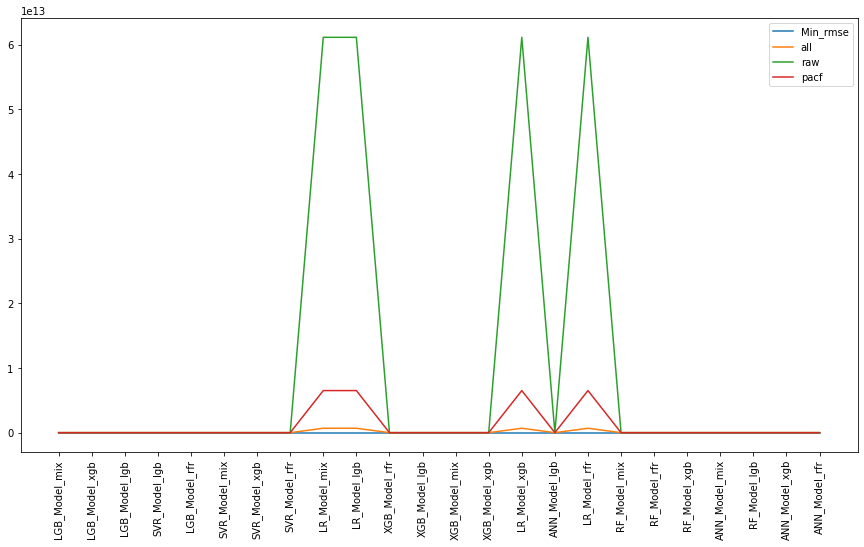

In [112]:
# plt.figure()
all_sort[['Min_rmse','all','raw','pacf']].plot(figsize=(15,8))
plt.xticks(range(0,len(all_sort.index),1),all_sort.index,rotation=90)
plt.savefig("./pic/RMSE/Website/Compare.png")
plt.show()

### 画图

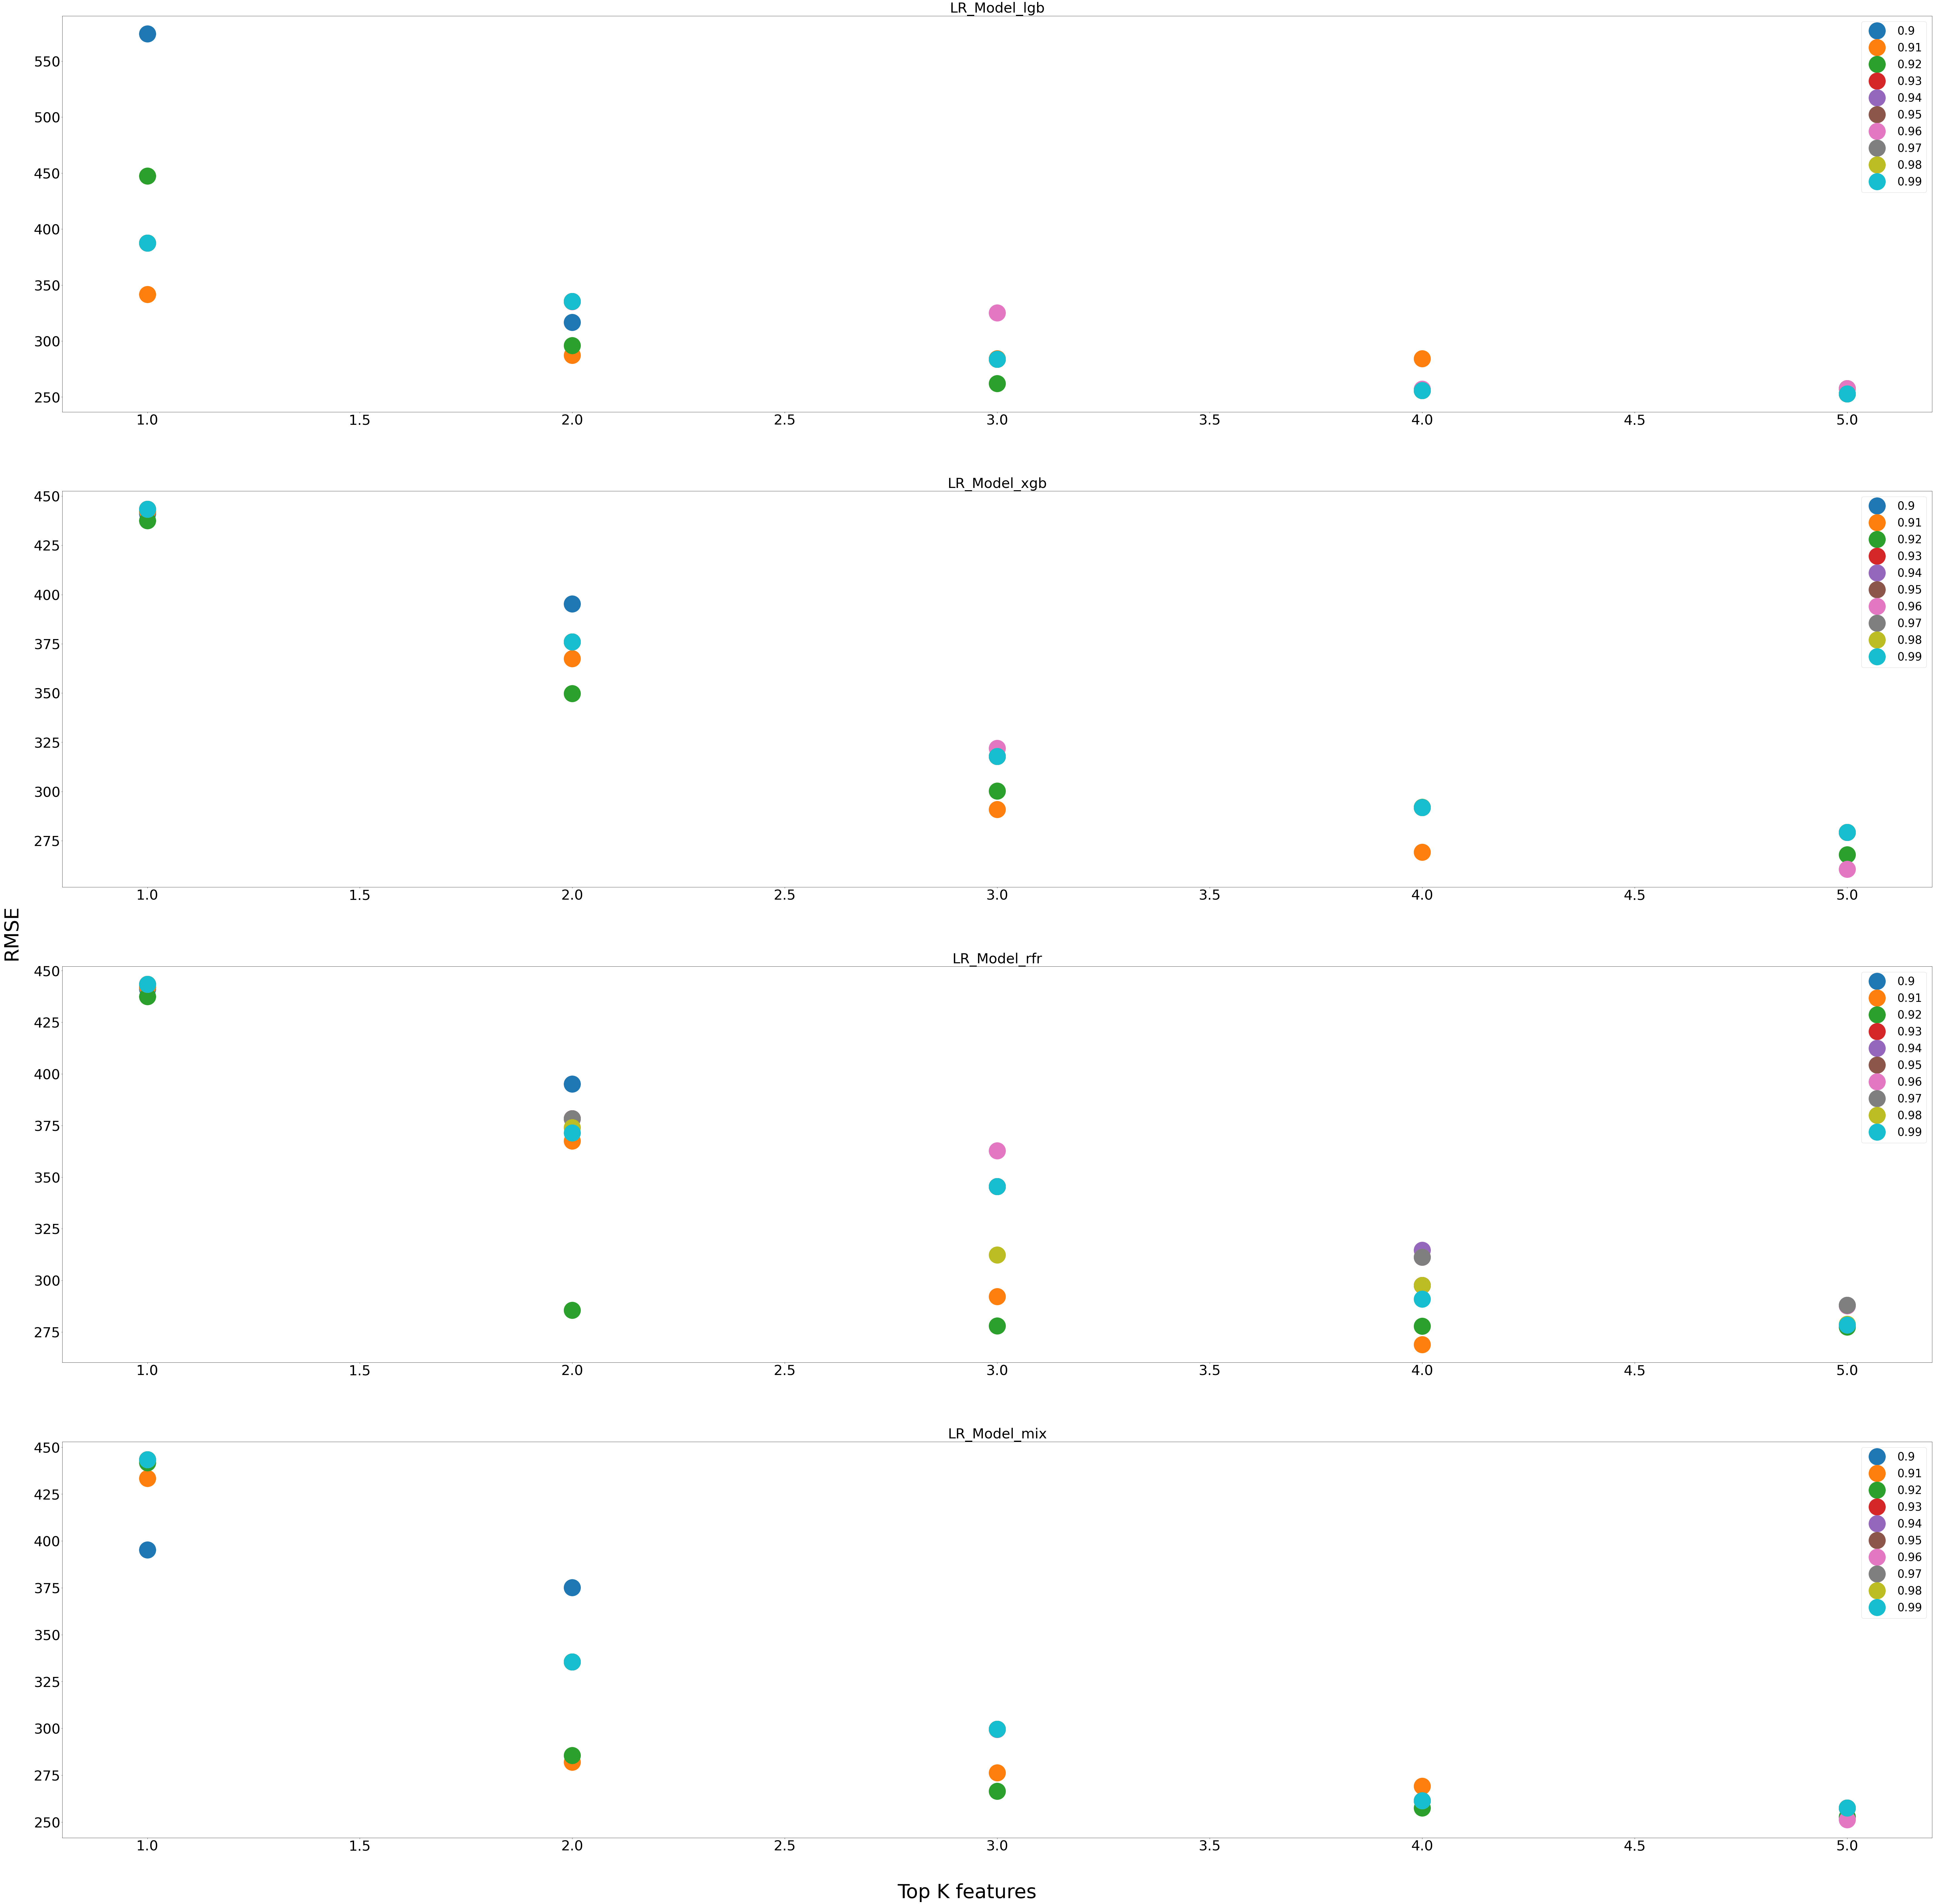

In [113]:
fig,ax = plt.subplots(len(linear_df),1,figsize=(120,120))
for order,k in zip(range(len(linear_df)),linear_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(linear_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize = 60)
    ax[order].legend(linear_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Website/Linear.png')

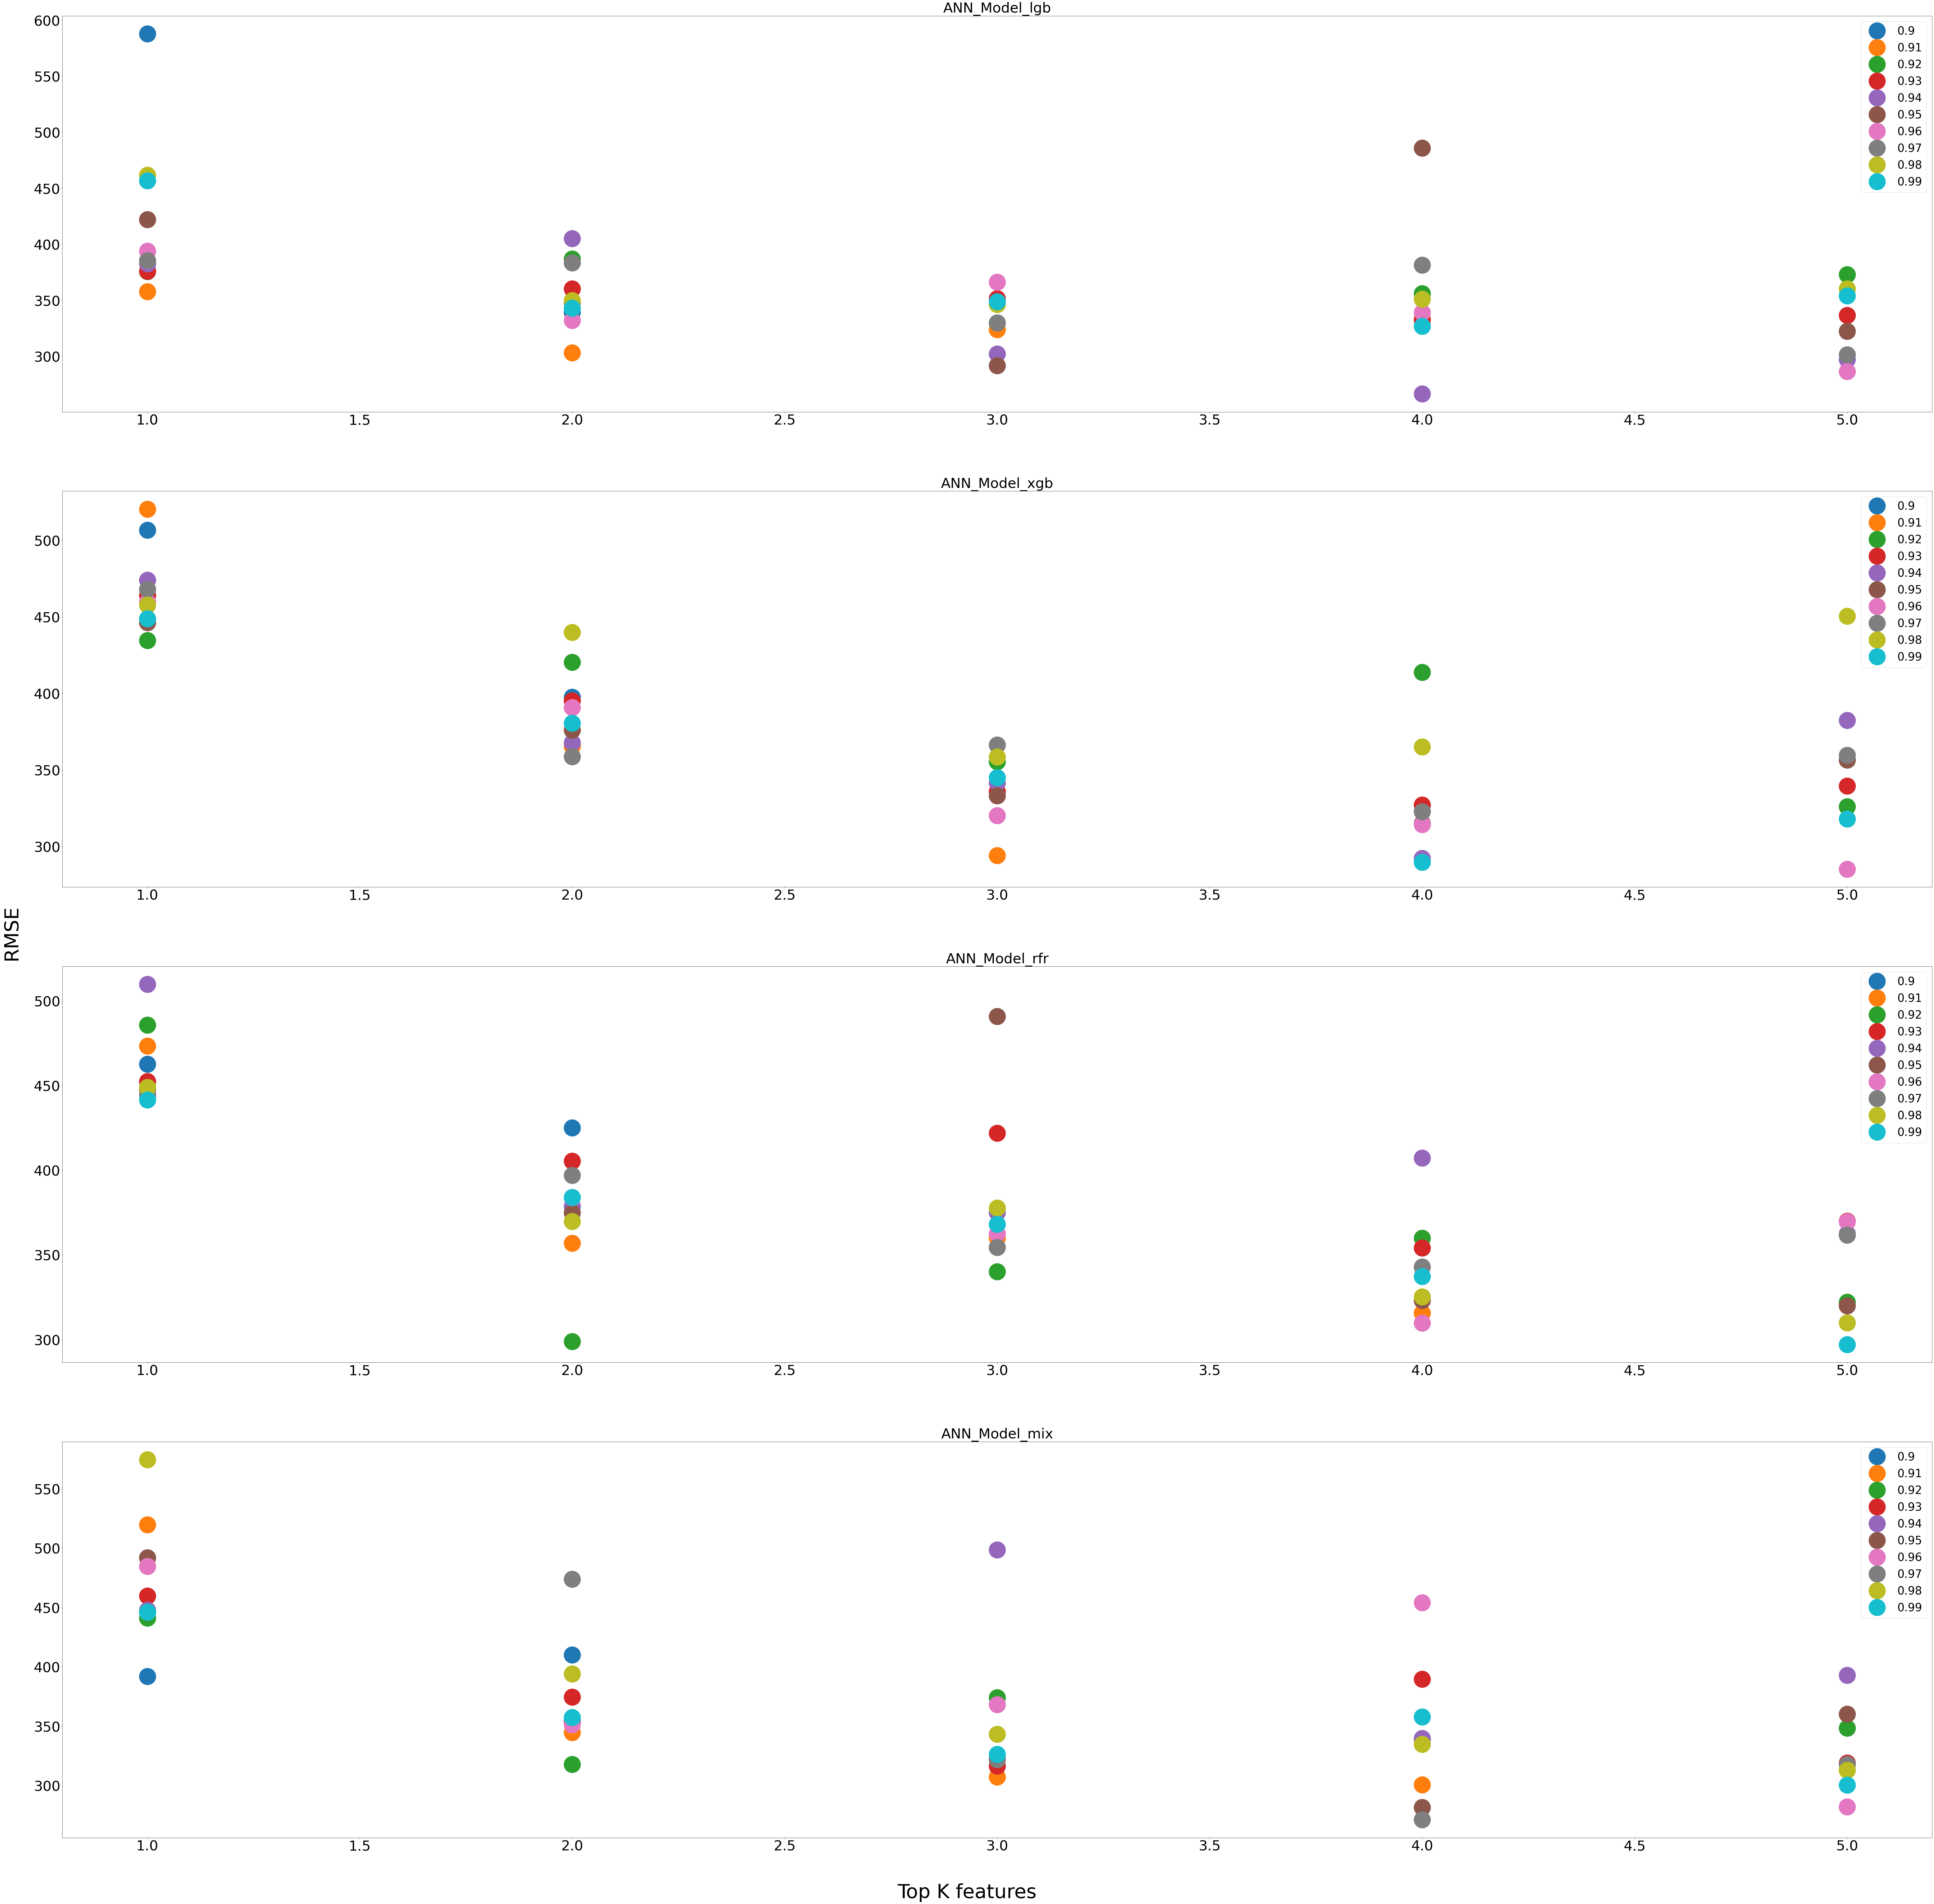

In [114]:
fig,ax = plt.subplots(len(ANN_df),1,figsize=(120,120))
for order,k in zip(range(len(ANN_df)),ANN_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(ANN_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize=60)
    ax[order].legend(ANN_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Website/ANN.png')

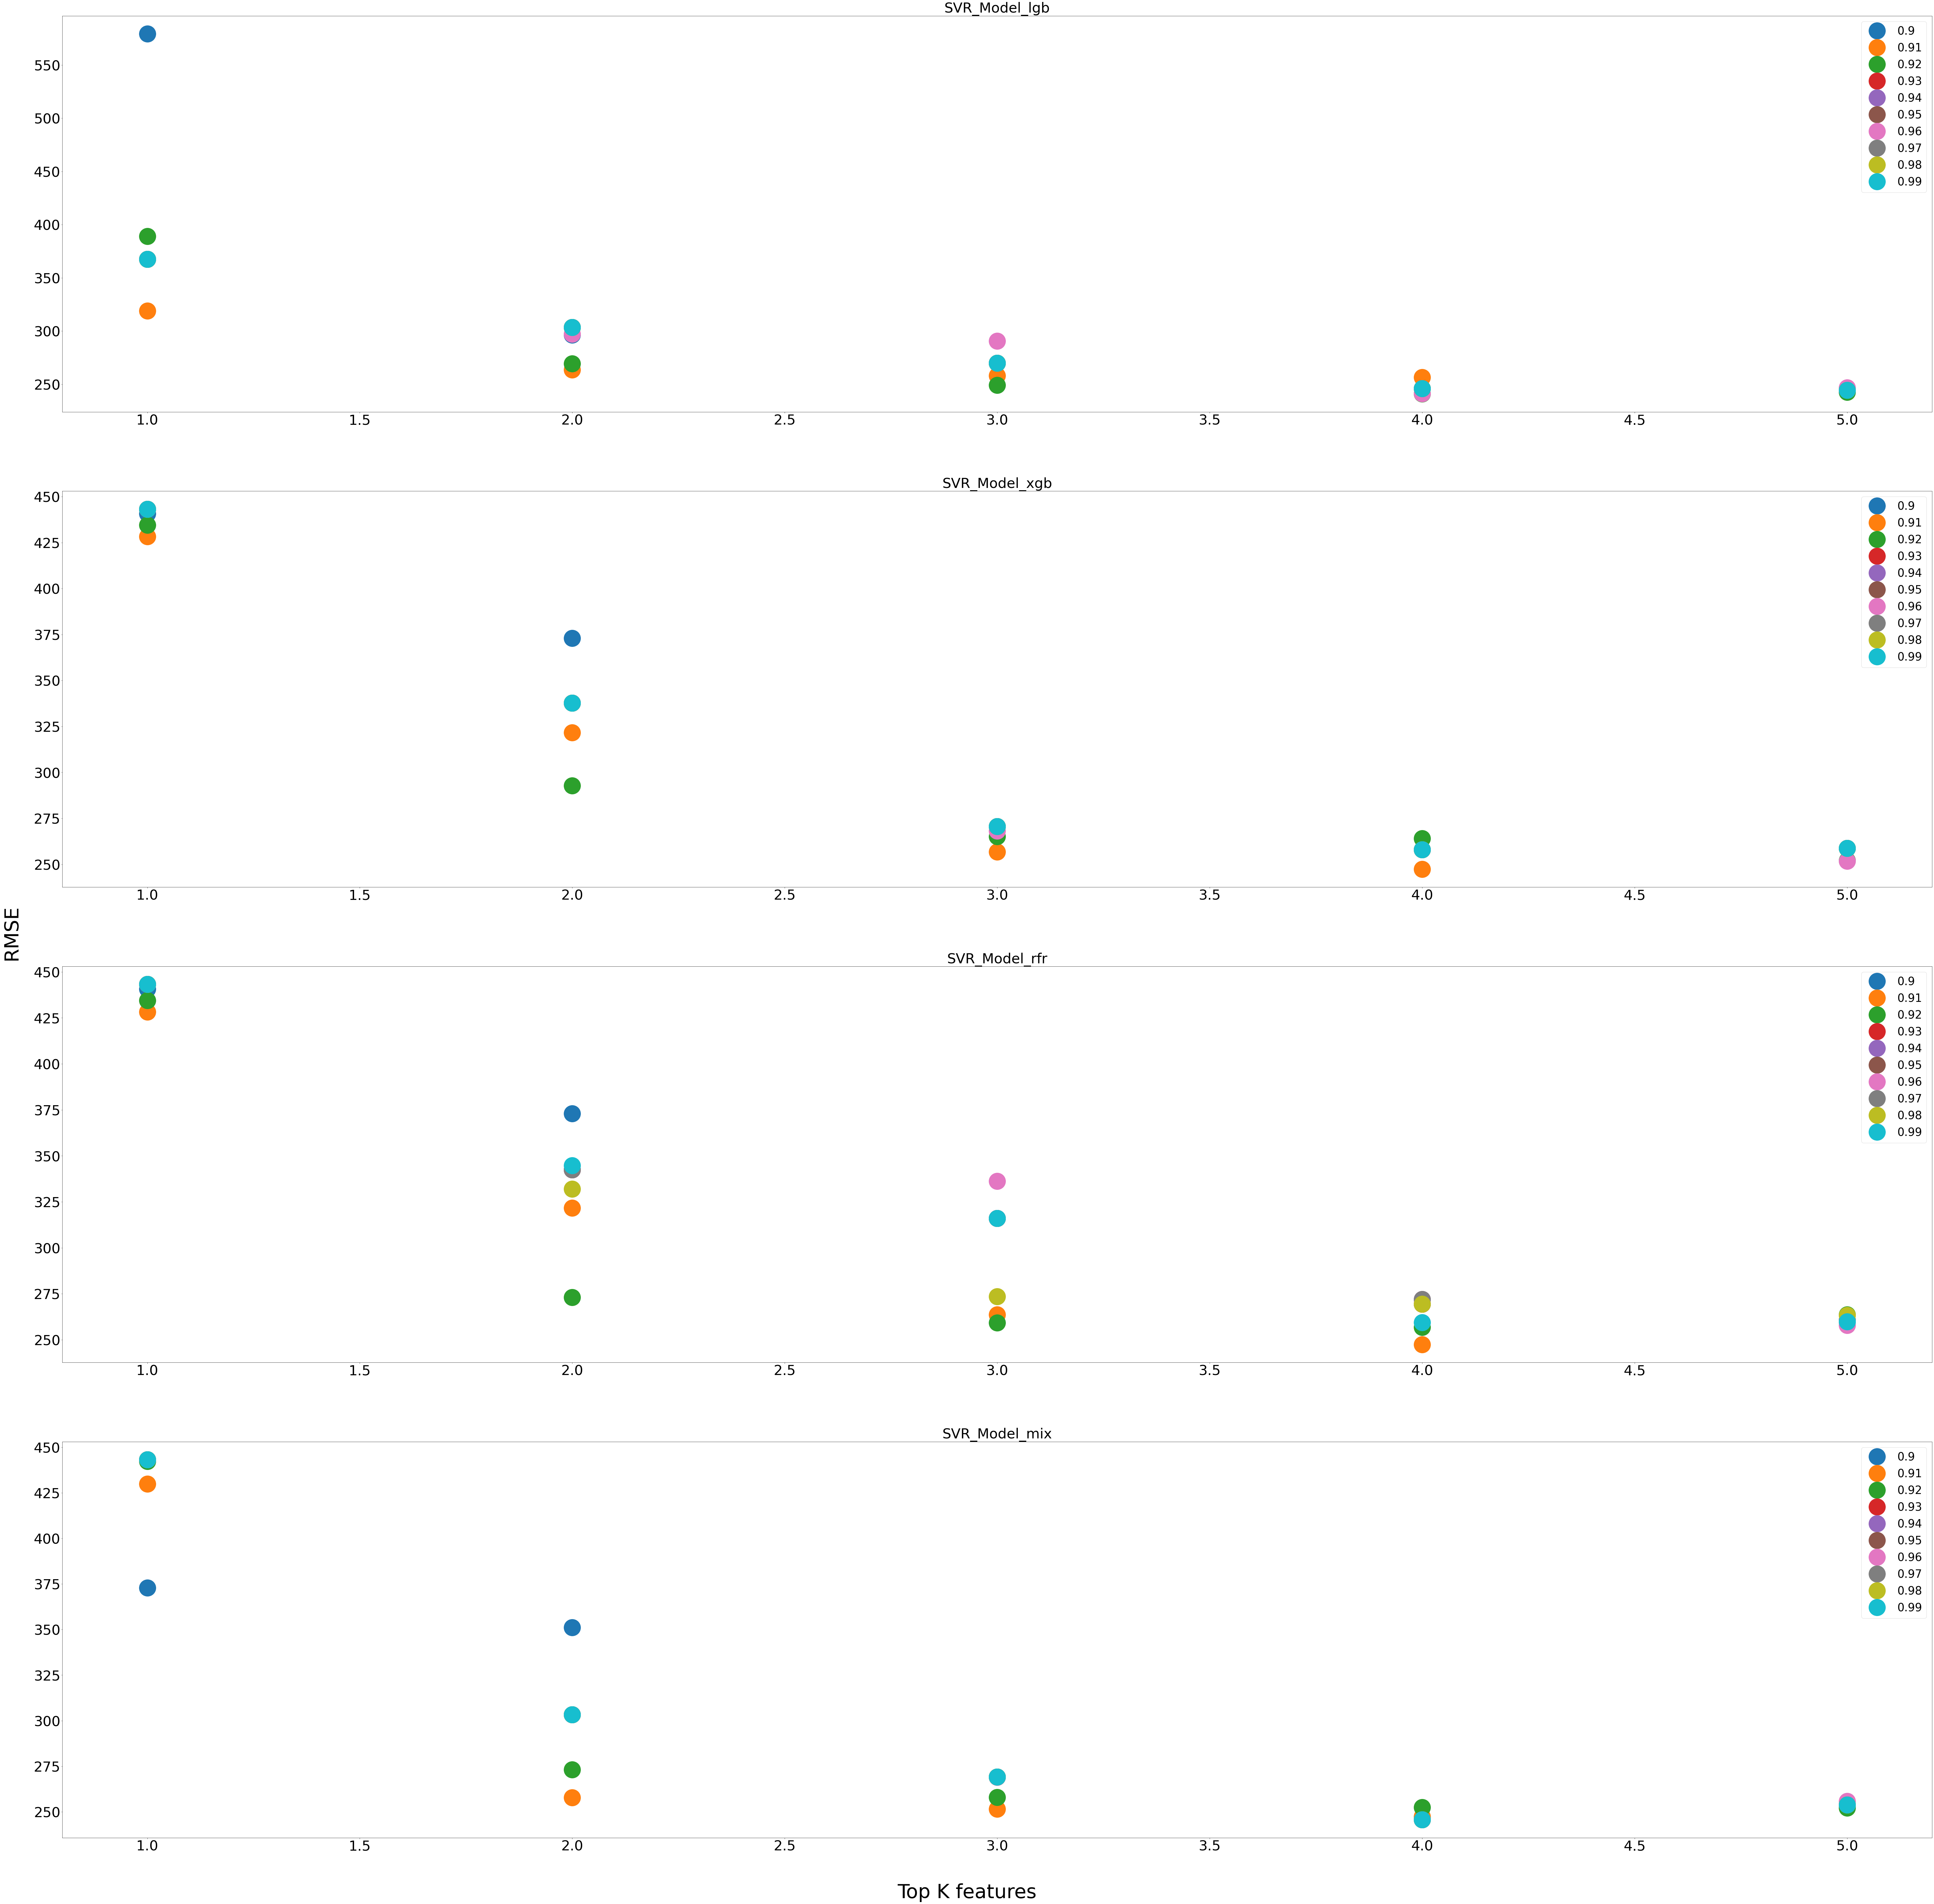

In [115]:
fig,ax = plt.subplots(len(SVR_df),1,figsize=(120,120))
for order,k in zip(range(len(SVR_df)),SVR_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(SVR_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize=60)
    ax[order].legend(SVR_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Website/SVR.png')

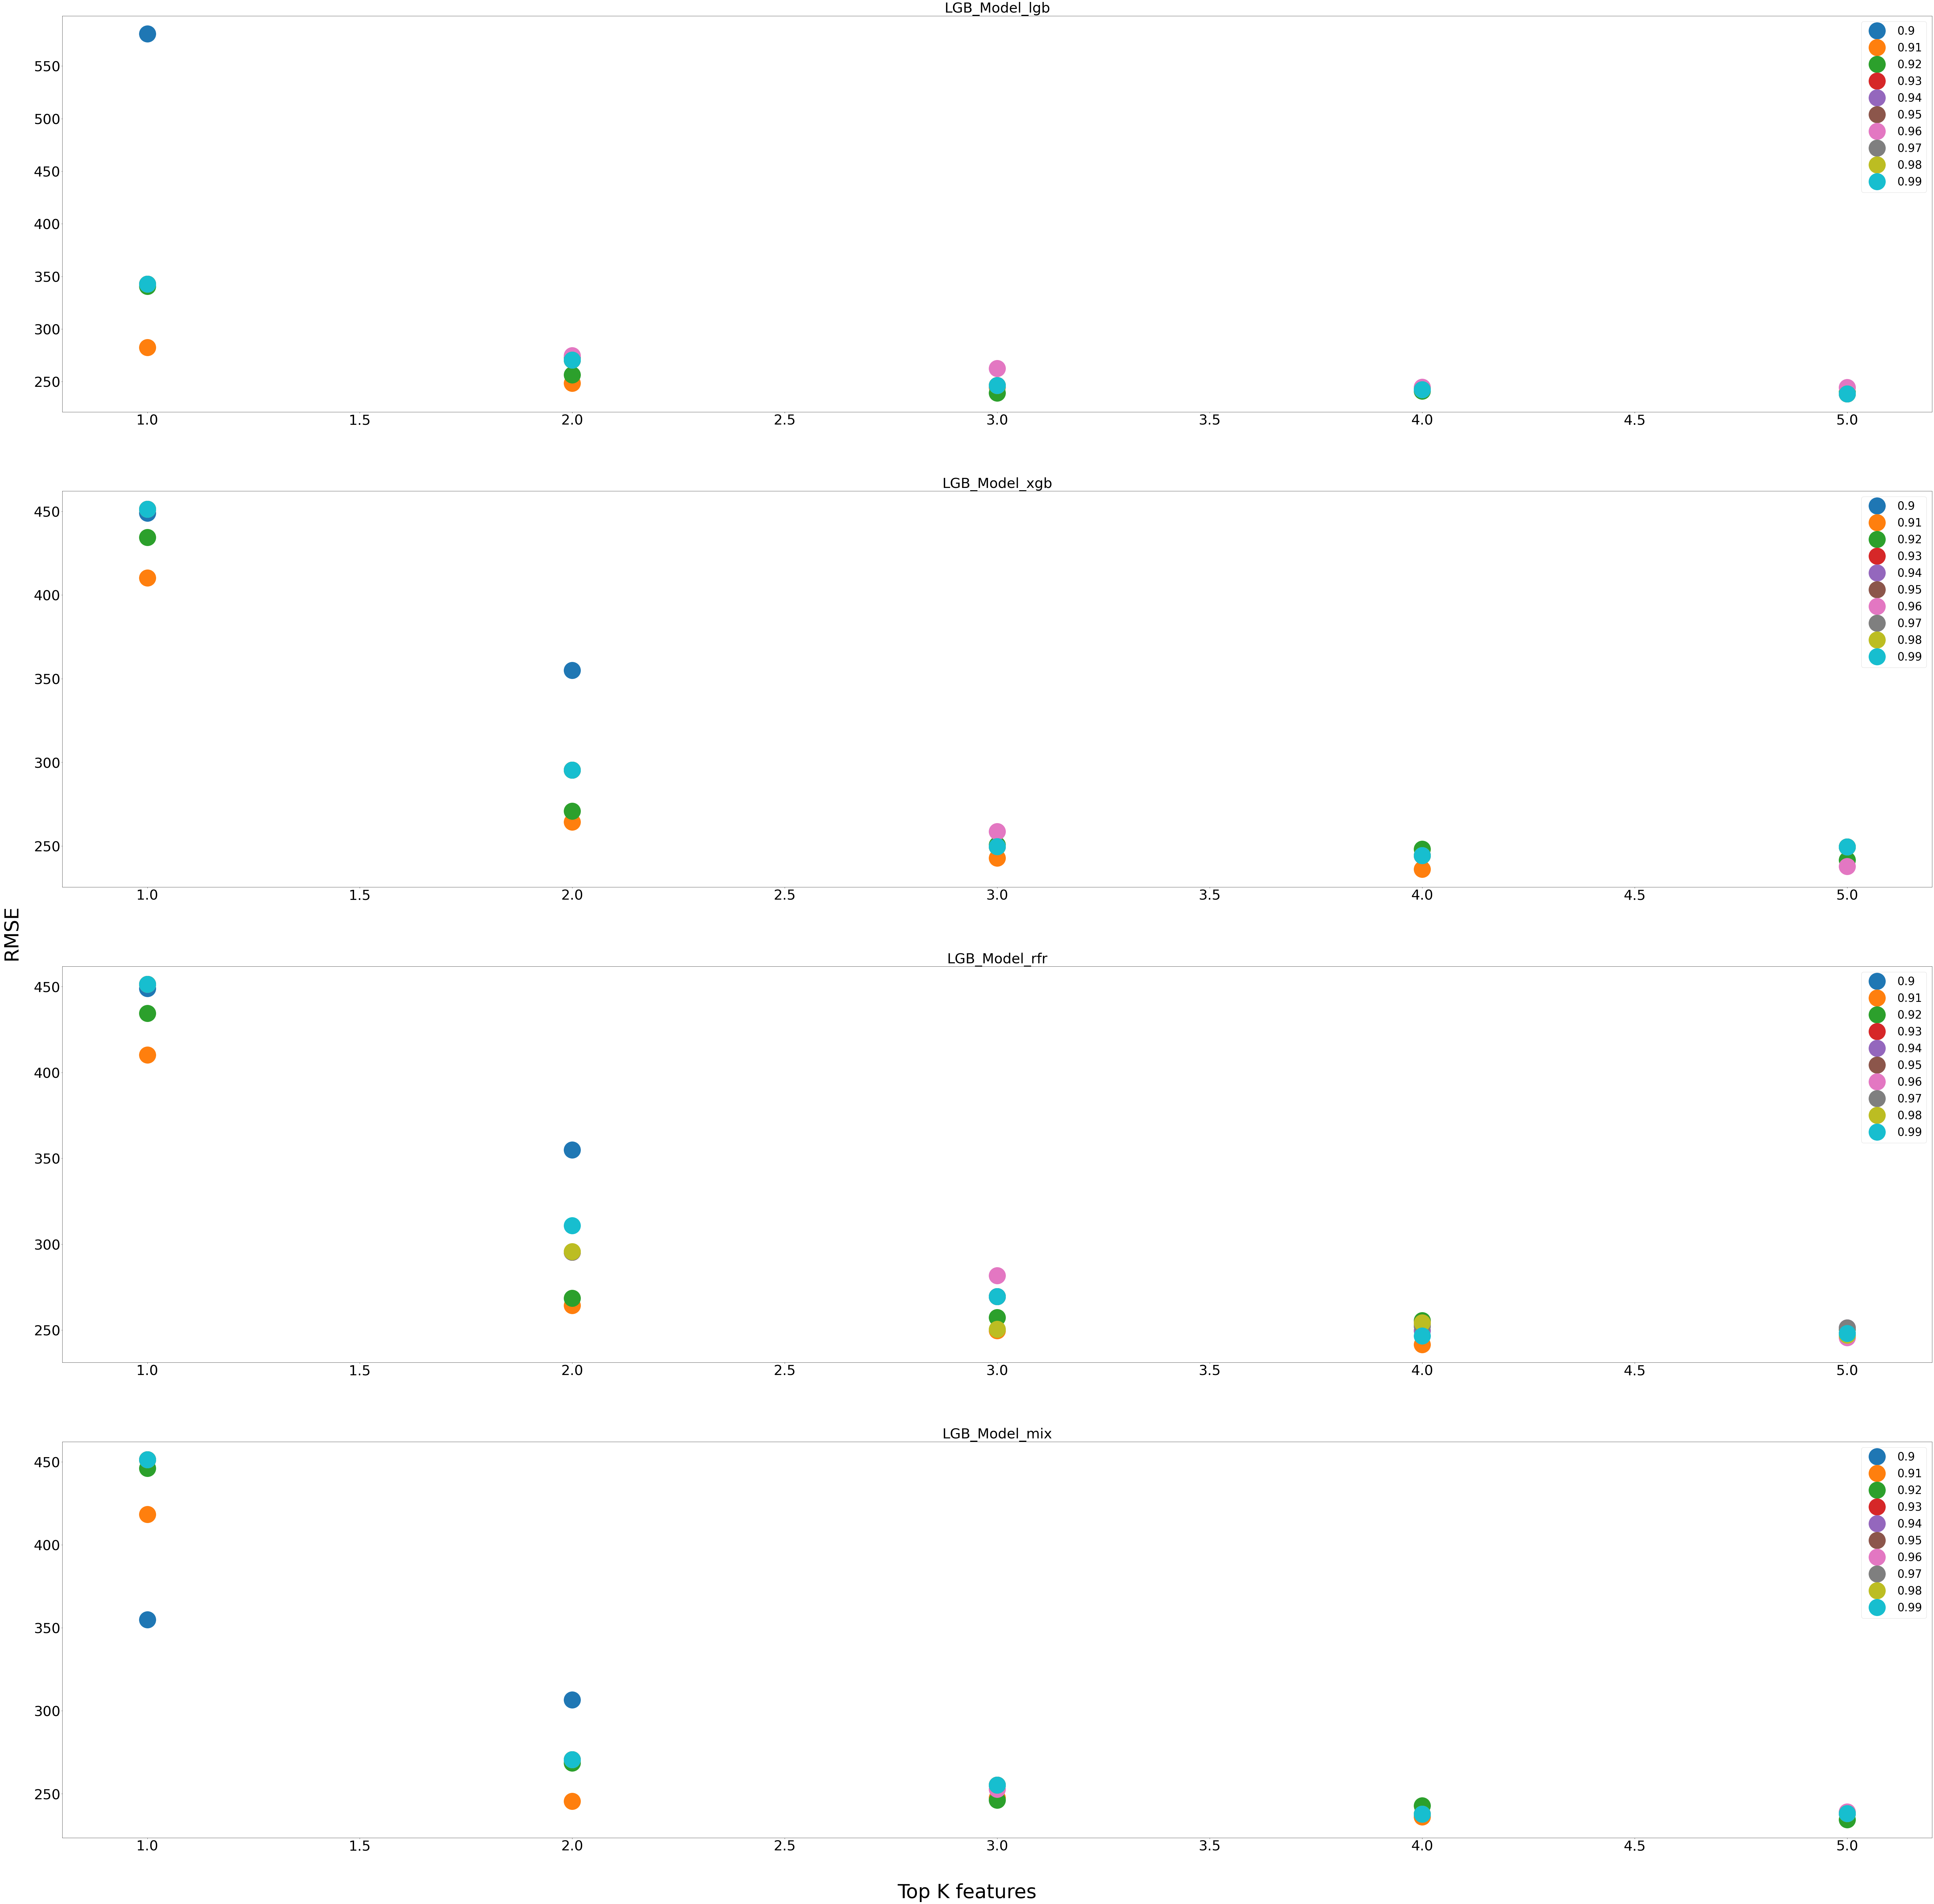

In [116]:
fig,ax = plt.subplots(len(LGB_df),1,figsize=(120,120))
for order,k in zip(range(len(LGB_df)),LGB_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(LGB_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize=60)
    ax[order].legend(LGB_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Website/LGB.png')

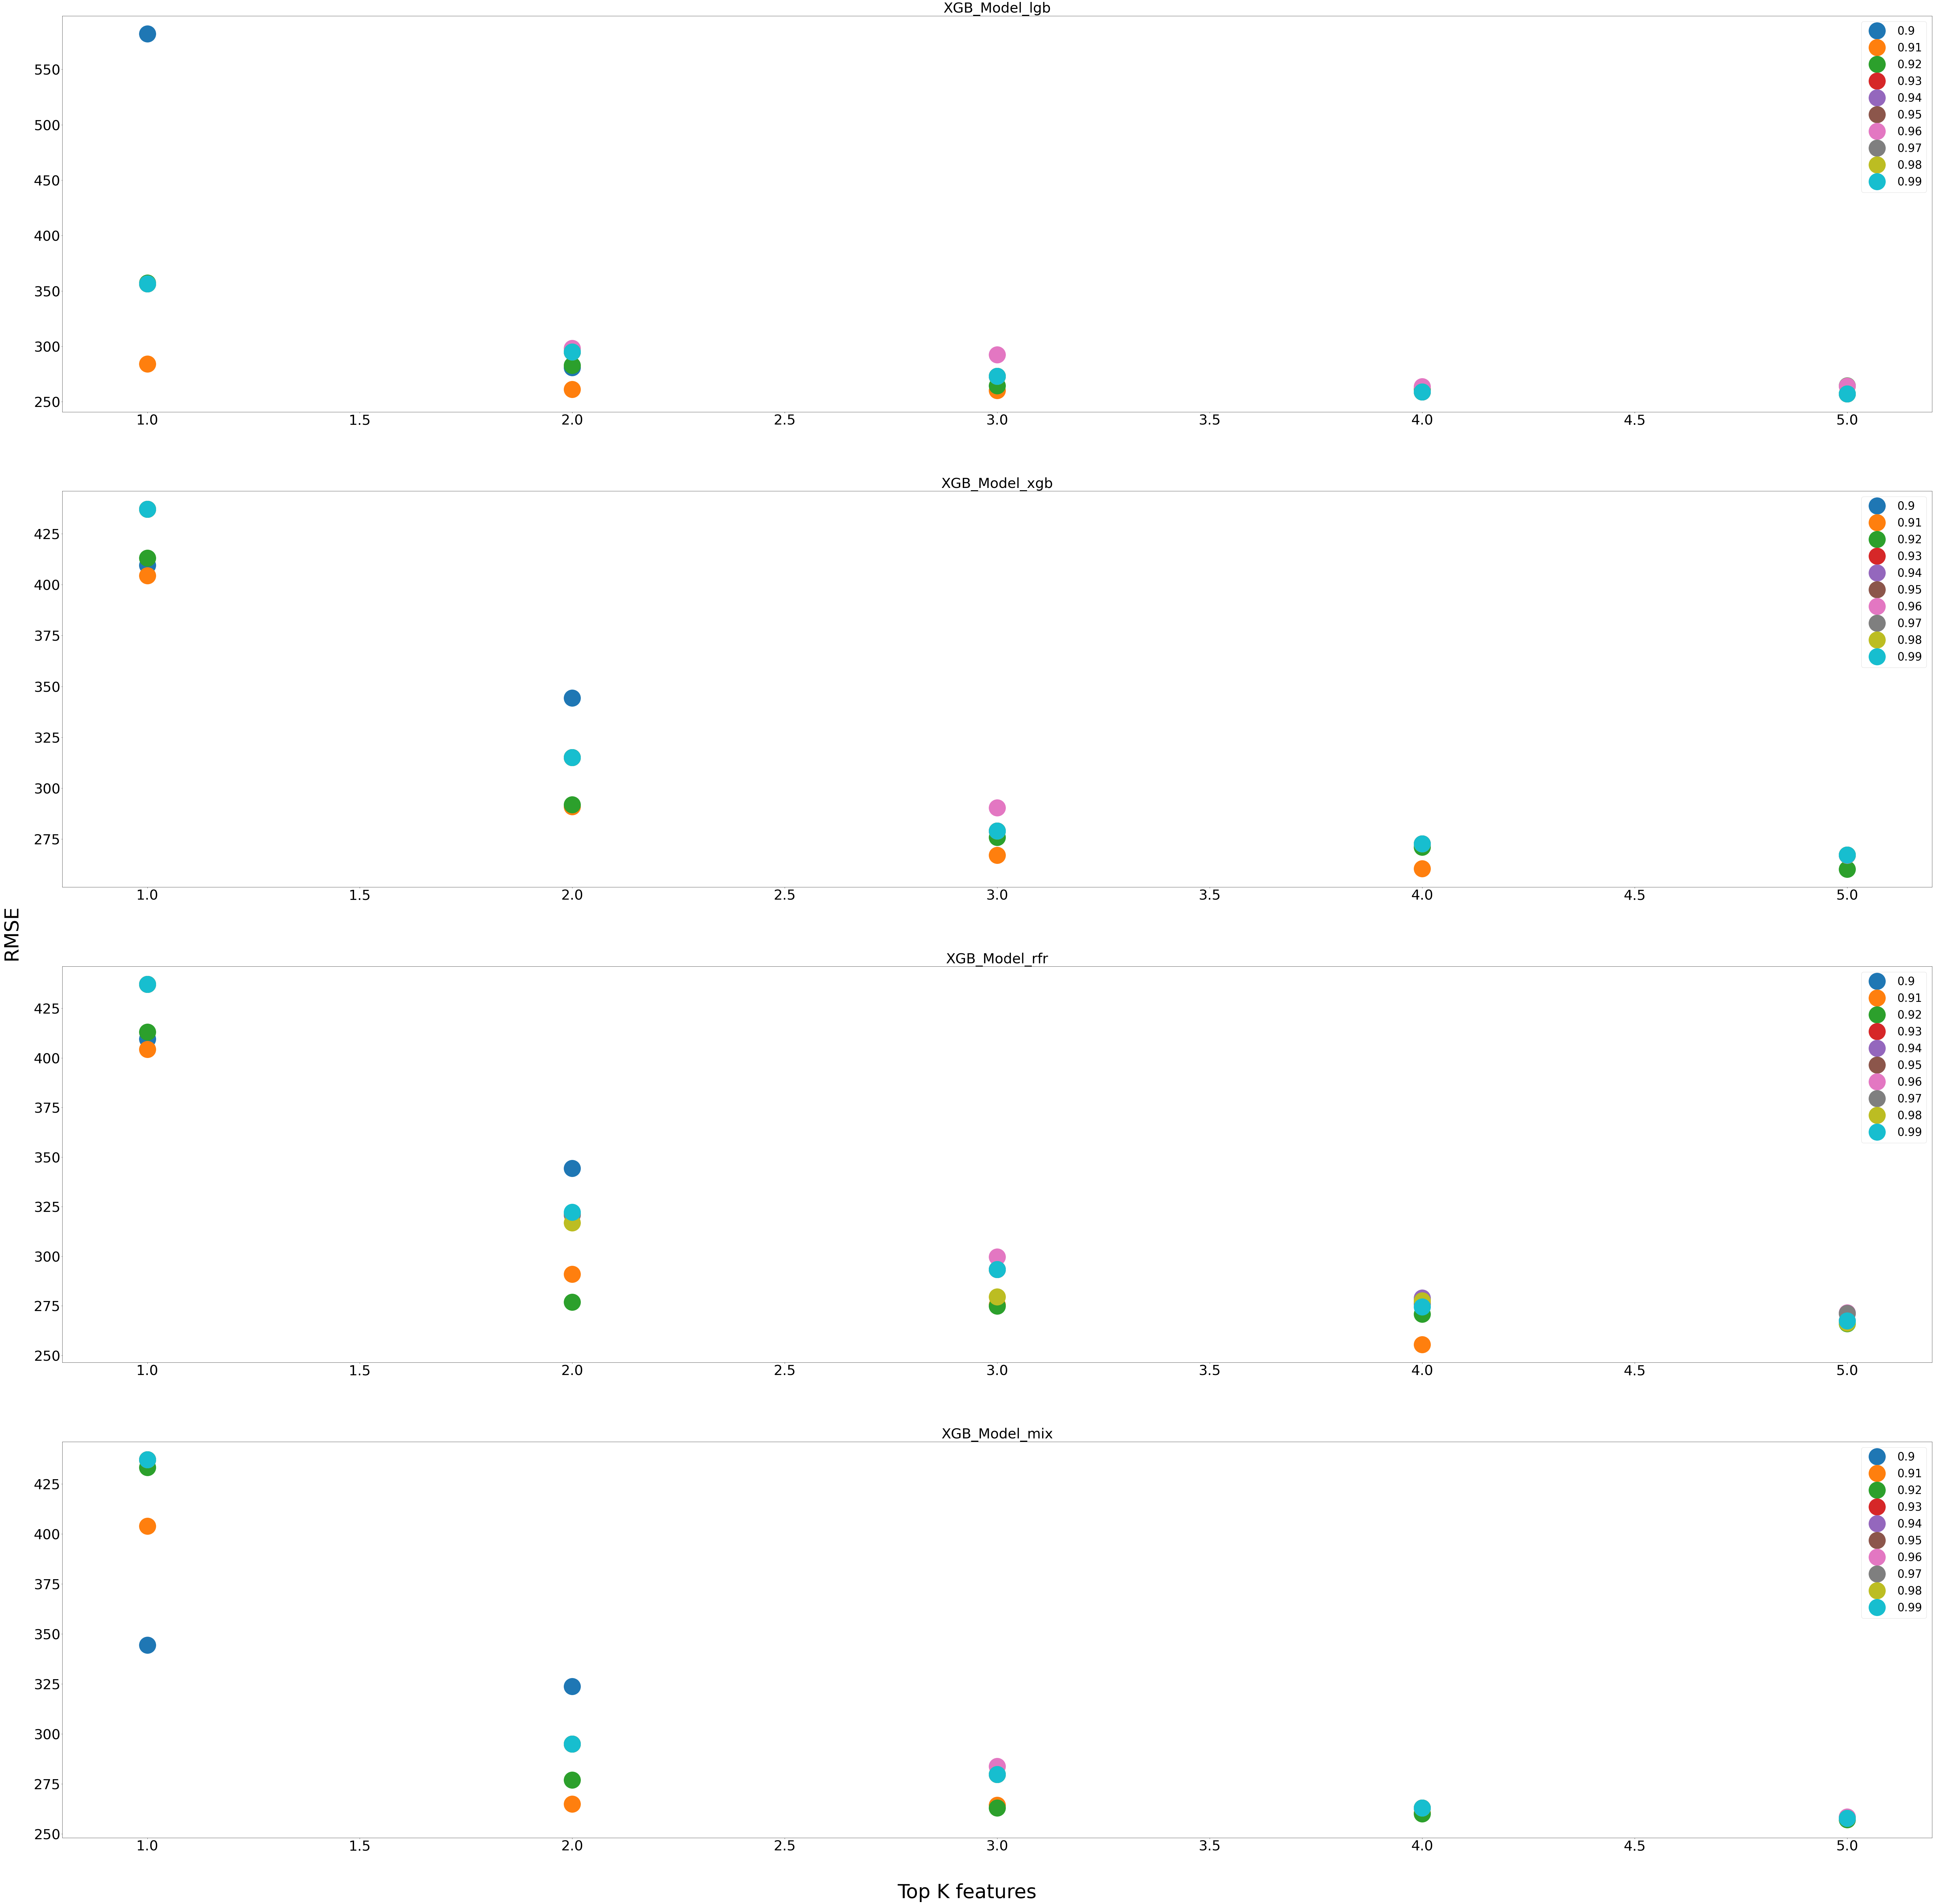

In [117]:
fig,ax = plt.subplots(len(XGB_df),1,figsize=(120,120))
for order,k in zip(range(len(XGB_df)),XGB_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(XGB_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize=60)
    ax[order].legend(XGB_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Website/XGB.png')

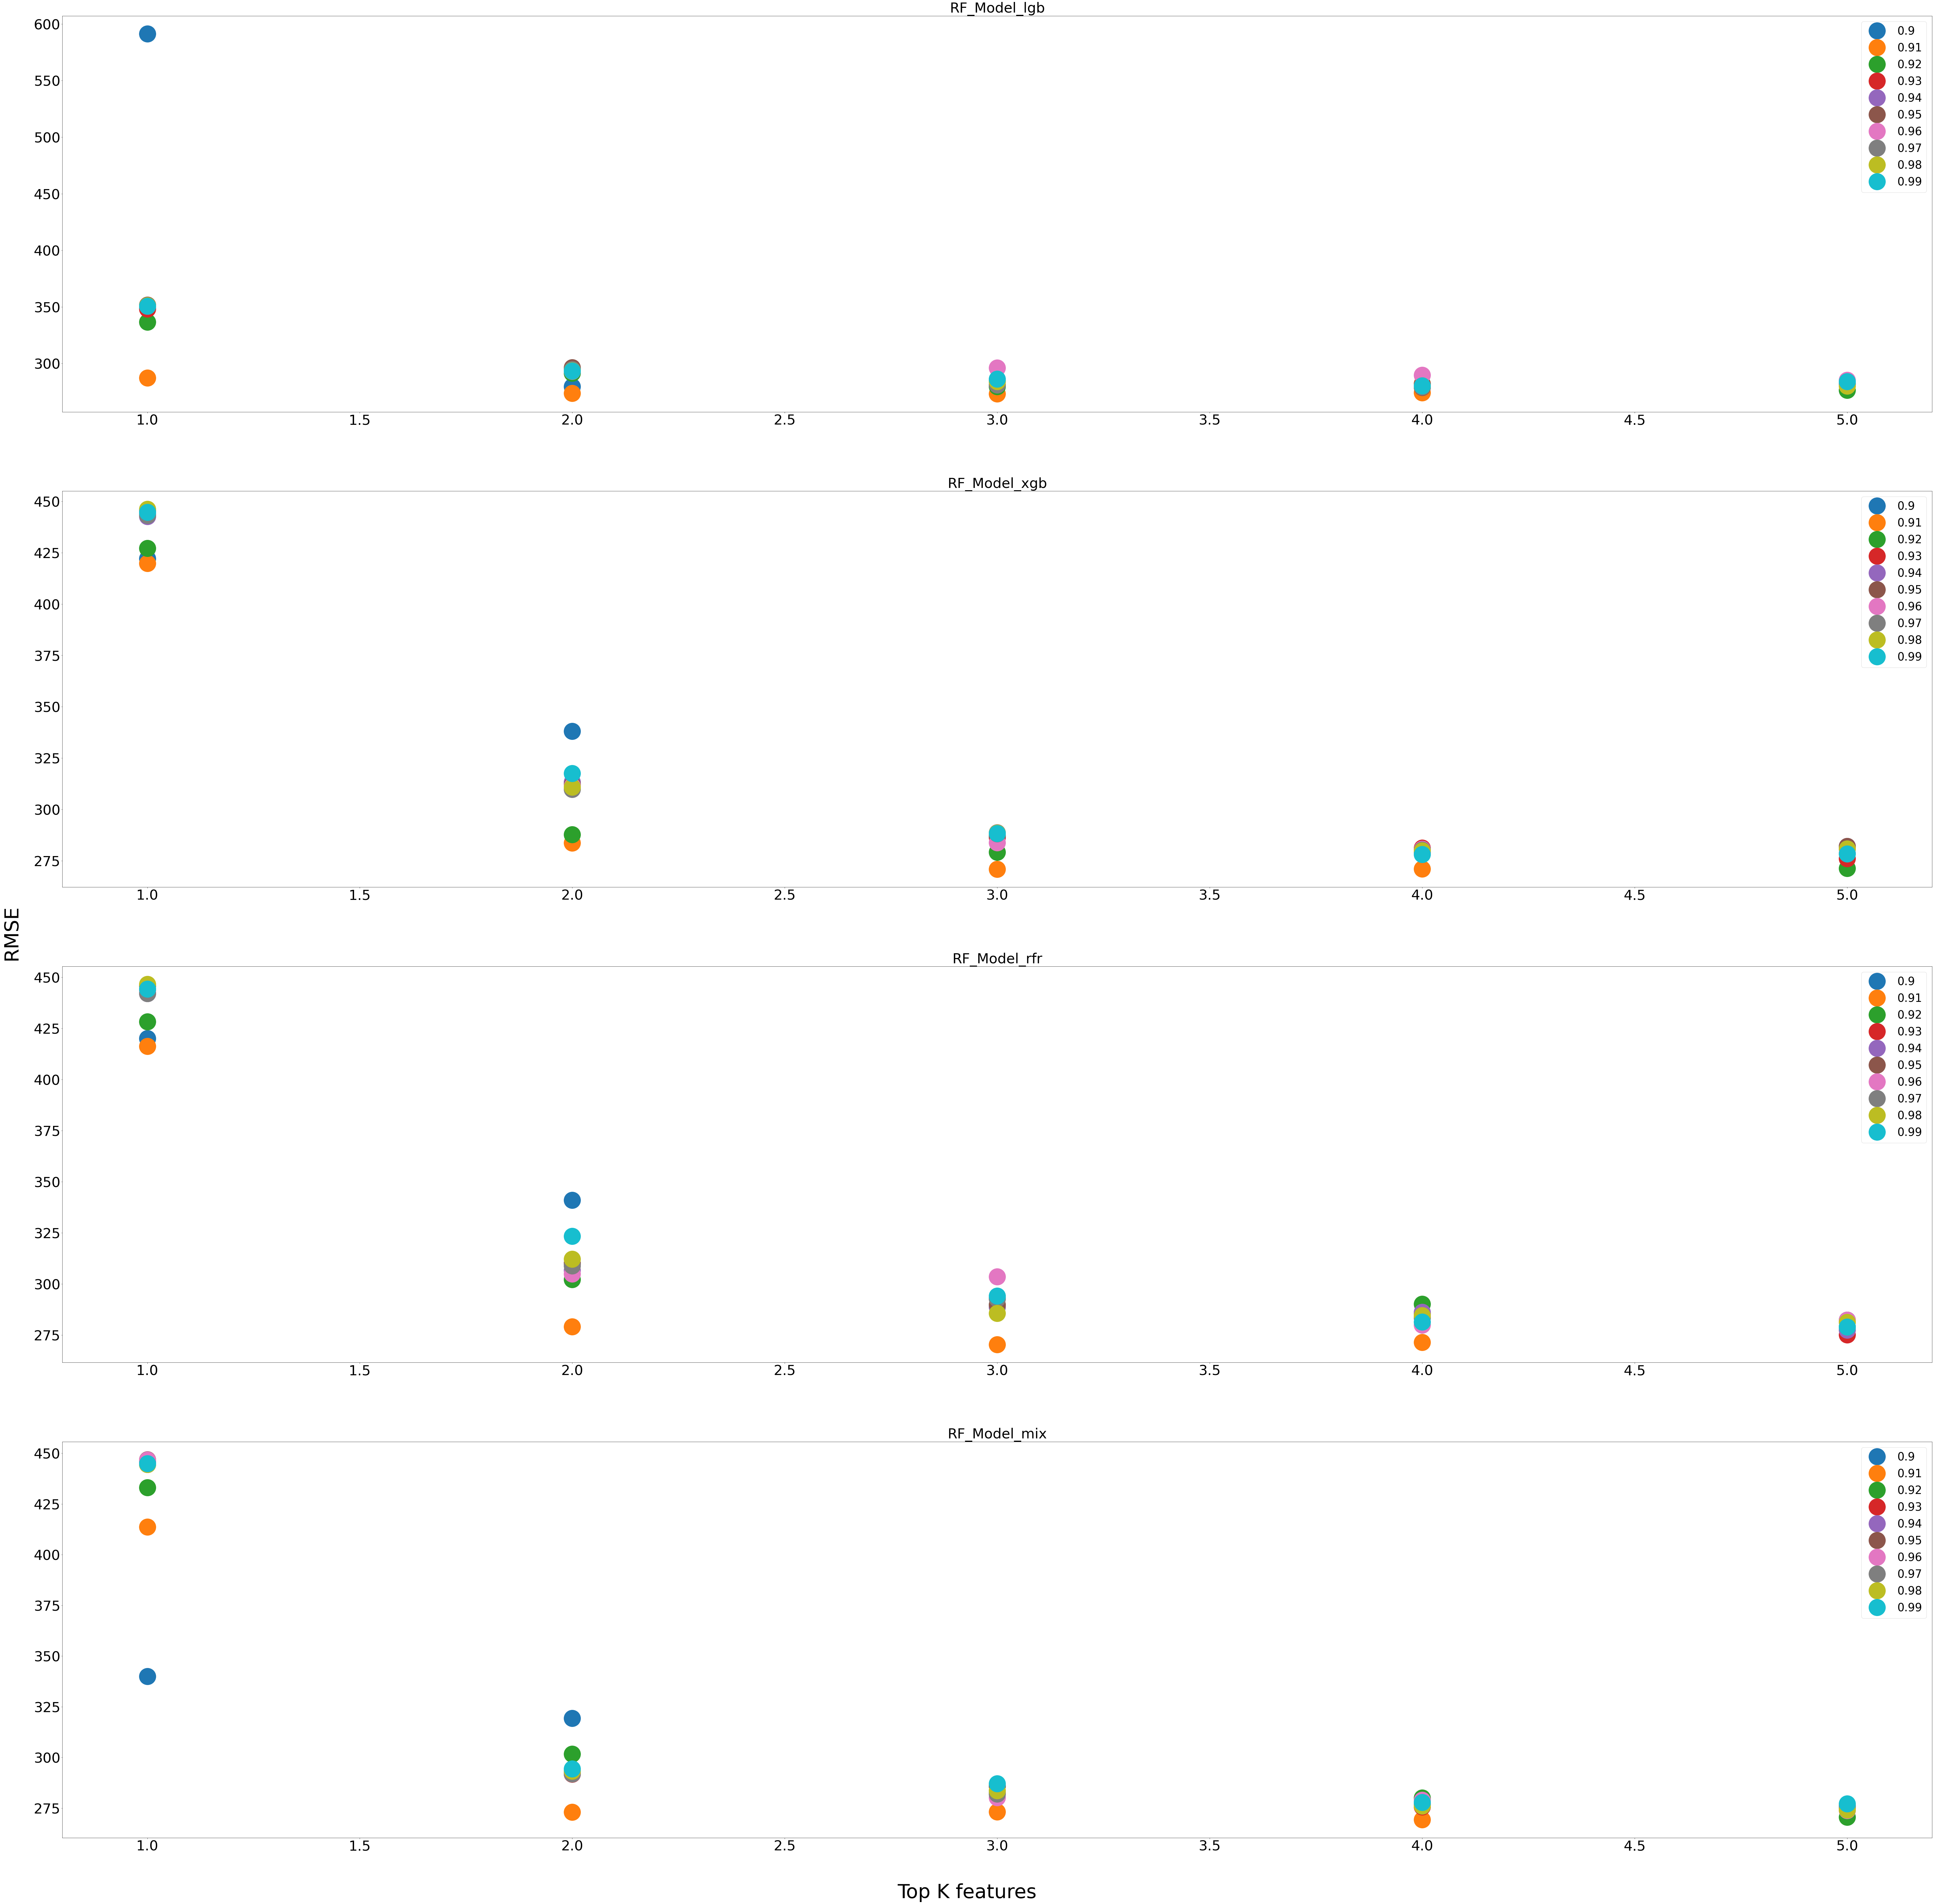

In [118]:
fig,ax = plt.subplots(len(RF_df),1,figsize=(120,120))
for order,k in zip(range(len(RF_df)),RF_df.keys()):
    ax[order].set_title(k,fontsize=50)
    ax[order].plot(RF_df[k].loc[:,pd.IndexSlice[:,'rmse']],'o',markersize=60)
    ax[order].legend(RF_df[k].columns.levels[0],fontsize=40)
    ax[order].tick_params(labelsize=50)

fig.text(0.5, 0.1, 'Top K features', ha='center',fontsize=70)
fig.text(0.1, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=70)
plt.savefig('./pic/RMSE/Website/RF.png')

In [119]:
def LGB_plot(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    
    gbm = lgb.LGBMRegressor(max_depth=12)
    gbm.fit(x_train, y_train)
    y_gbm = gbm.predict(x_test)
    y_gbm_inverse =minmax_y_test.inverse_transform(y_gbm.reshape((-1,1)))
    
    y_df = pd.DataFrame({
        'Actual':y_gbm_inverse.reshape(-1,),
        'Predicted':y_test_inverse.reshape(-1,)
    },index=Y_test.index)
    print(r2_score(y_gbm_inverse.reshape(-1,),y_test_inverse.reshape(-1,)))
    plt.figure(figsize=(15,8))
    plt.xticks(range(0,len(y_df.index),10),rotation=45)
    plt.plot(y_df['Actual'],label='Actual')
    plt.plot(y_df['Predicted'],linestyle='dashdot',label='Predicted')
    plt.legend()
    plt.savefig("./pic/RMSE/Website/Final_prediction.png")
    return y_df

0.9304179842873739


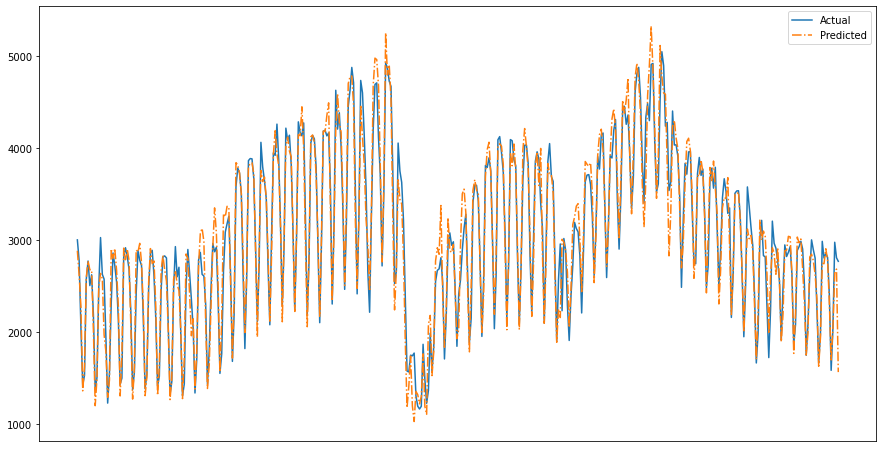

In [120]:
yy = LGB_plot(X_train_lag[real_mix[0.92][5]],Y_train_lag,X_test_lag[real_mix[0.92][5]],Y_test_lag)